In [1]:
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

## Data preprocessing

In [2]:
df = pd.read_csv('/home/work/DLmath/Seulbin/coin/data/KRW-XRP-merged.csv', index_col=0)

In [3]:
df = df.drop(['open', 'high', 'low', 'value'], axis=1)

In [4]:
df['close']= df['close']*(1/10000) #단위가 만원이기때문에 scale조정해주기
df['diff'] = df['close'].diff()
df['cash'] = np.zeros(df.shape[0])
df['coin'] = np.zeros(df.shape[0])
df['action'] = np.zeros(df.shape[0])

In [5]:
df['diff_100']  = df['close'].diff(periods=10)

df['volume_SMA100'] = df['volume'].rolling(10).mean()

df = df[['close', 'diff', 'volume', 'cash', 'coin', 'action', 'diff_100', 'volume_SMA100']]

df = df[10:]

In [6]:
df.head()

close    diff  volume  cash  coin  action  diff_100  \
2017-09-25 23:40:00  0.0203  0.0000  0.0004   0.0   0.0     0.0    0.0003   
2017-09-25 23:50:00  0.0204  0.0001  0.0003   0.0   0.0     0.0    0.0004   
2017-09-26 00:00:00  0.0202 -0.0002  0.0004   0.0   0.0     0.0    0.0002   
2017-09-26 00:10:00  0.0202  0.0000  0.0004   0.0   0.0     0.0    0.0002   
2017-09-26 00:30:00  0.0203  0.0001  0.0003   0.0   0.0     0.0    0.0003   

                     volume_SMA100  
2017-09-25 23:40:00        0.00037  
2017-09-25 23:50:00        0.00036  
2017-09-26 00:00:00        0.00037  
2017-09-26 00:10:00        0.00037  
2017-09-26 00:30:00        0.00036

In [7]:
# 결측치 확인
print(df.isnull().values.any())
print(df.isna().values.any())

False
False


In [8]:
data_array = df.to_numpy()
data_array.shape

(357872, 8)

## Environment

In [9]:
class coin_env:
    def __init__(self, df, start_index, action_space=np.array([-1,0,1]),fee=0.001 , eps= 0.001):
        self.df = df
        self.action_space = action_space   # -1: sell, 0: hold, 1:buy
        self.action_size  = action_space.shape[0]
        self.array = self.df.to_numpy(dtype=float)
        self.start_index = start_index
        
        self.close    = self.array[:,0]   # 'close'
        self.state1   = self.array[:,1:6] # 'diff', 'volume', 'cash', 'coin', 'action'
        self.state10  = self.array[:,6:8] # 'diff_100', 'volume_SMA100'
        self.reward   = np.zeros(self.close.shape)
        
        self.fee = fee
        self.eps = eps
        
        self.max_episodes = self.array[start_index:,:].shape[0] // 1440
        print('Possible number of episodes:', self.max_episodes)
        
    def reset(self, n, init=1000, cash_ratio=0.5): 
        
        '''
        n    : the nth episode from the given data (n=0,1,2,...)
        init : The amount of asset in the beginning of the nth episode
        Initialize the state and return the starting state and the index of the next state
        '''
        
        # n번째 날 시작 시간 Index 
        day_index = 1440 * n + self.start_index
        
        self.state1[day_index][2] = init * cash_ratio
        self.state1[day_index][3] = init * (1-cash_ratio)
        
        return day_index
    
    
    def step(self, state_index, action):
        '''
        Given current state(index) and action,
        find next state and compute the reward.
        action : 0,1,2 which correspond to the indices of the action space.
        
        state_index:
        action:
        fee: 사고 팔 때의 수수료
        eps: 자주 거래하는 것에 대한 페널티
        '''
        done = False
        
        # done = True when the 'next' state time == 8:59
        # done : 현재 자산이 없어지는 경우에도 done을 만들어야 하지 않나?
        if (state_index-self.start_index) % 1440 == 1438:
            done = True
            
        # Bring the numpy array
        X = self.state1.copy()
        
        # current_state : [diff, volume, cash, coin, previous action]
        current_state = X[state_index]
        
        # current_action : -1, 0, 1
        # action_space = np.array([-1,0,1])
        # 10% 확률로 거래 미체결 (current_action = 0 -> hold)
        current_action = self.action_space[action] * (np.random.rand()>0.1)
        
        next_state = X[state_index+1]
        
        # Compute Reward
        if current_state[2] - current_action - abs(current_action)*self.fee >= 0 and current_state[3] + current_action  >= 0:
            next_state[2] = current_state[2] - current_action - abs(current_action)*self.fee
            next_state[3] = ( current_state[3] + current_action ) * (self.close[state_index+1]/self.close[state_index])
            next_state[4] = current_action
            
        else:
            next_state[2] = current_state[2]
            next_state[3] = current_state[3] * (self.close[state_index+1]/self.close[state_index])
            next_state[4] = 0
        
        # If my asset is too low
        if sum(next_state[2:4]) < 50:
            done = True

        reward = sum(next_state[2:4] - current_state[2:4]) - eps*abs(current_action)
        
        self.reward[state_index+1] = reward
        
        self.state1[state_index+1] = next_state
        
        # Return (Next state_index, reward, whether the next state is the last time)
        return state_index+1, reward, done

## Model

input_shape_10   = (100,5)     # 10분봉 100개, feature 5개 (diff, volume, cash, coin, prev_action)\
input_shape_100  = (100,2)     # 100분봉 100개, feature 2개 (diff_100, volume SMA 100)\

In [10]:
class DQN(nn.Module):
    def __init__(self, action_size=3):
        super(DQN, self).__init__()
        self.action_size= action_size
        
        self.relu = torch.tanh
        self.maxpooling = nn.MaxPool1d(kernel_size=2)
        self.flatten = torch.flatten
        
        self.net_x_1 = nn.Conv1d(in_channels=5,  out_channels=10, kernel_size=10, stride=3)
        self.net_x_2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=7,  stride=3)
        
        self.net_y_1 = nn.Conv1d(in_channels=2,  out_channels=10, kernel_size=10, stride=3)
        self.net_y_2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=7,  stride=3)

        self.linear_1 = nn.Linear(360, 200)
        self.linear_2 = nn.Linear(200, 3)
        
    def forward(self, d):
        
        ### input_shape_10
        x = self.relu(self.net_x_1(d[0]))
        #print(f'x shape : {x.shape}')
        #print(f'x layer1 : {x}')
        x = self.relu(self.net_x_2(x))
        #print(f'x layer2 : {x}')
        x = self.flatten(x, start_dim=1)
        #print(f'x layer3 : {x}')

        ### input_shape_100
        y = self.relu(self.net_y_1(d[1]))
        y = self.relu(self.net_y_2(y))
        y = self.flatten(y, start_dim=1)
        
    
        ###
        q = torch.cat((x,y), dim= 1) 
        #print(f'shape : {q.shape}')
        #print(f'layer1 : {q}')
        q = self.relu(self.linear_1(q))
        #print(f'layer2 : {q}')
        q = self.linear_2(q)
        #print(f'layer3 : {q}')

        return q

## Utils

In [11]:
from collections import deque

class ReplayBuffer():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, state1, state10, action, reward, next_state1, next_state10, done):
        self.buffer.append([state1, state10, action, reward, next_state1, next_state10, done])

    def replay_buffer_sampling(self, batch_size):
        experience_samples = random.sample(self.buffer, batch_size)
        state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr = map(np.asarray, zip(*experience_samples))
        return state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr

    def size(self):
        return len(self.buffer)

In [12]:
def update_target(behavior, target):
    target.load_state_dict(behavior.state_dict())

###### 수정 필요 ############
def soft_update_target(behavior, target, TAU):
    for t, e in zip(target.trainable_variables, behavior.trainable_variables):
        t.assign(t * (1 - TAU) + e * TAU)

In [13]:
def update_Q(behavior_net, target_net, optimizer, buffer, batch_size, gamma, device):

    behavior_net = behavior_net.to(device)
    target_net   = target_net.to(device)
    
    state1_arr, state10_arr, action_arr, reward_arr, next_state1_arr, next_state10_arr, done_arr = buffer.replay_buffer_sampling(batch_size)
    
    state1_arr   = torch.FloatTensor(state1_arr).to(device)
    state10_arr  = torch.FloatTensor(state10_arr).to(device)
    action_arr   = torch.FloatTensor(action_arr).to(device)
    next_state1_arr = torch.FloatTensor(next_state1_arr).to(device)
    next_state10_arr = torch.FloatTensor(next_state10_arr).to(device)
    reward_arr = torch.FloatTensor(reward_arr).to(device)
    done_arr =torch.FloatTensor(done_arr).to(device)
    
    predicts = torch.sum(behavior_net([state1_arr, state10_arr])*action_arr, dim=1)
    next_q =target_net([next_state1_arr, next_state10_arr])
    next_q_values = torch.max(next_q, dim=1)[0]
    targets = reward_arr + gamma*next_q_values   # *(1-done_arr) 실제로 끝나는 지점 X
    td = targets.detach() - predicts
    loss = torch.mean(td**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [14]:
def linear_schedule(episode, max_episode, initial, final):
    start, end = initial, final
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [15]:
def sigmoidal_decay(episode, start_value, end_value):
    start_value=1
    end_value=1e-2
    start=0
    end=900
    middle = 300 
    s = lambda x: 1 / (1 + np.exp(-x))
    
    return s(5* (-episode + middle) / np.abs(end - start)) * np.abs(start_value - end_value) + end_value

In [16]:
def get_action(behavior_net, state, epsilon):
    behavior_net = behavior_net.to('cpu')
    action_logits = behavior_net(state)    # input shape should be (batch, state_dim)
    num_actions = action_logits.shape[1]

    should_explore = np.random.rand()
    if should_explore < epsilon:
        action = np.random.choice(num_actions)
    else:
        action = torch.argmax(action_logits, dim=1)[0]
    return action

In [17]:
def plot_save(rewards, title:str, save_path=None, y_label='Total Rewards' ):  
    
    high= np.max(rewards , axis= 0)
    low= np.min(rewards , axis= 0)
    mean= np.mean(rewards , axis= 0)
    
    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel(y_label, fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(rewards[0])+1)
    plt.plot(x, high, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, low, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, mean, 'b-', linewidth=.2)
    if y_label != 'Total Rewards':
        base= [100 for i in range(len(rewards[0]))]
        plt.plot(x, base, 'r-', linewidth=.2)
    
    if save_path!=None:
        plt.savefig(save_path, format='png')
        
    plt.show()

In [18]:
def trade_log(chart, action, title:str, save_path=None ):  
    
    buy= np.where(action==1)[0]
    sell= np.where(action==-1)[0]
    
    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    plt.xlabel('Time', fontsize=7)
    plt.ylabel('Price', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(chart)+1)
    plt.plot(x, chart, 'k-', linewidth=.05, alpha=0.5)
    plt.plot(buy, chart[buy],'r,' )
    plt.plot(sell, chart[sell],'b,' )
    
    if save_path!=None:
        plt.savefig(save_path, format='png')
        
    plt.show()

## Training

In [19]:
max_episode = 100
buffer_size = 60000
batch_size  = 64
initial_epsilon = 1.0
final_epsilon   = 0.05
gamma =1.0
replay_period =(1,20)
plot_period   = 10

save_folder = '/home/work/DLmath/Seulbin/coin/graph/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


 ################ 
 lr : 0.0001  eps : 0.01 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -14.6653, episode length : 1439
   cash: 6.199, coin: 87.446, total: 93.645
   sell: 373, hold: 639, buy: 427
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


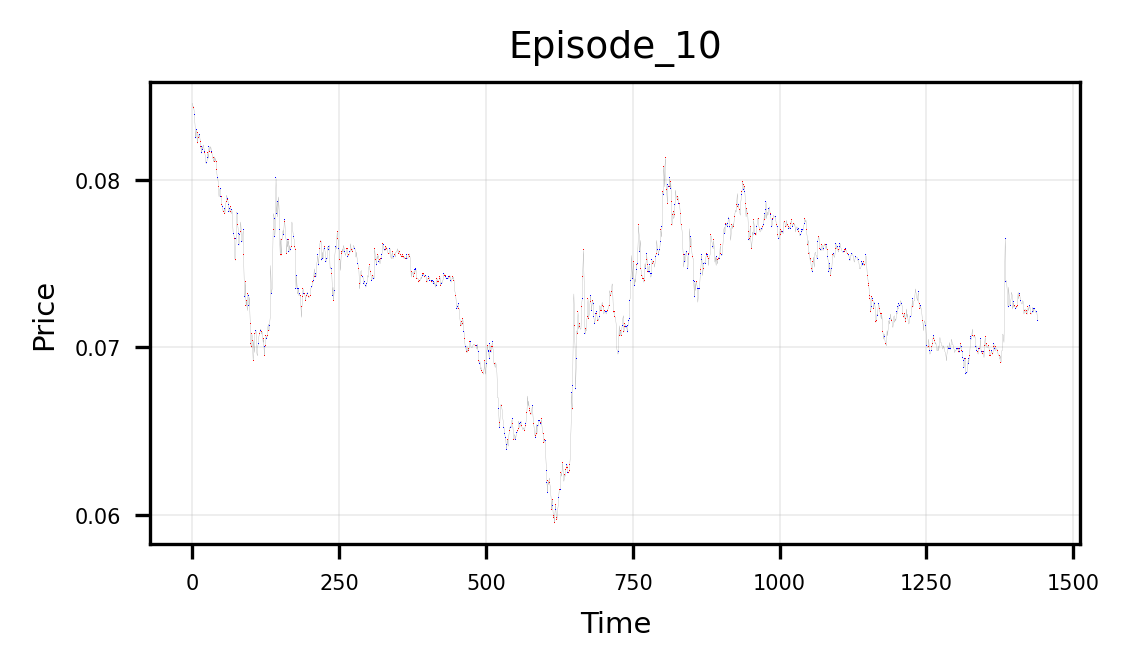

[Episode:  20] total reward: -13.9616, episode length : 1439
   cash: 71.134, coin: 23.584, total: 94.718
   sell: 438, hold: 574, buy: 427
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


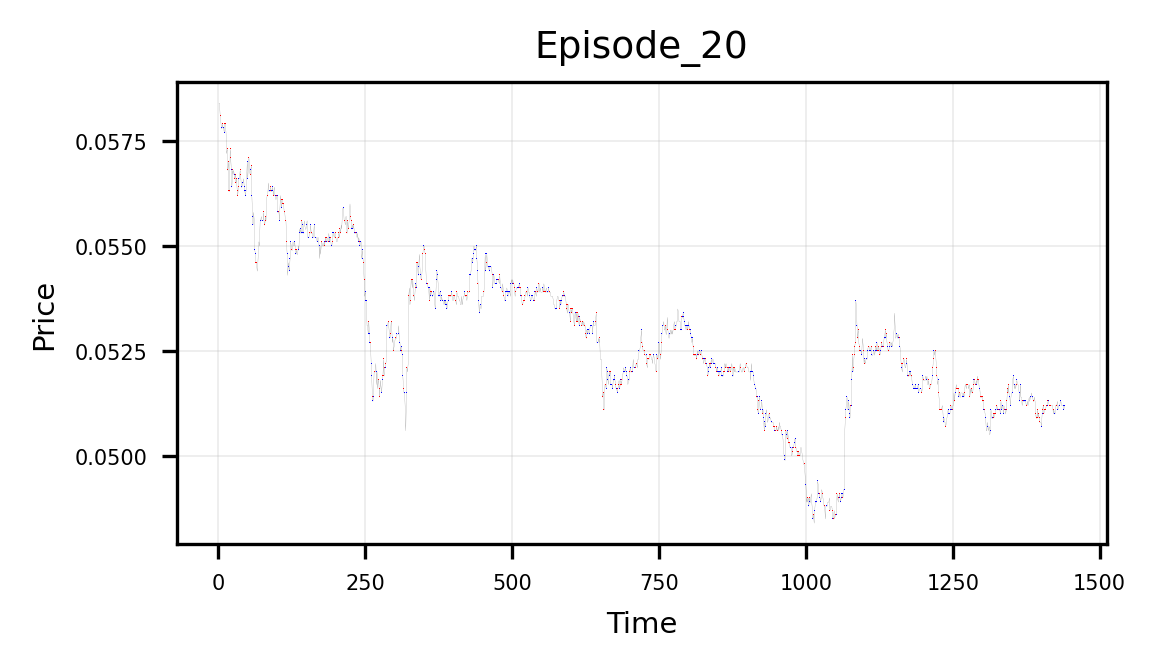

[Episode:  30] total reward: -21.8245, episode length : 1439
   cash: 46.243, coin: 39.503, total: 85.746
   sell: 372, hold: 682, buy: 385
   buffer size: 43170, epsilon: 0.4490
   time: 0.28 (min)


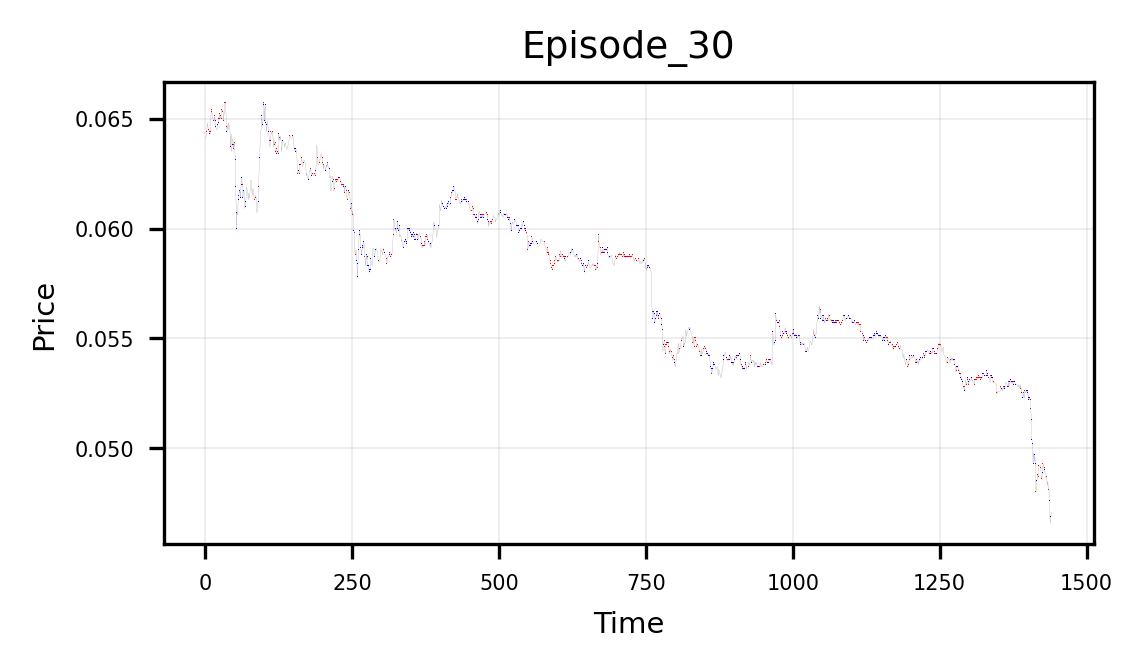

[Episode:  40] total reward: -10.5339, episode length : 1439
   cash: 85.302, coin: 11.434, total: 96.736
   sell: 362, hold: 742, buy: 335
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


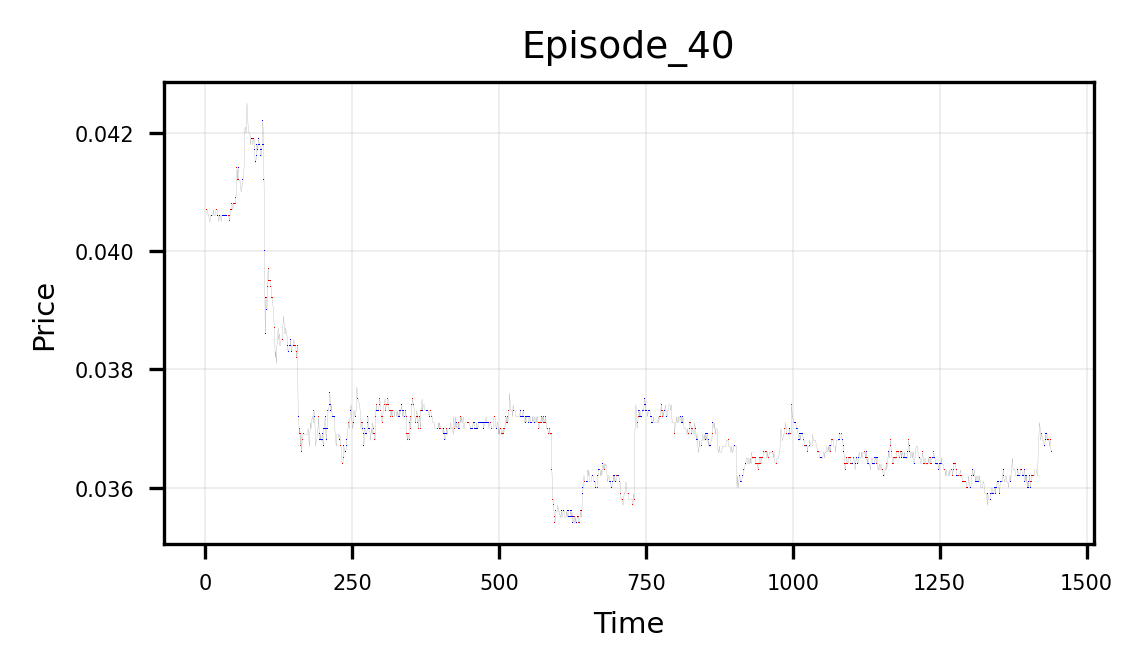

[Episode:  50] total reward: -17.5901, episode length : 1439
   cash: 22.321, coin: 67.349, total: 89.670
   sell: 320, hold: 761, buy: 358
   buffer size: 60000, epsilon: 0.0690
   time: 0.28 (min)


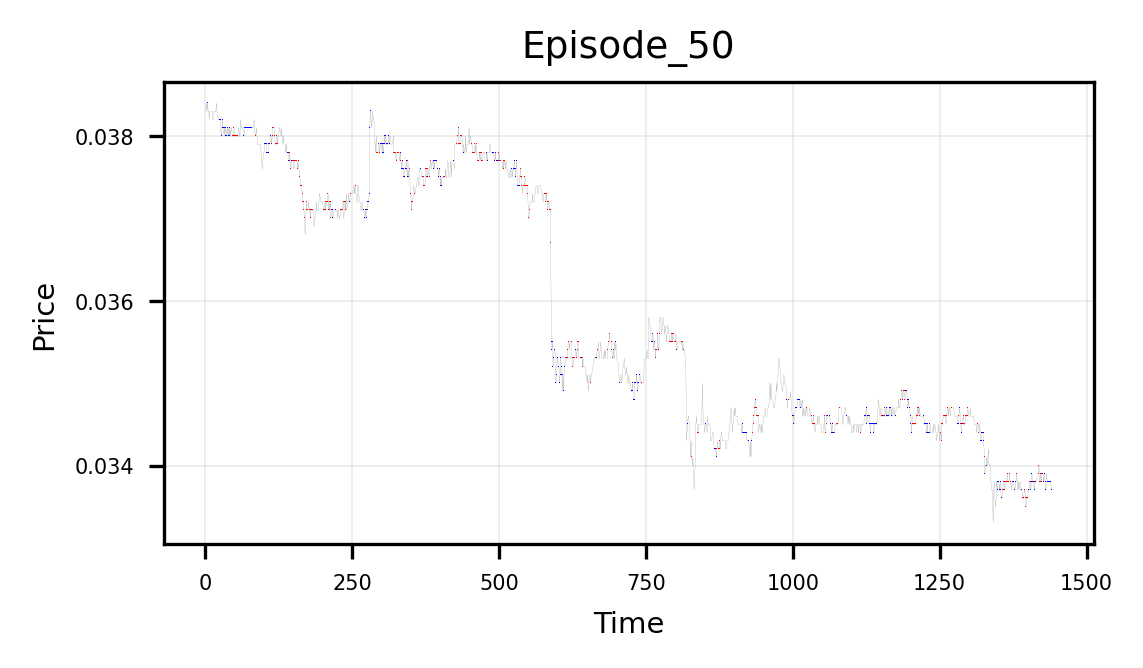

[Episode:  60] total reward: -9.2591, episode length : 1439
   cash: 26.331, coin: 71.150, total: 97.481
   sell: 318, hold: 770, buy: 351
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


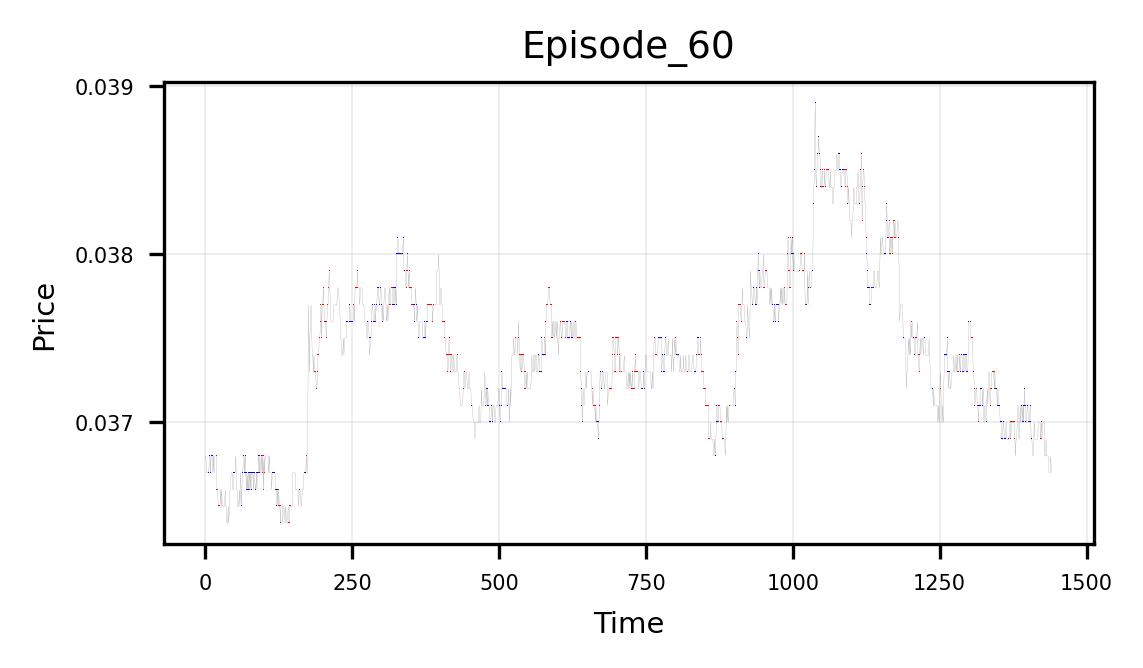

[Episode:  70] total reward: -10.2981, episode length : 1439
   cash: 56.477, coin: 39.545, total: 96.022
   sell: 260, hold: 916, buy: 263
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


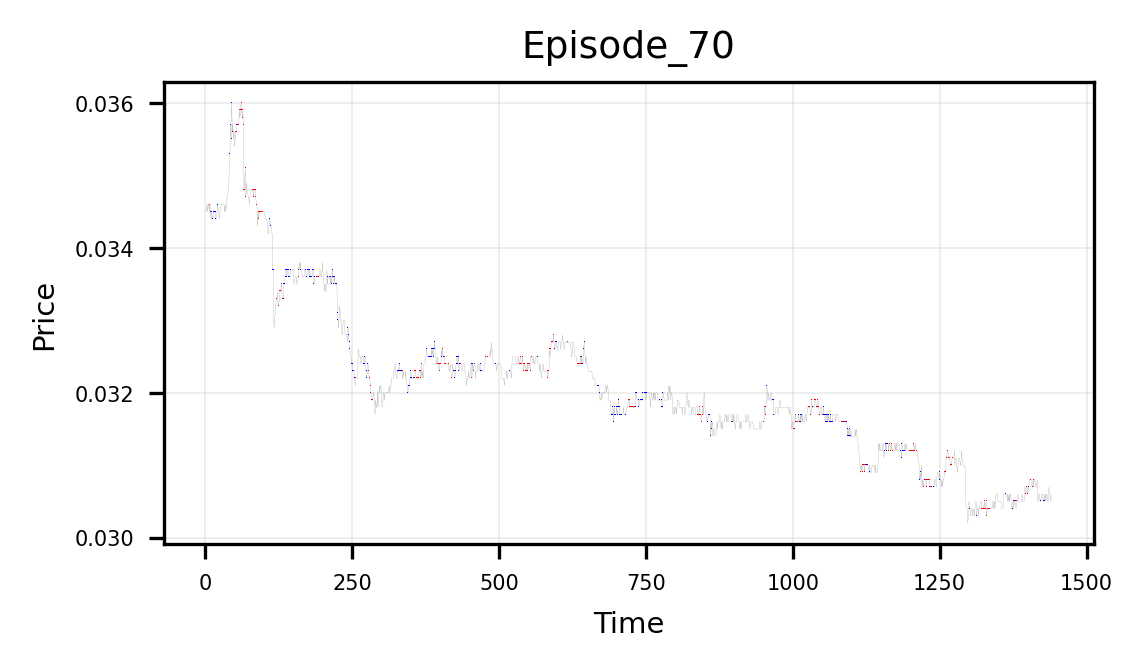

[Episode:  80] total reward: -18.6304, episode length : 1439
   cash: 21.312, coin: 67.208, total: 88.520
   sell: 325, hold: 751, buy: 363
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


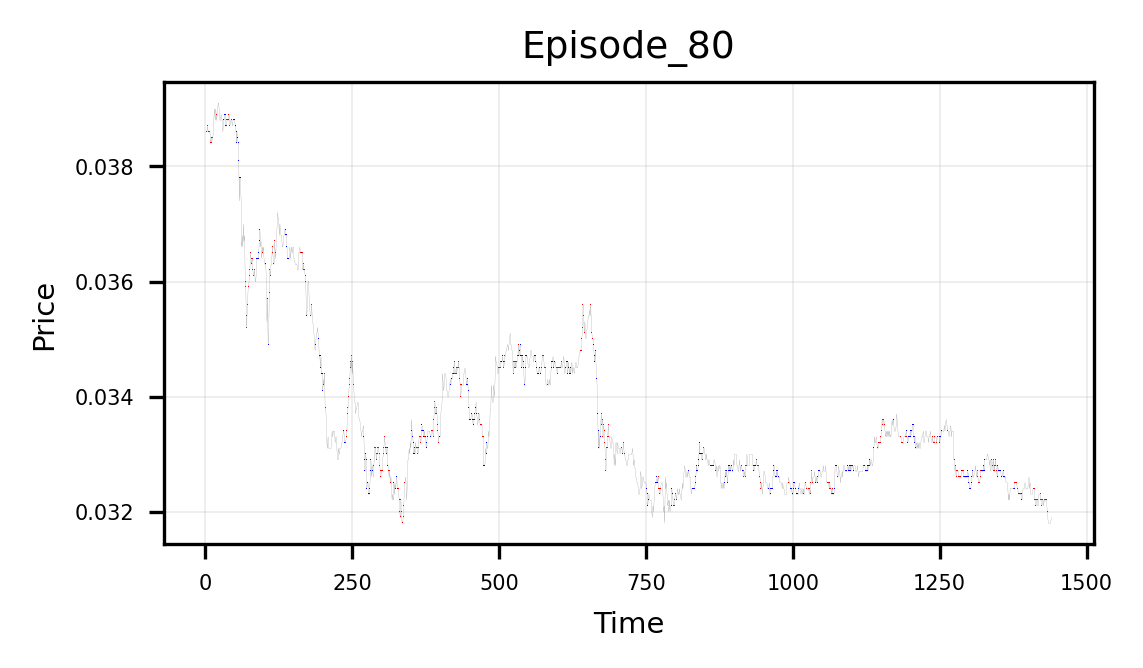

[Episode:  90] total reward: -5.0027, episode length : 1439
   cash: 4.351, coin: 97.796, total: 102.147
   sell: 297, hold: 790, buy: 352
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


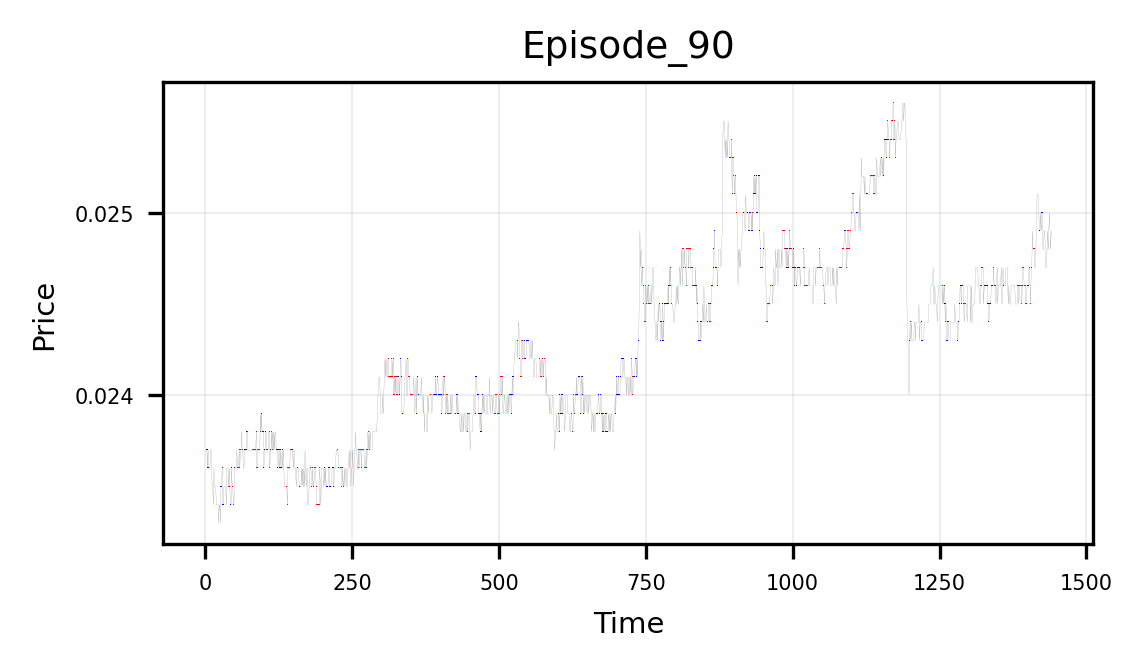

[Episode: 100] total reward: -9.4107, episode length : 1439
   cash: 74.261, coin: 23.818, total: 98.079
   sell: 377, hold: 700, buy: 362
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


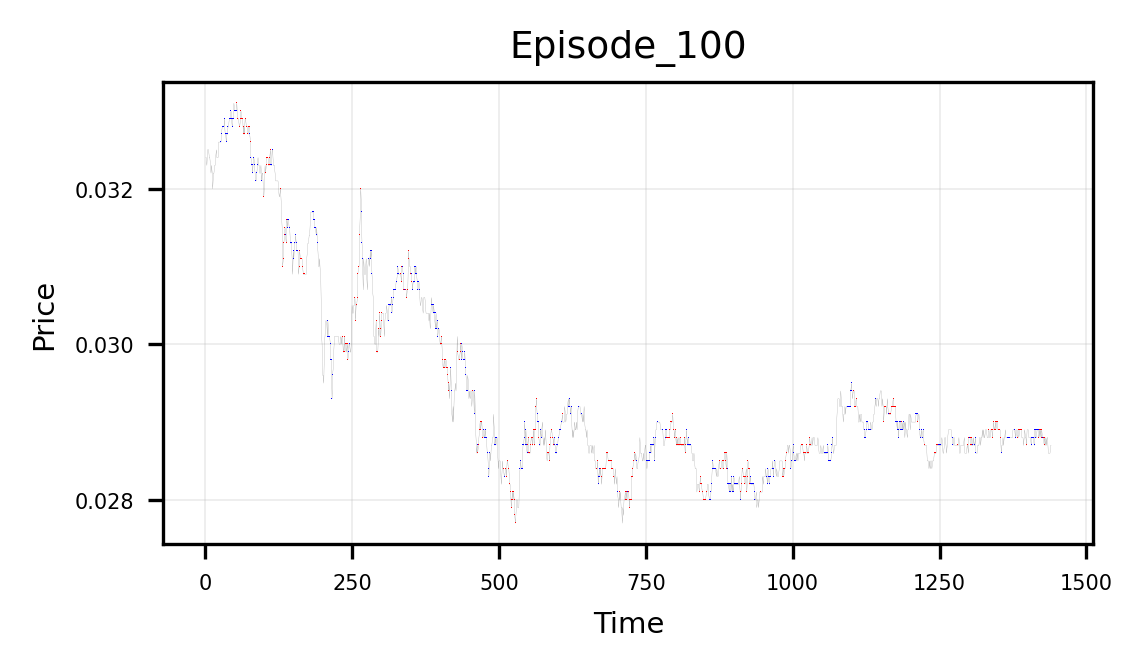

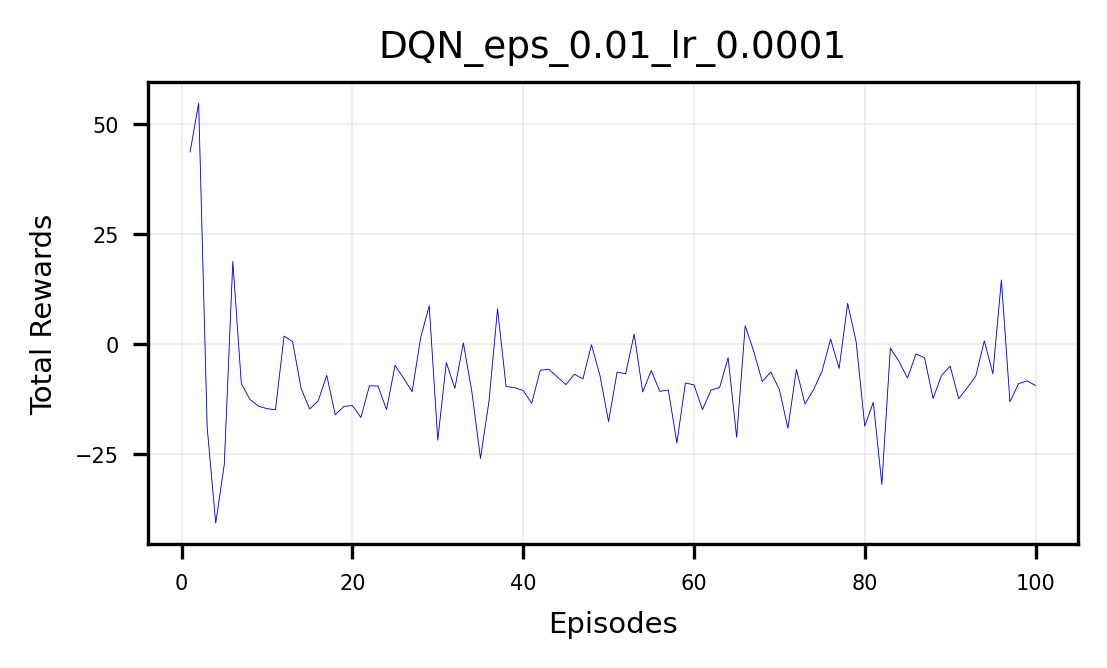

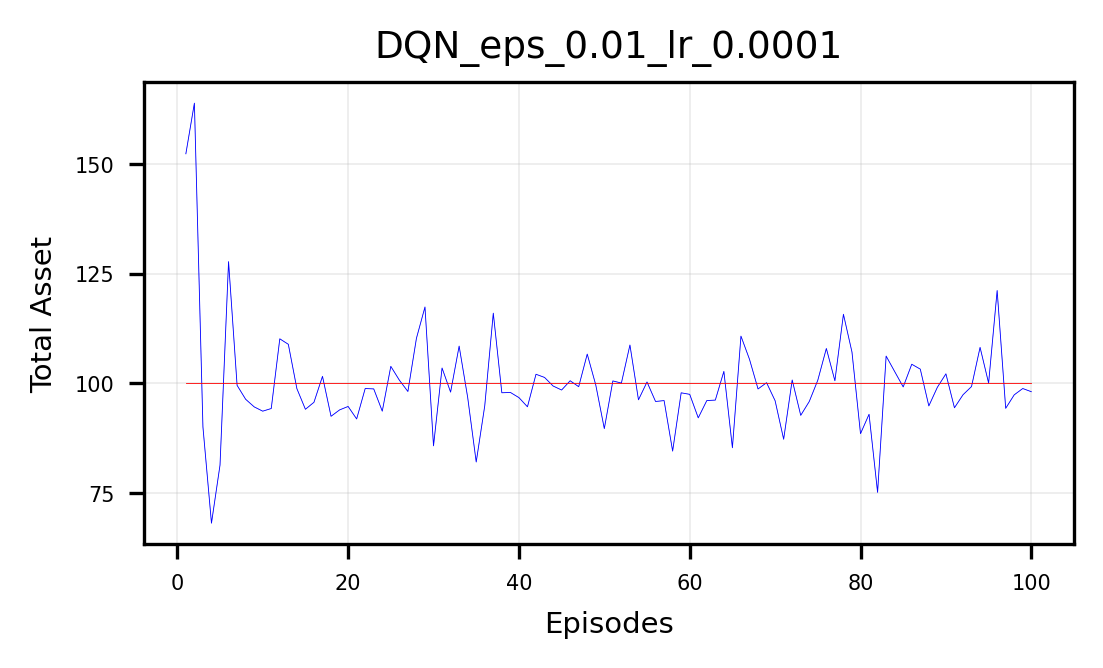

 ################ 
 lr : 1e-05  eps : 0.01 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -13.2722, episode length : 1439
   cash: 7.214, coin: 87.904, total: 95.118
   sell: 366, hold: 654, buy: 419
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


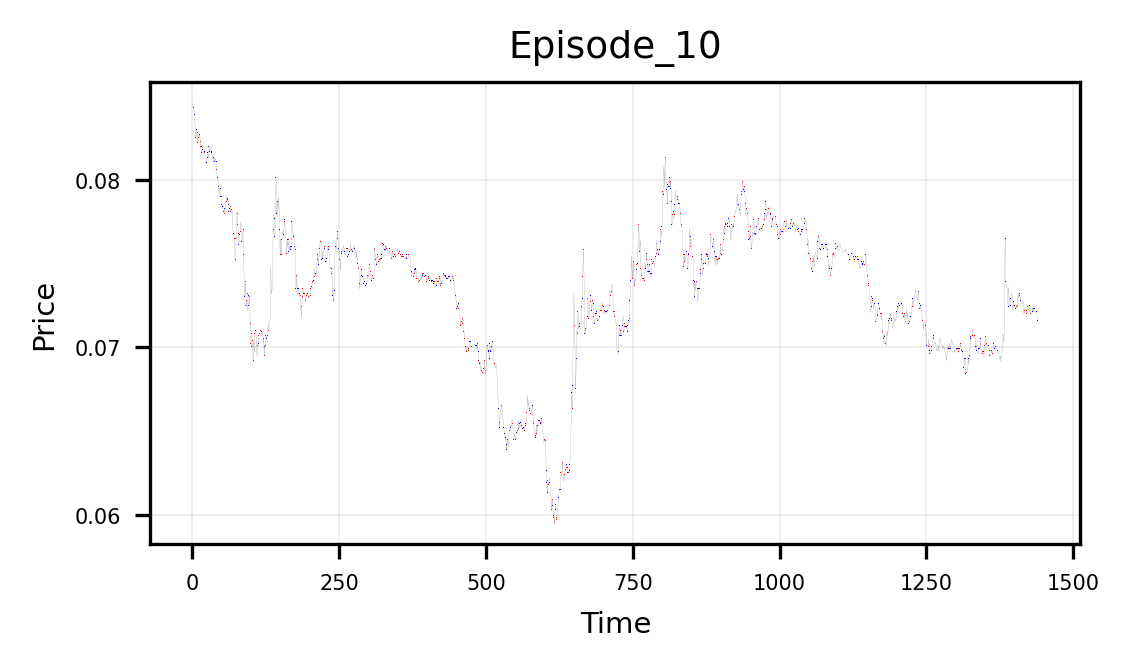

[Episode:  20] total reward: -13.3223, episode length : 1439
   cash: 4.119, coin: 91.389, total: 95.508
   sell: 412, hold: 559, buy: 468
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


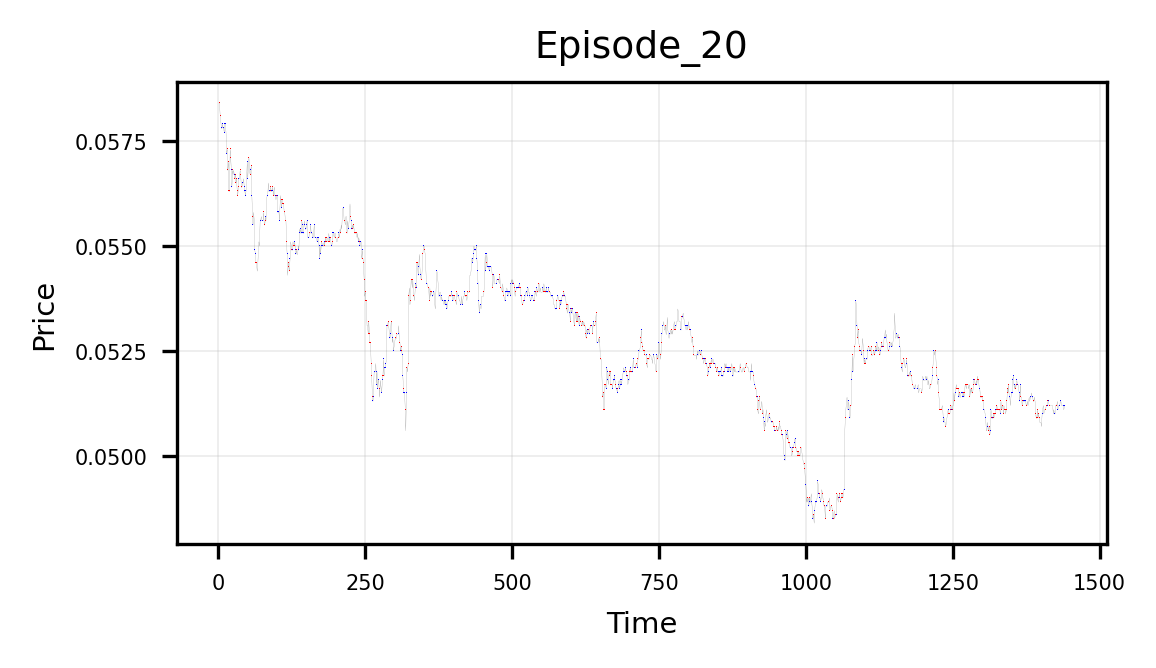

[Episode:  30] total reward: -13.7489, episode length : 1439
   cash: 76.267, coin: 17.934, total: 94.201
   sell: 375, hold: 707, buy: 357
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


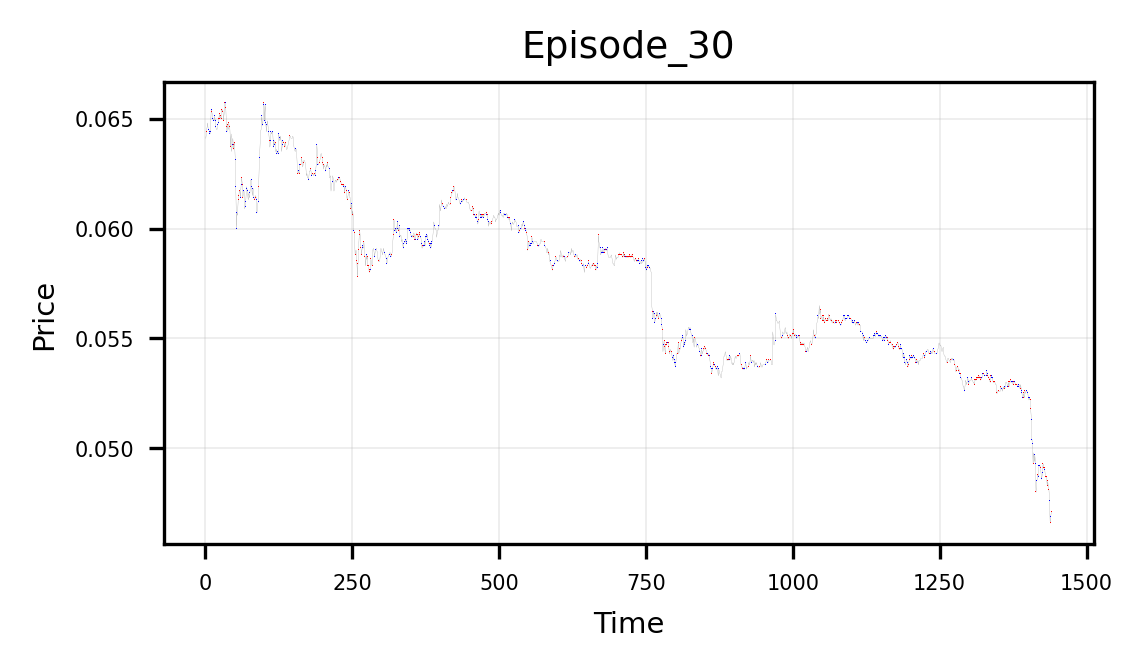

[Episode:  40] total reward: -8.9504, episode length : 1439
   cash: 84.337, coin: 13.993, total: 98.330
   sell: 344, hold: 777, buy: 318
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


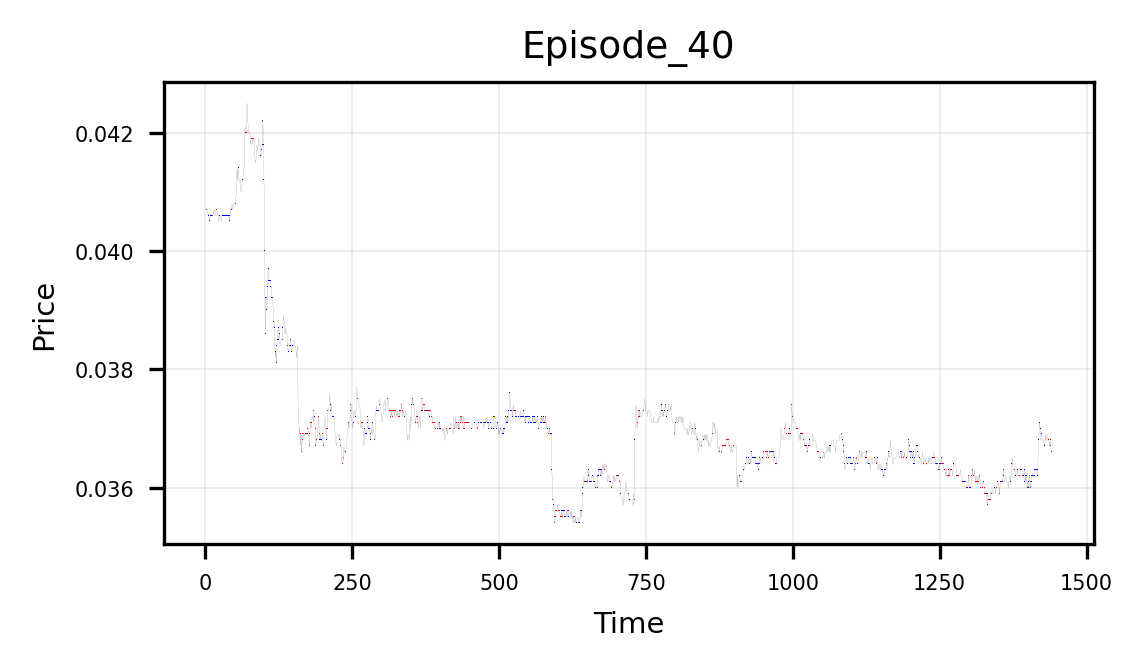

[Episode:  50] total reward: -7.2505, episode length : 1439
   cash: 40.625, coin: 56.334, total: 96.959
   sell: 178, hold: 1064, buy: 197
   buffer size: 60000, epsilon: 0.0690
   time: 0.27 (min)


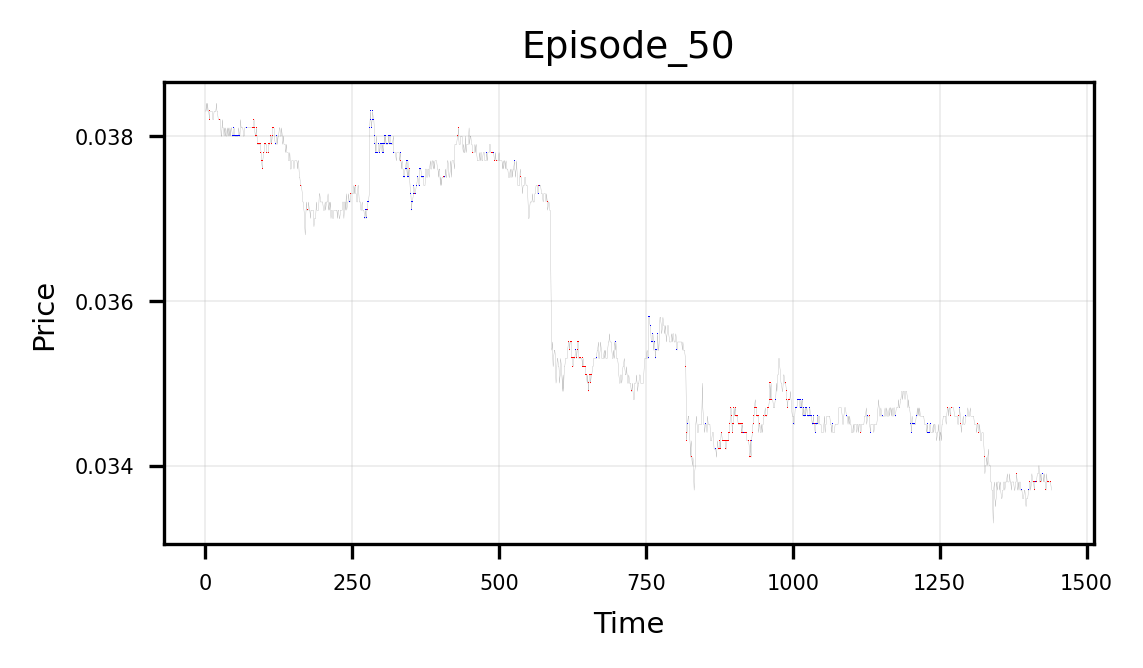

[Episode:  60] total reward: -1.4403, episode length : 1439
   cash: 98.903, coin: 1.147, total: 100.050
   sell: 68, hold: 1342, buy: 29
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


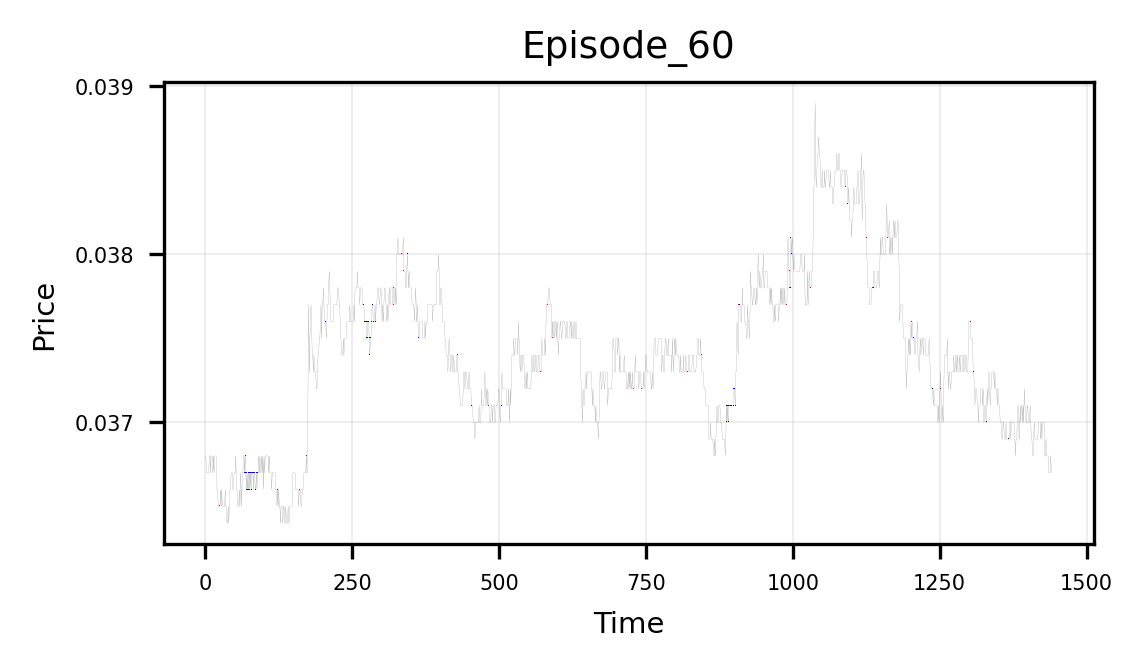

[Episode:  70] total reward: -4.9741, episode length : 1439
   cash: 97.724, coin: 0.812, total: 98.536
   sell: 157, hold: 1163, buy: 119
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


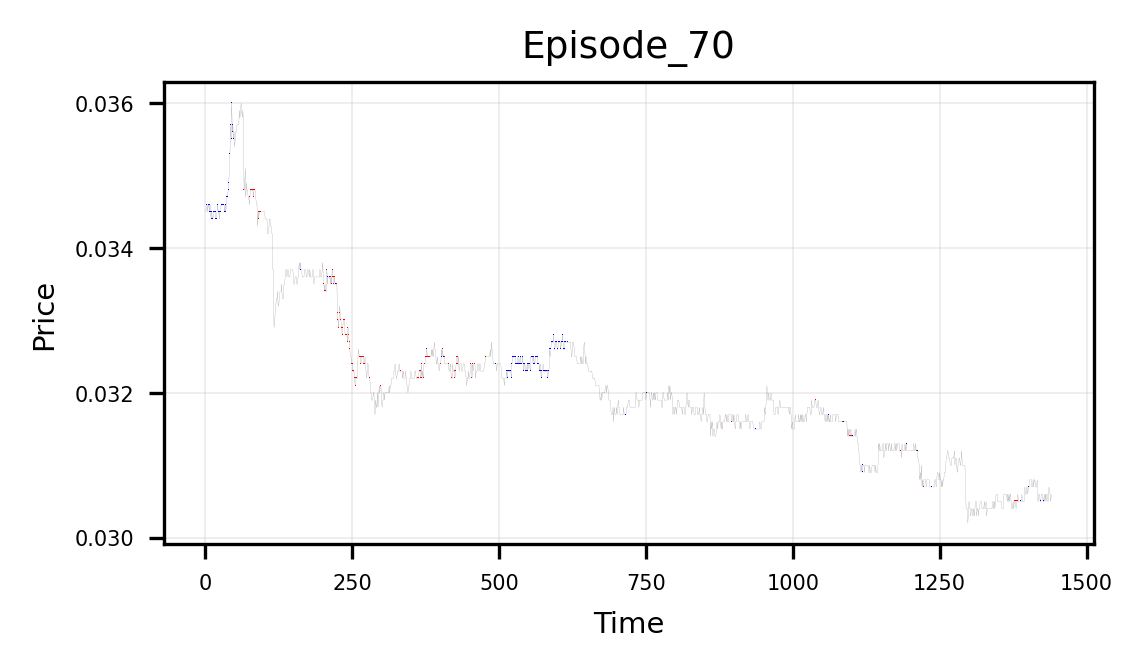

[Episode:  80] total reward: -15.8602, episode length : 1439
   cash: 86.623, coin: 1.767, total: 88.390
   sell: 202, hold: 1062, buy: 175
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


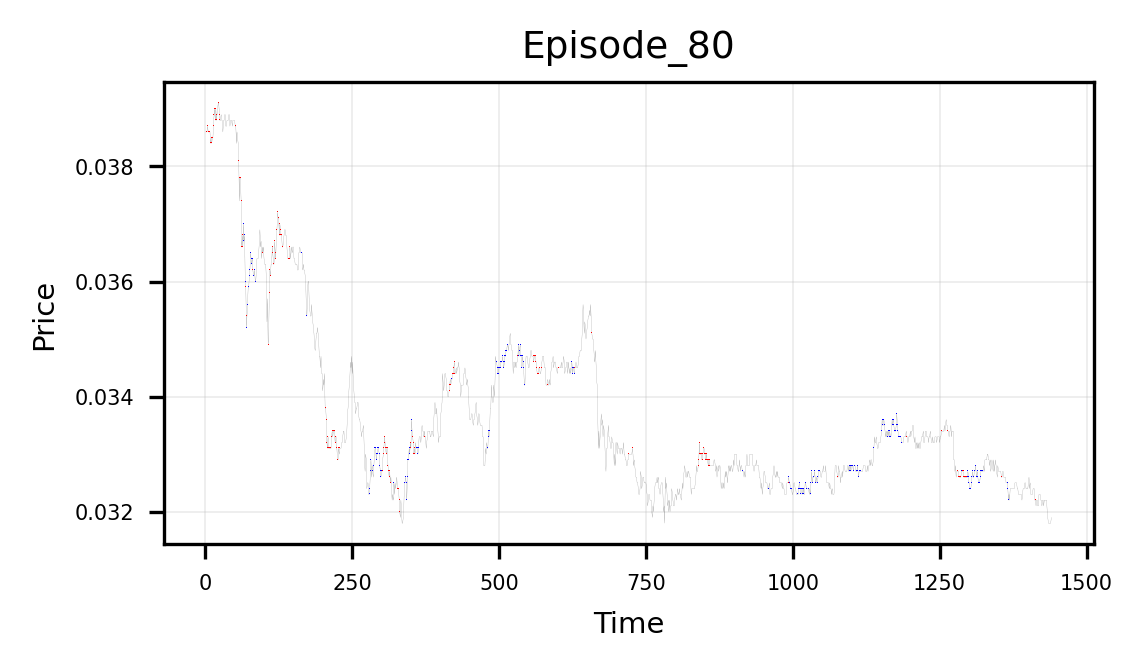

[Episode:  90] total reward: -3.8517, episode length : 1439
   cash: 93.828, coin: 5.540, total: 99.368
   sell: 103, hold: 1267, buy: 69
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


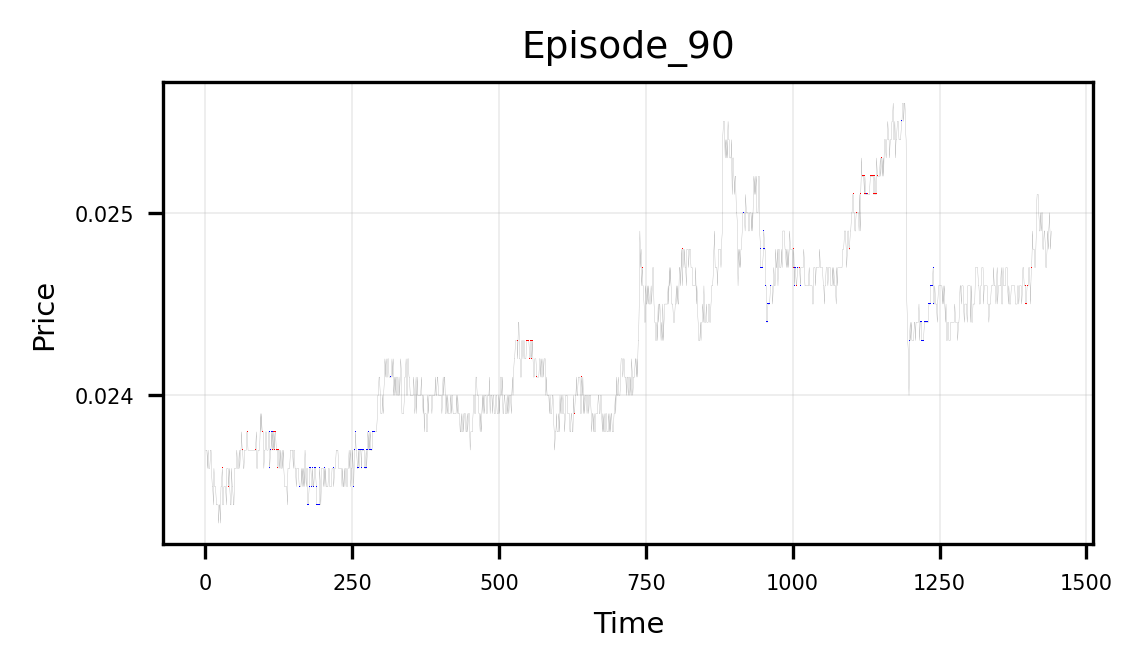

[Episode: 100] total reward: -12.4295, episode length : 1439
   cash: 12.763, coin: 77.418, total: 90.181
   sell: 95, hold: 1202, buy: 142
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


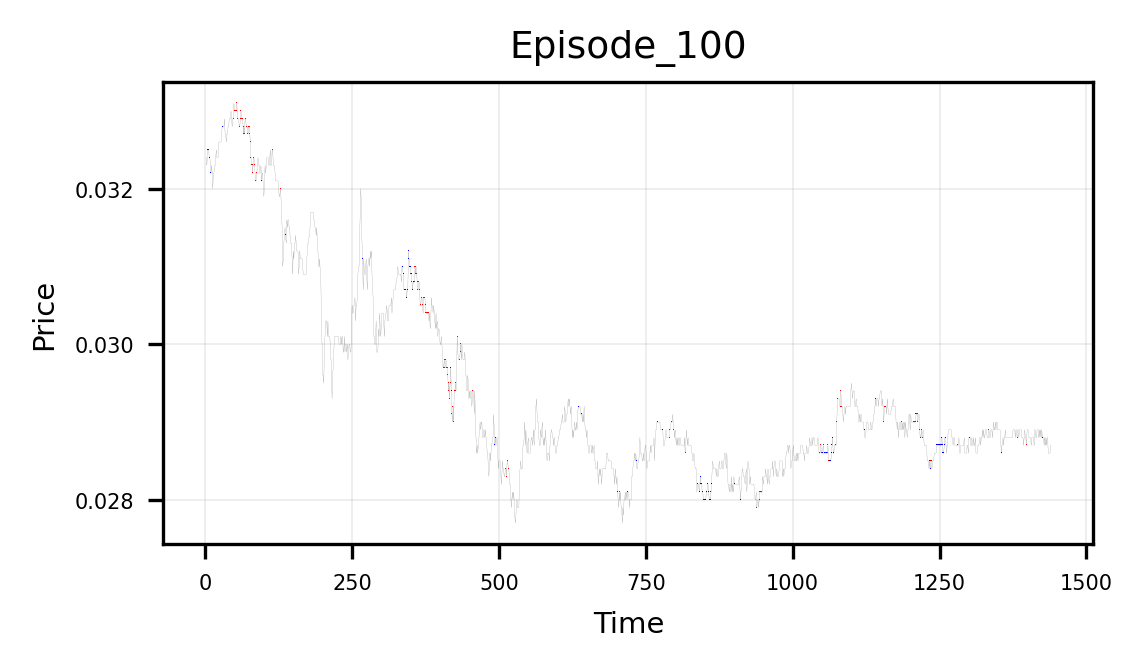

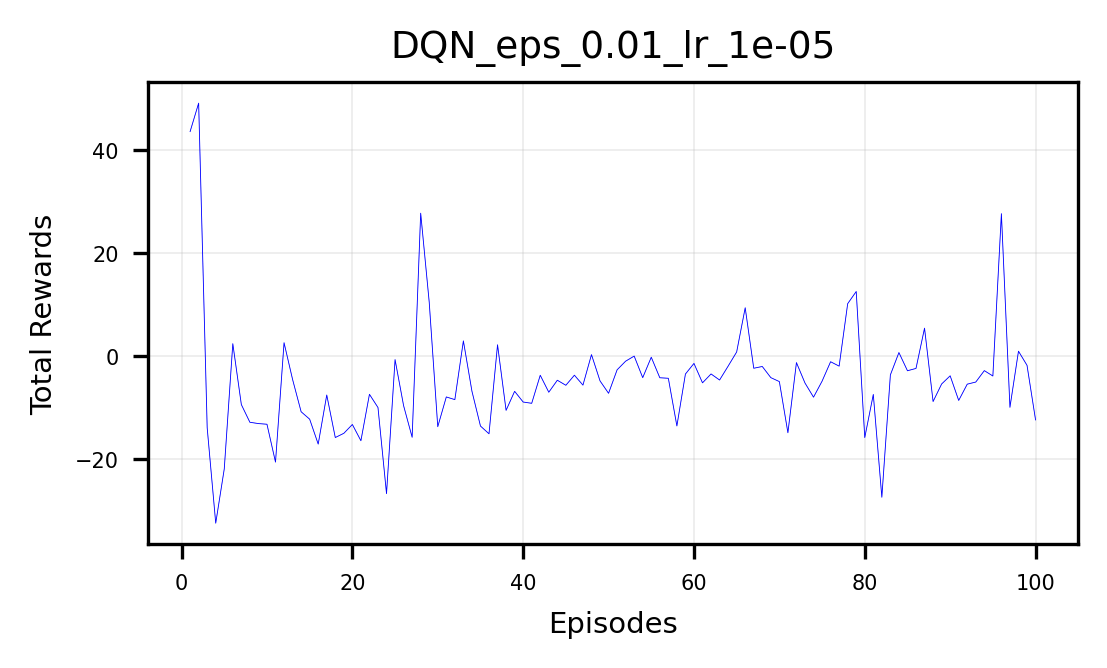

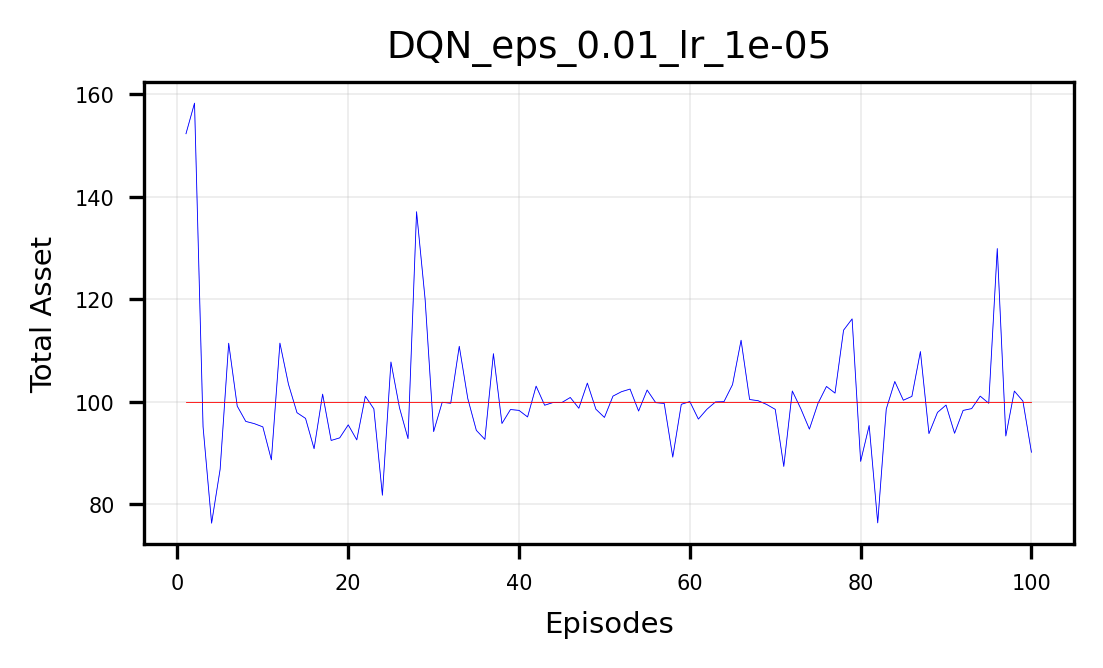

 ################ 
 lr : 1e-06  eps : 0.01 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -14.8312, episode length : 1439
   cash: 10.161, coin: 83.428, total: 93.589
   sell: 394, hold: 601, buy: 444
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


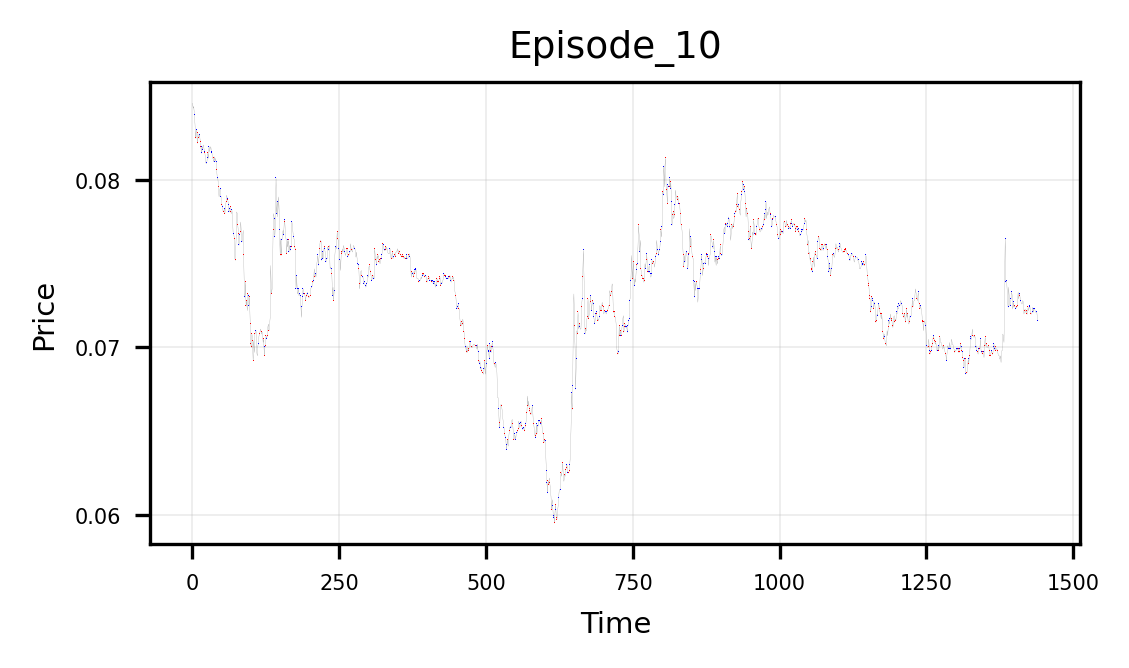

[Episode:  20] total reward: -12.2064, episode length : 1439
   cash: 86.145, coin: 10.279, total: 96.424
   sell: 440, hold: 585, buy: 414
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


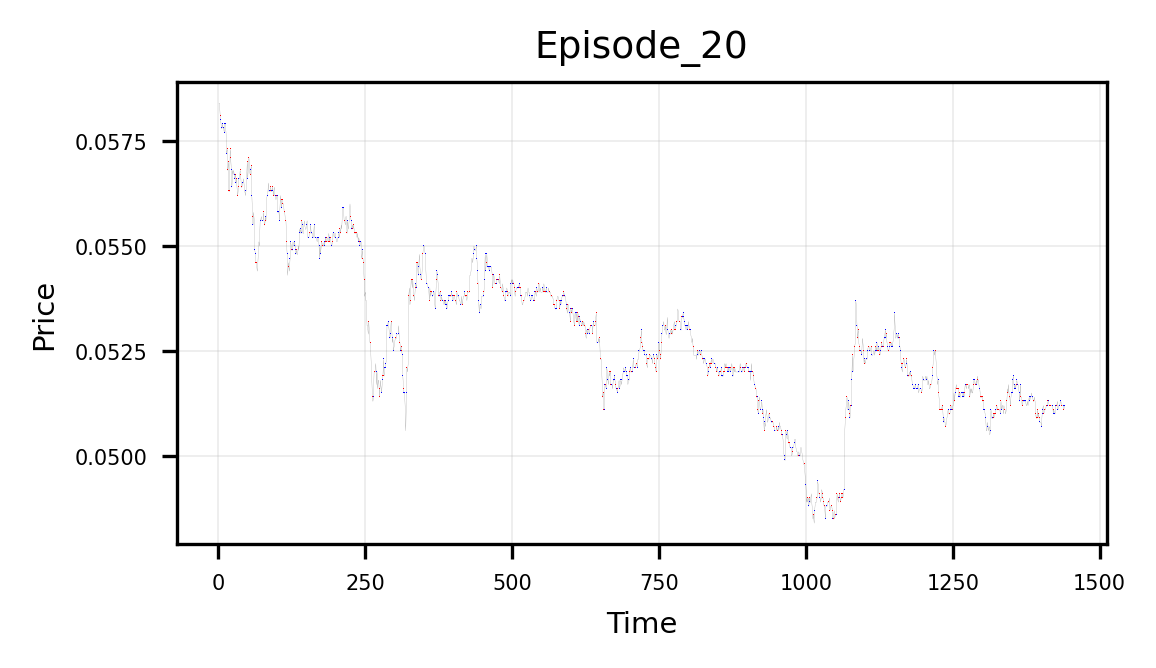

[Episode:  30] total reward: -19.1470, episode length : 1439
   cash: 70.149, coin: 19.214, total: 89.363
   sell: 431, hold: 589, buy: 419
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


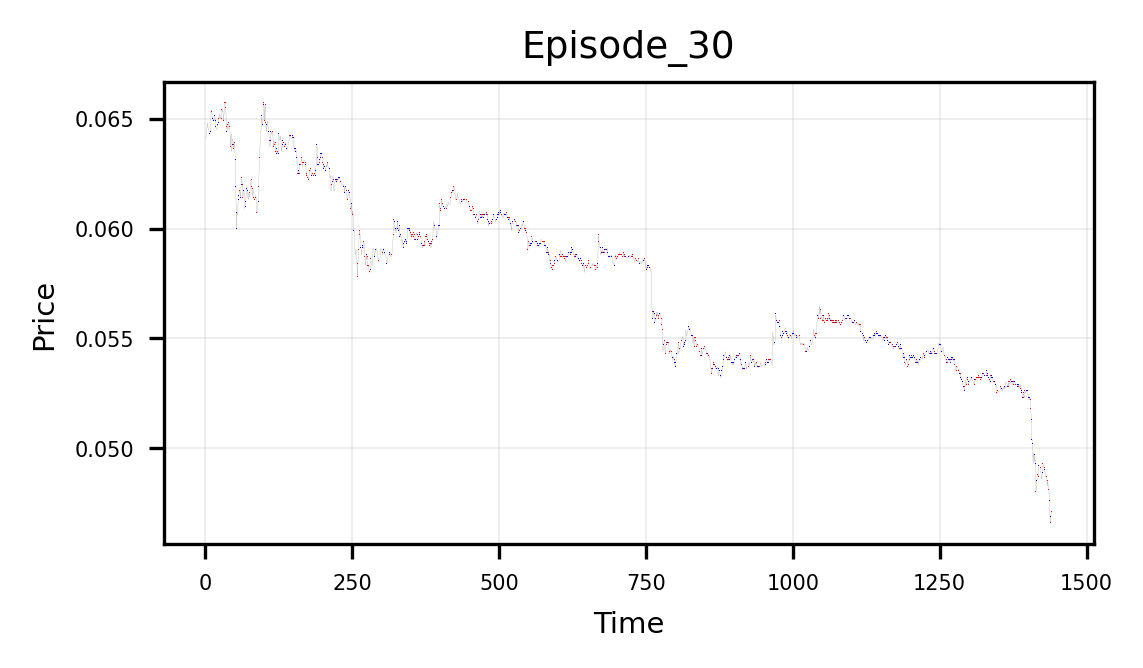

[Episode:  40] total reward: -9.1552, episode length : 1439
   cash: 70.347, coin: 27.508, total: 97.855
   sell: 332, hold: 787, buy: 320
   buffer size: 57560, epsilon: 0.2590
   time: 0.27 (min)


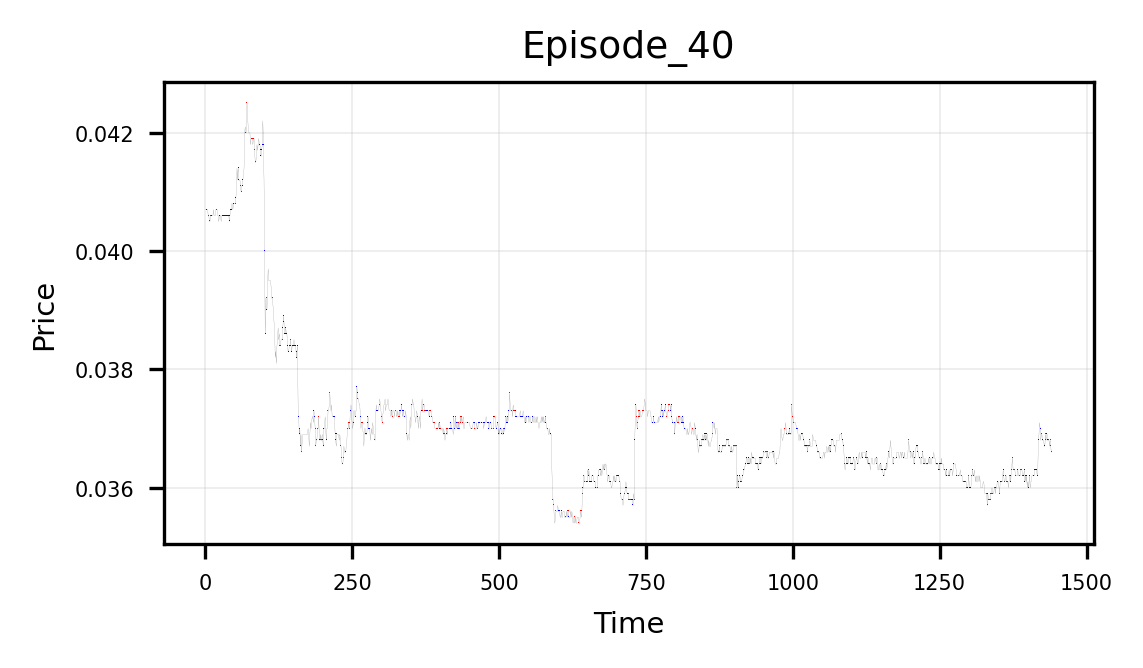

[Episode:  50] total reward: -12.4357, episode length : 1439
   cash: 26.341, coin: 67.813, total: 94.154
   sell: 313, hold: 780, buy: 346
   buffer size: 60000, epsilon: 0.0690
   time: 0.29 (min)


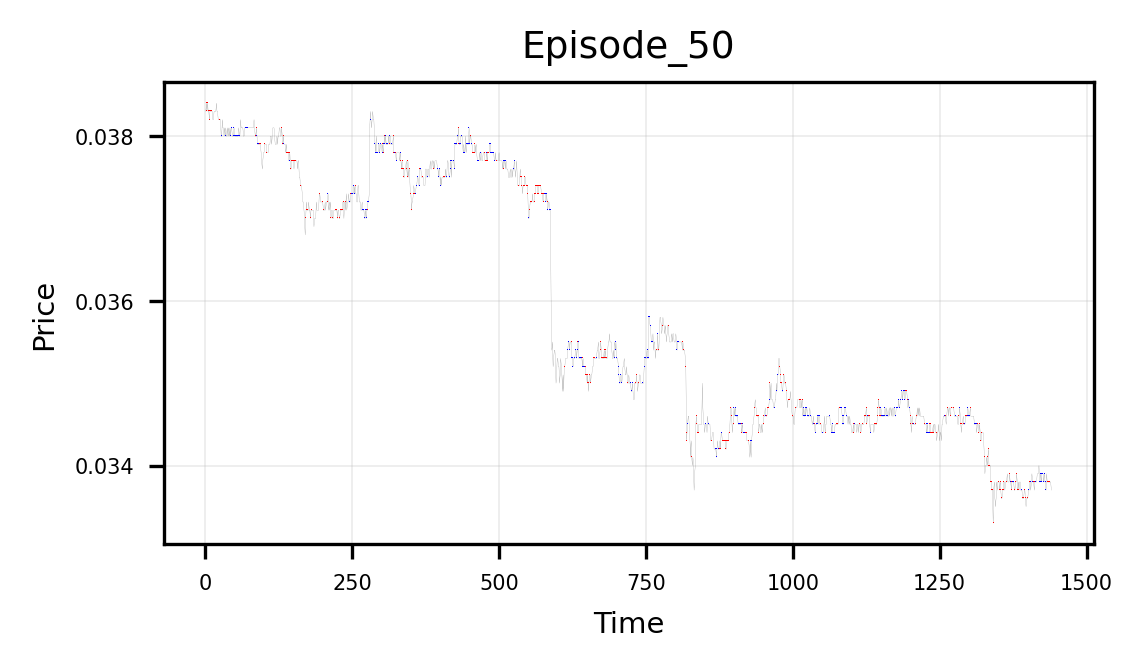

[Episode:  60] total reward: -7.1972, episode length : 1439
   cash: 14.459, coin: 83.794, total: 98.253
   sell: 248, hold: 898, buy: 293
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


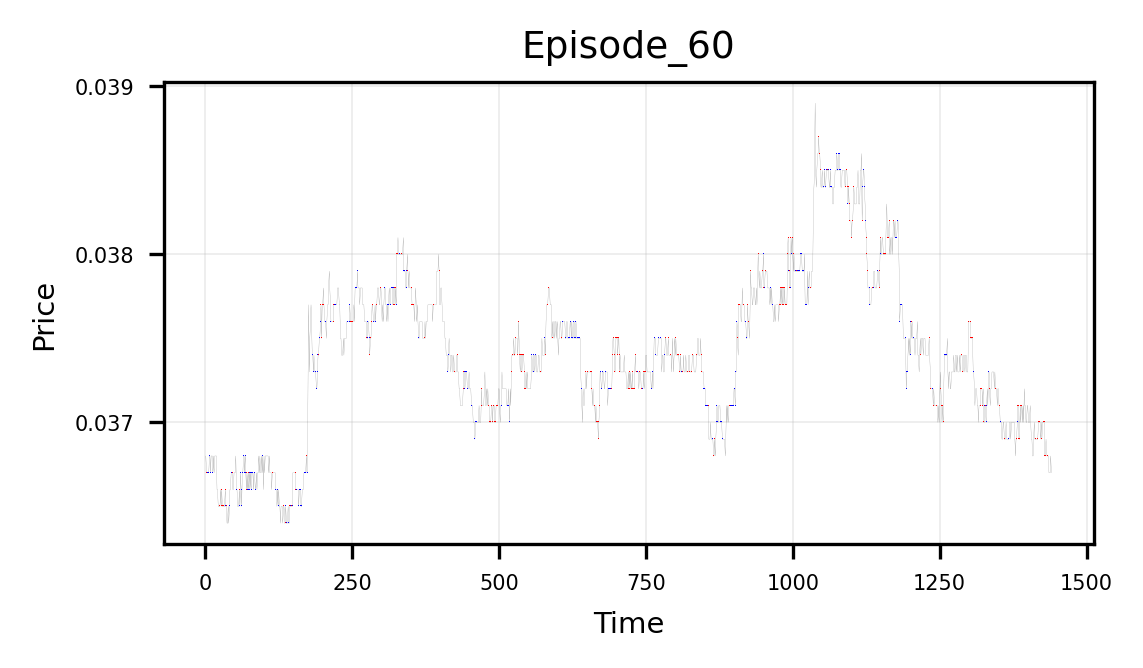

[Episode:  70] total reward: -8.7976, episode length : 1439
   cash: 93.582, coin: 3.070, total: 96.652
   sell: 226, hold: 1022, buy: 191
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


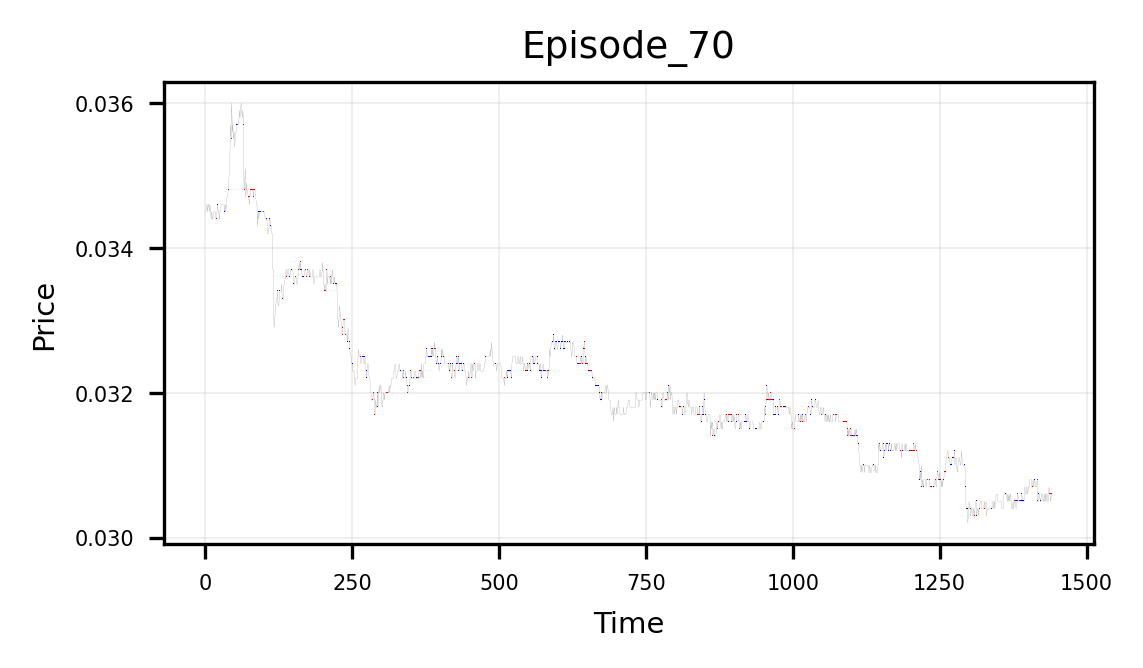

[Episode:  80] total reward: -11.4921, episode length : 1439
   cash: 0.585, coin: 92.673, total: 93.258
   sell: 178, hold: 1024, buy: 237
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


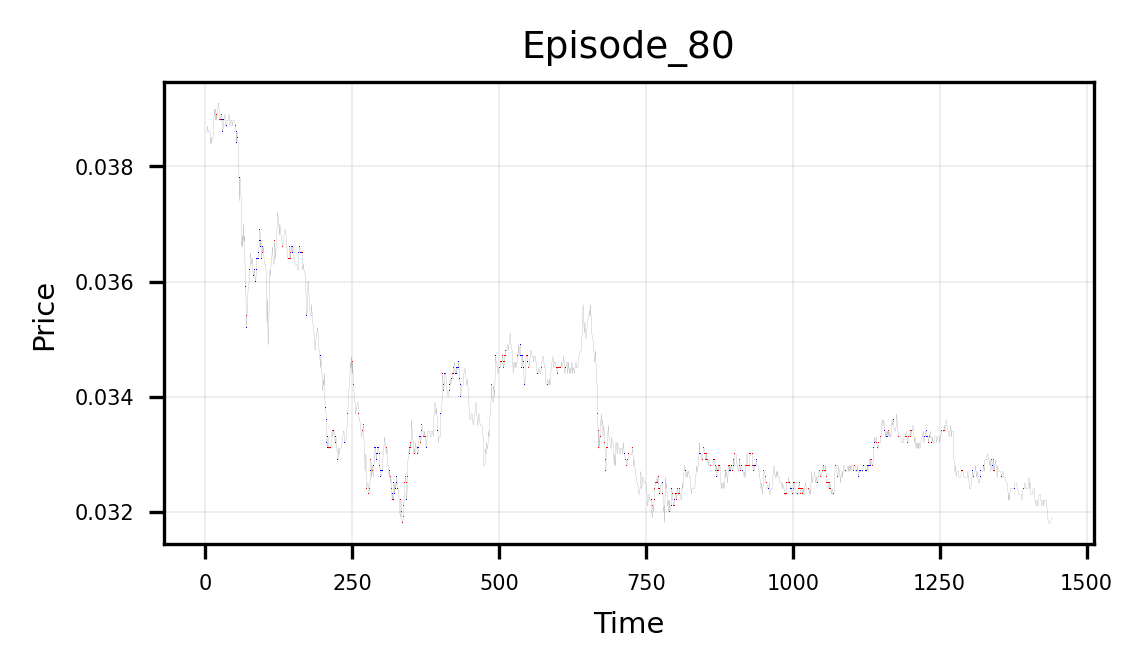

[Episode:  90] total reward: -0.0470, episode length : 1439
   cash: 23.650, coin: 80.373, total: 104.023
   sell: 157, hold: 1089, buy: 193
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


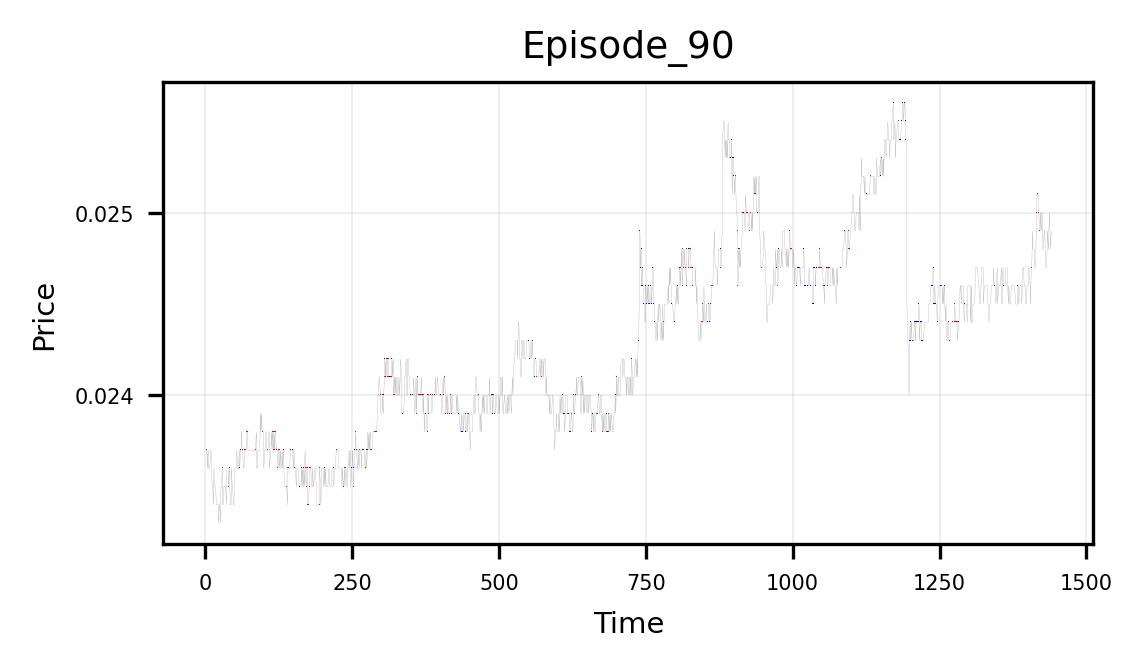

[Episode: 100] total reward: -12.8043, episode length : 1439
   cash: 0.567, coin: 92.379, total: 92.946
   sell: 187, hold: 1006, buy: 246
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


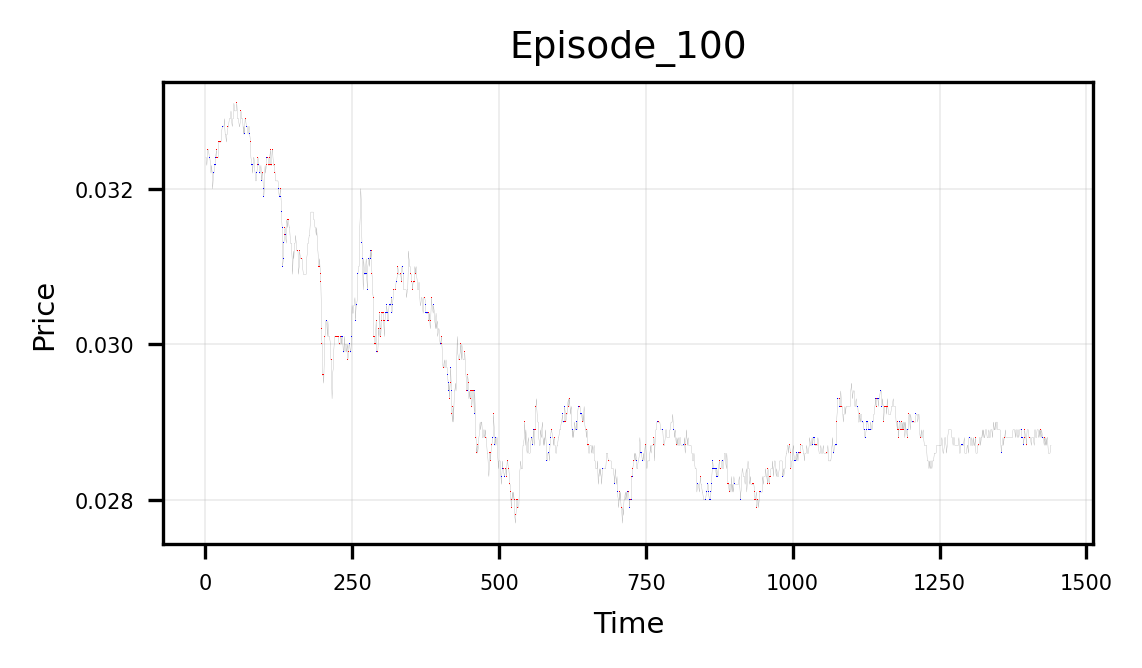

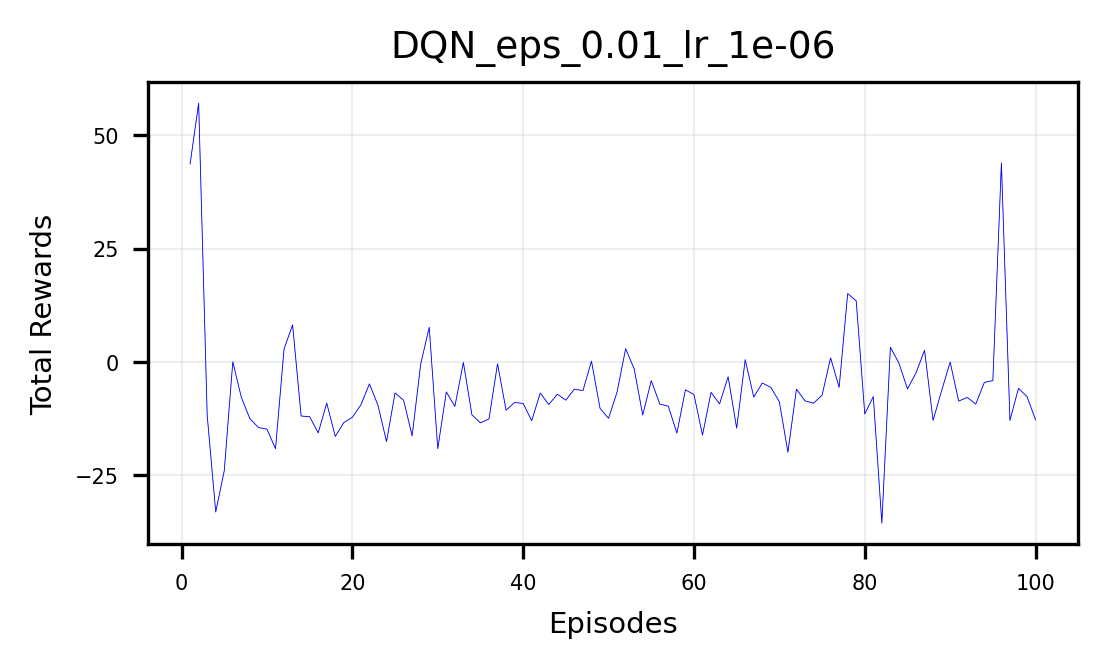

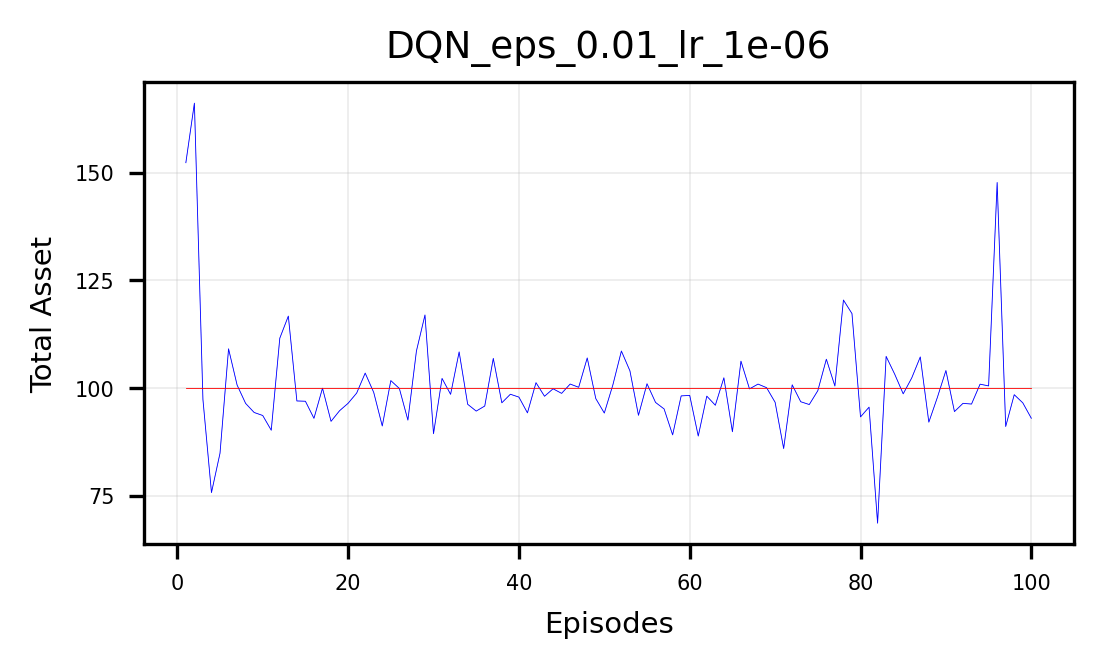

 ################ 
 lr : 0.0001  eps : 0.001 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -7.7228, episode length : 1439
   cash: 6.185, coin: 86.934, total: 93.119
   sell: 380, hold: 625, buy: 434
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


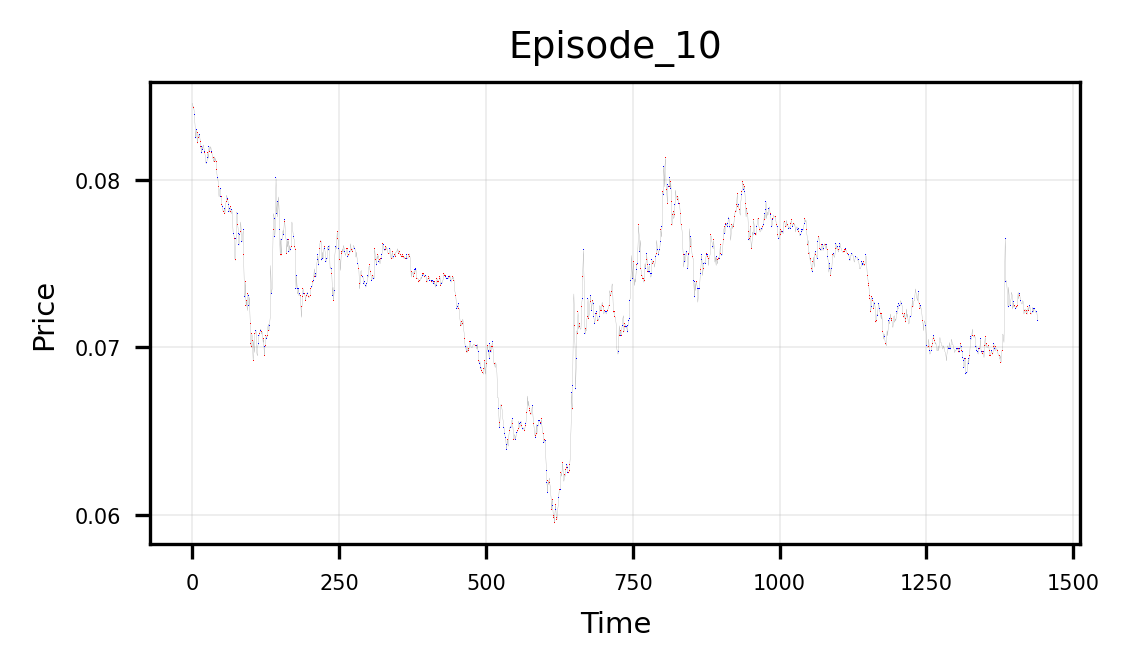

[Episode:  20] total reward: -6.3000, episode length : 1439
   cash: 94.123, coin: 0.465, total: 94.588
   sell: 456, hold: 562, buy: 421
   buffer size: 28780, epsilon: 0.6390
   time: 0.28 (min)


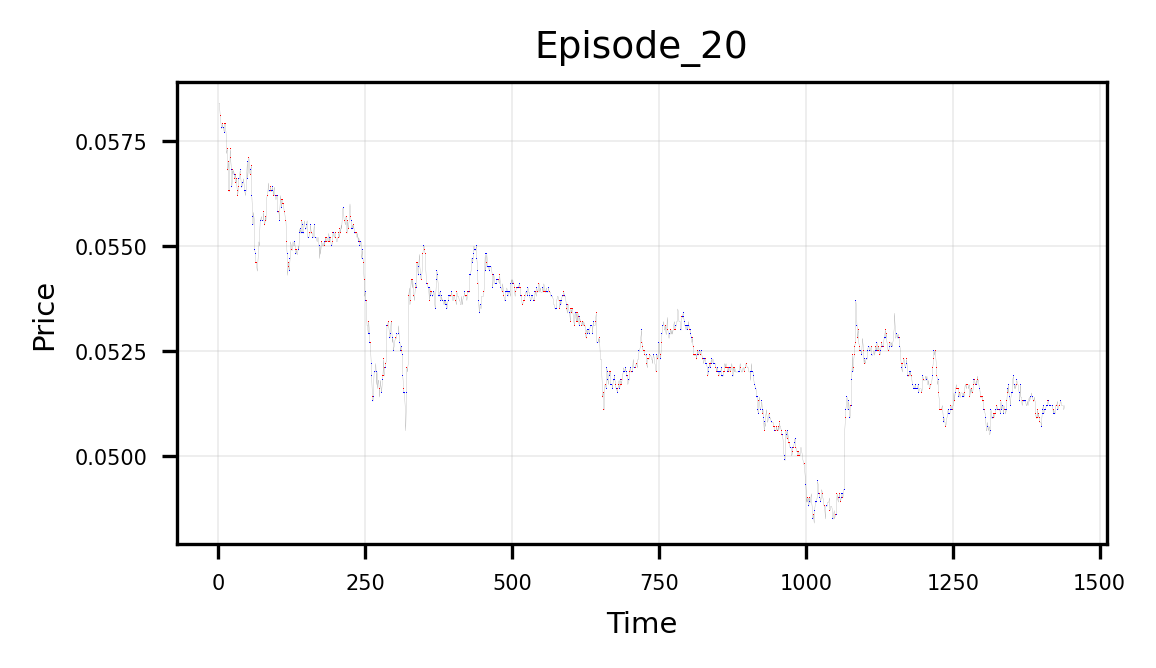

[Episode:  30] total reward: -10.4837, episode length : 1439
   cash: 67.230, coin: 23.075, total: 90.305
   sell: 389, hold: 669, buy: 381
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


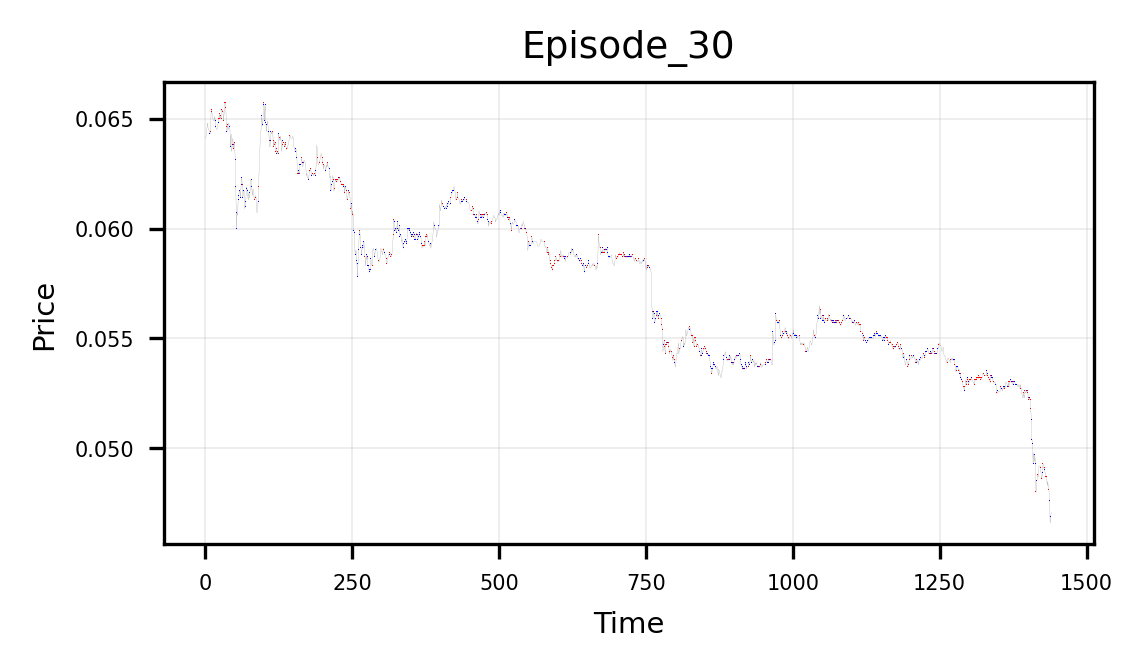

[Episode:  40] total reward: -4.6605, episode length : 1439
   cash: 77.194, coin: 18.971, total: 96.165
   sell: 412, hold: 634, buy: 393
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


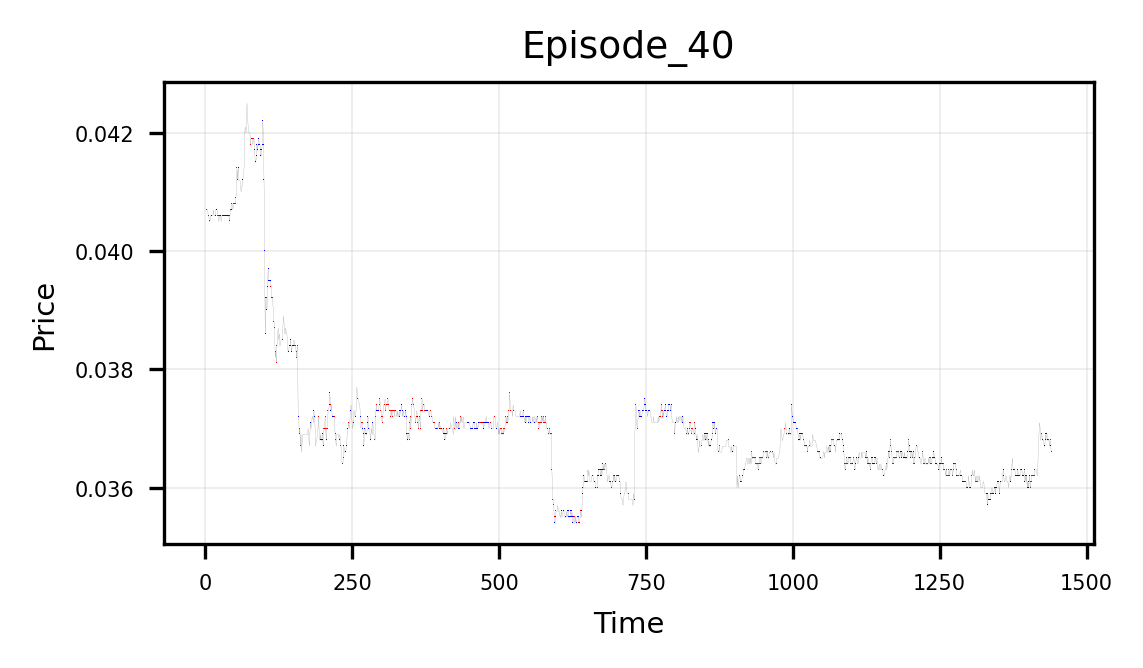

[Episode:  50] total reward: -6.1185, episode length : 1439
   cash: 72.157, coin: 22.567, total: 94.724
   sell: 427, hold: 597, buy: 415
   buffer size: 60000, epsilon: 0.0690
   time: 0.27 (min)


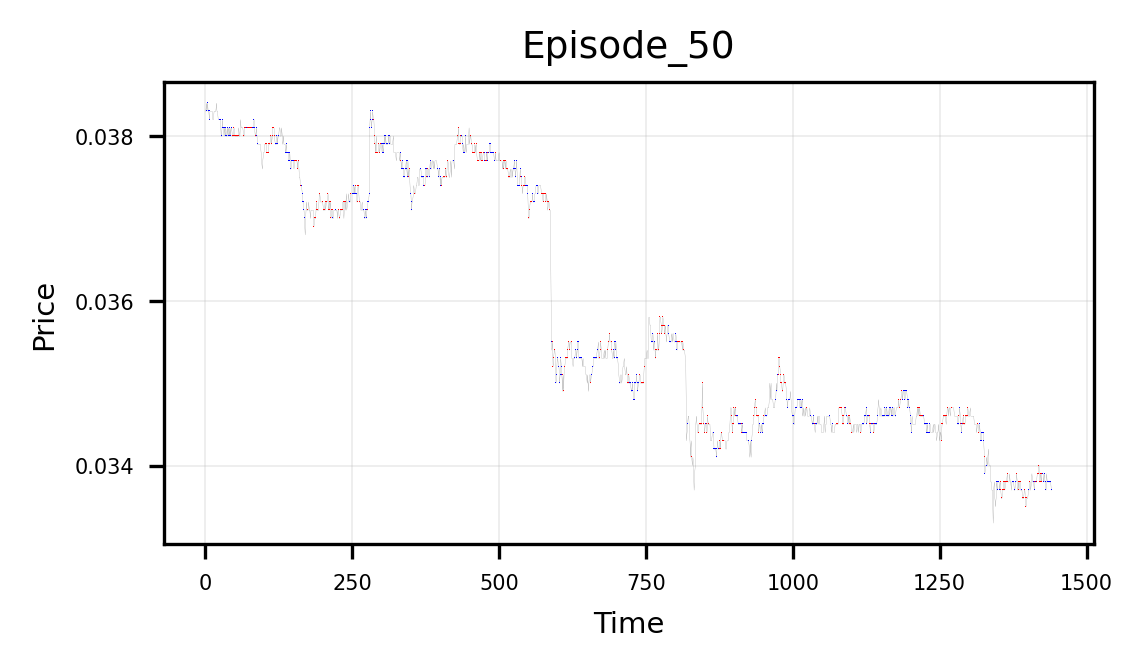

[Episode:  60] total reward: -3.0325, episode length : 1439
   cash: 37.222, coin: 60.523, total: 97.745
   sell: 378, hold: 662, buy: 399
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


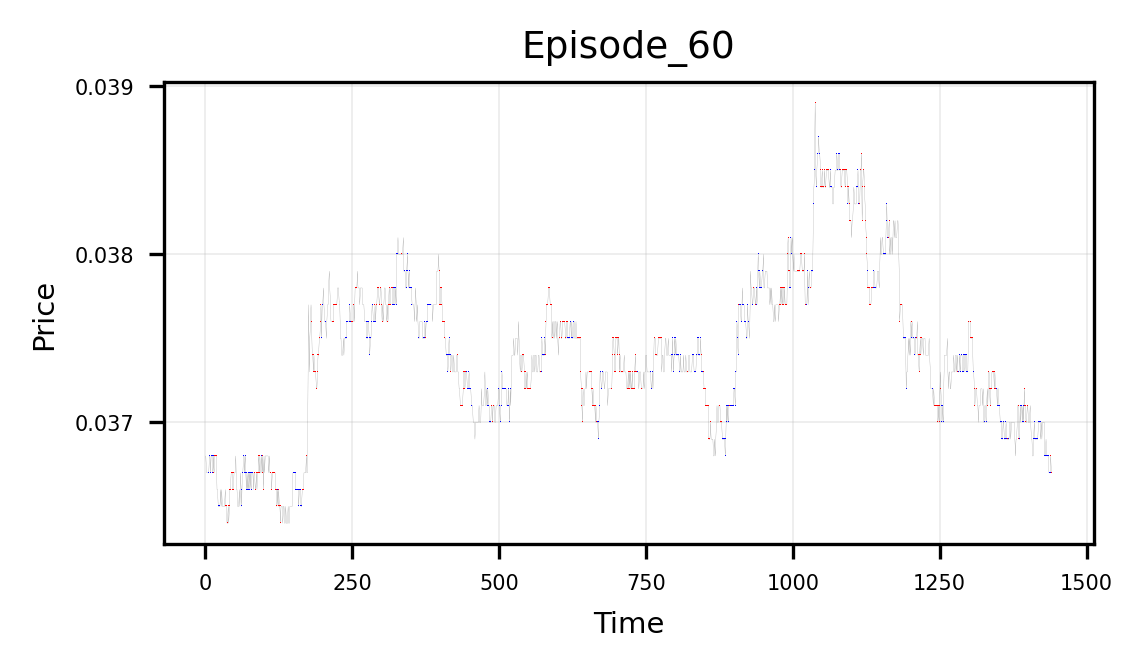

[Episode:  70] total reward: -7.3454, episode length : 1439
   cash: 29.222, coin: 64.211, total: 93.433
   sell: 373, hold: 662, buy: 404
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


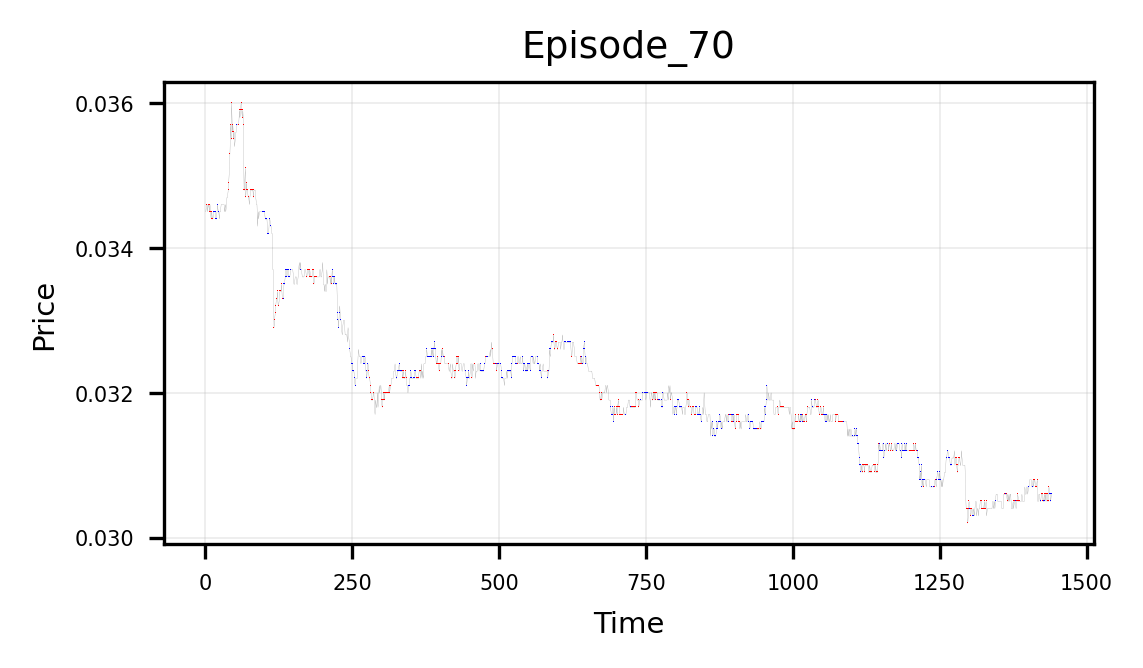

[Episode:  80] total reward: -15.7553, episode length : 1439
   cash: 14.221, coin: 70.873, total: 85.094
   sell: 367, hold: 660, buy: 412
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


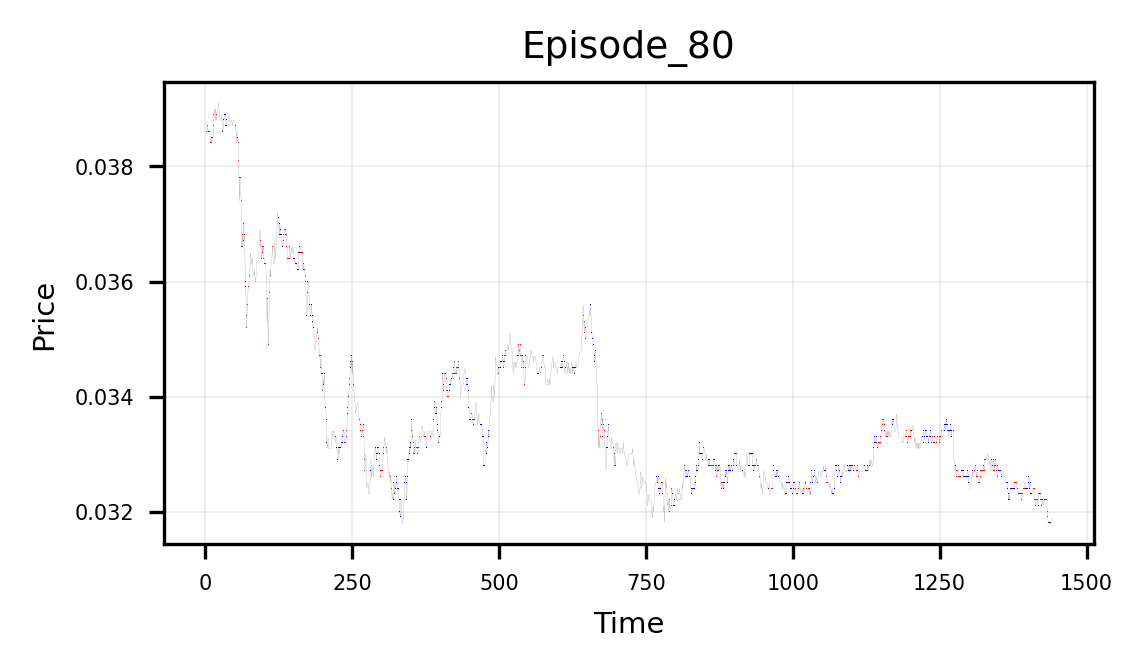

[Episode:  90] total reward: 3.2252, episode length : 1439
   cash: 10.219, coin: 93.913, total: 104.132
   sell: 366, hold: 658, buy: 415
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


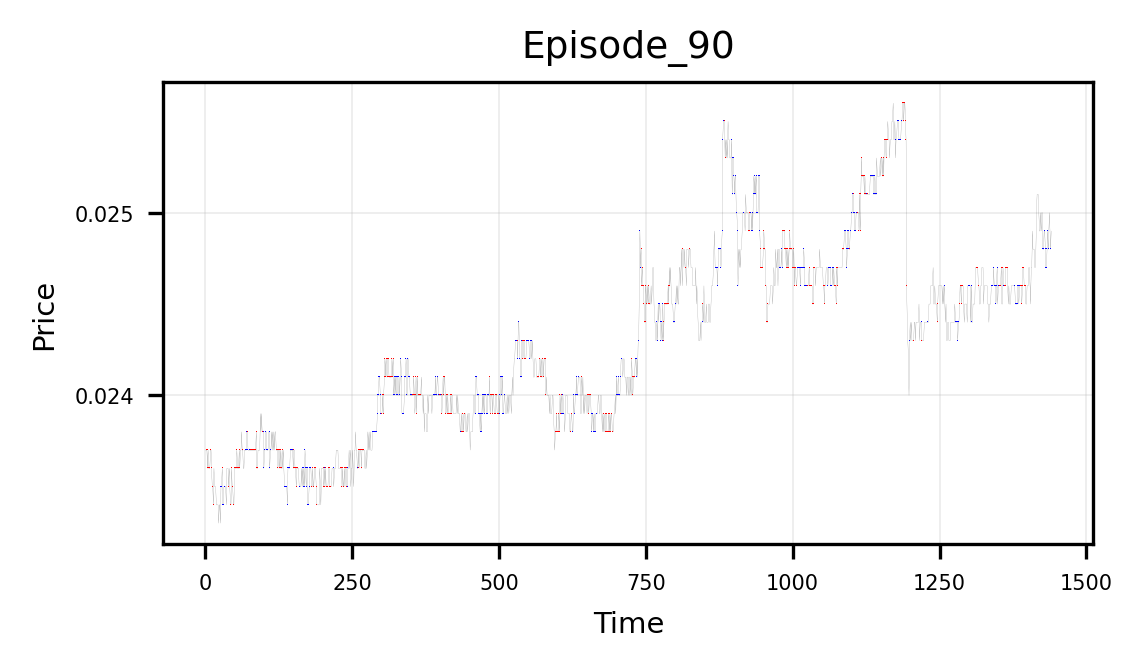

[Episode: 100] total reward: -4.1645, episode length : 1439
   cash: 52.155, coin: 44.547, total: 96.702
   sell: 418, hold: 595, buy: 426
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


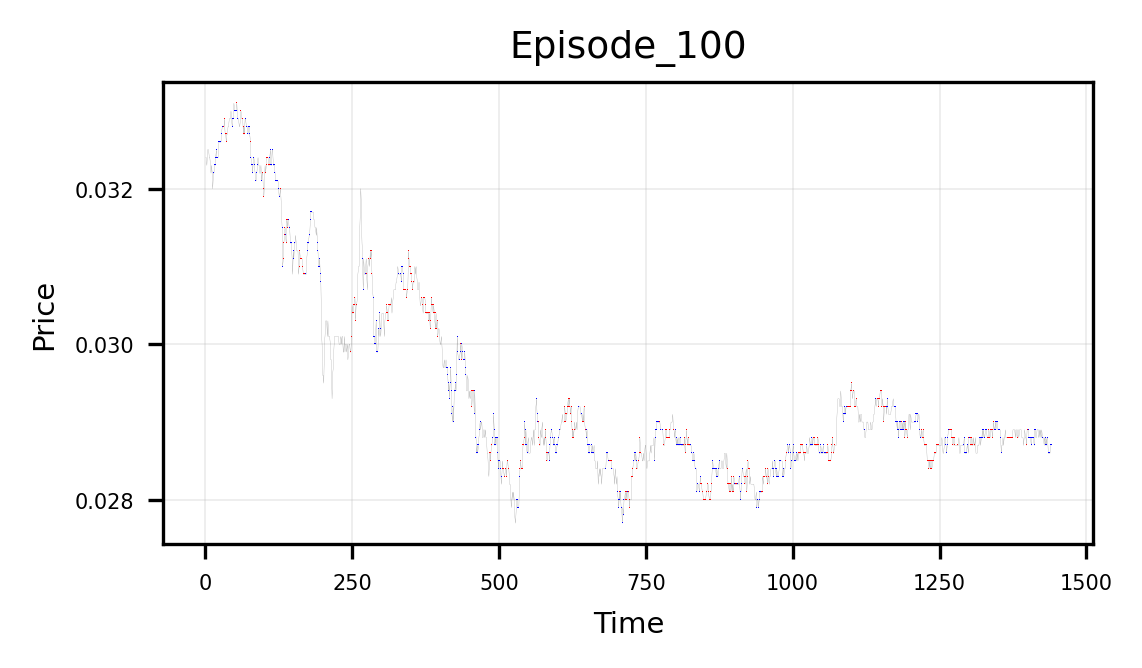

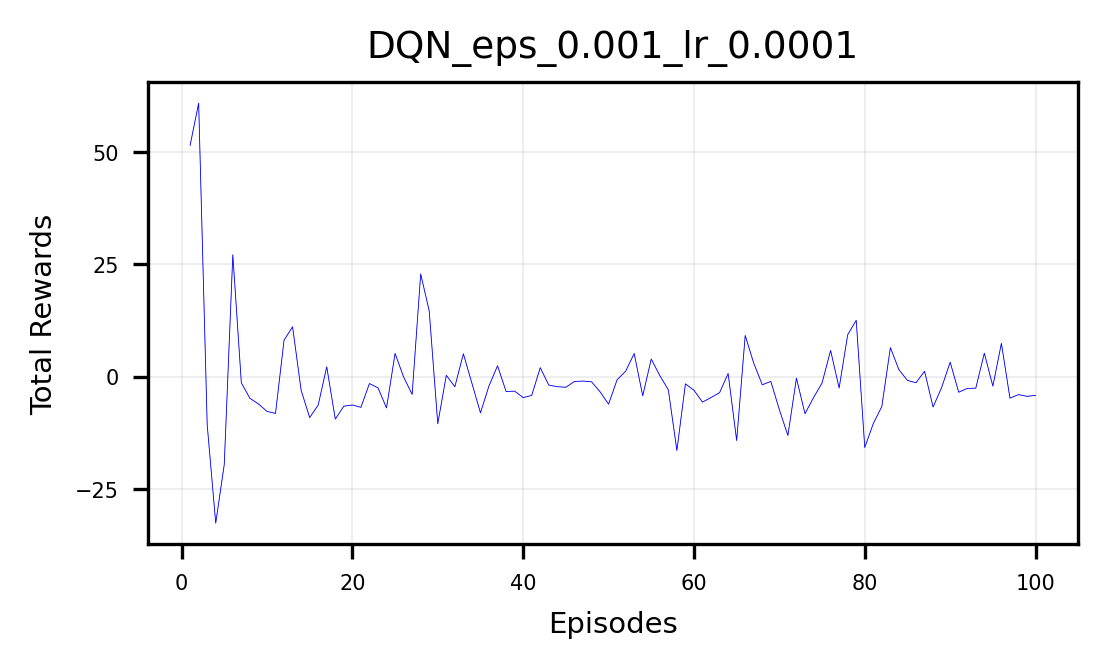

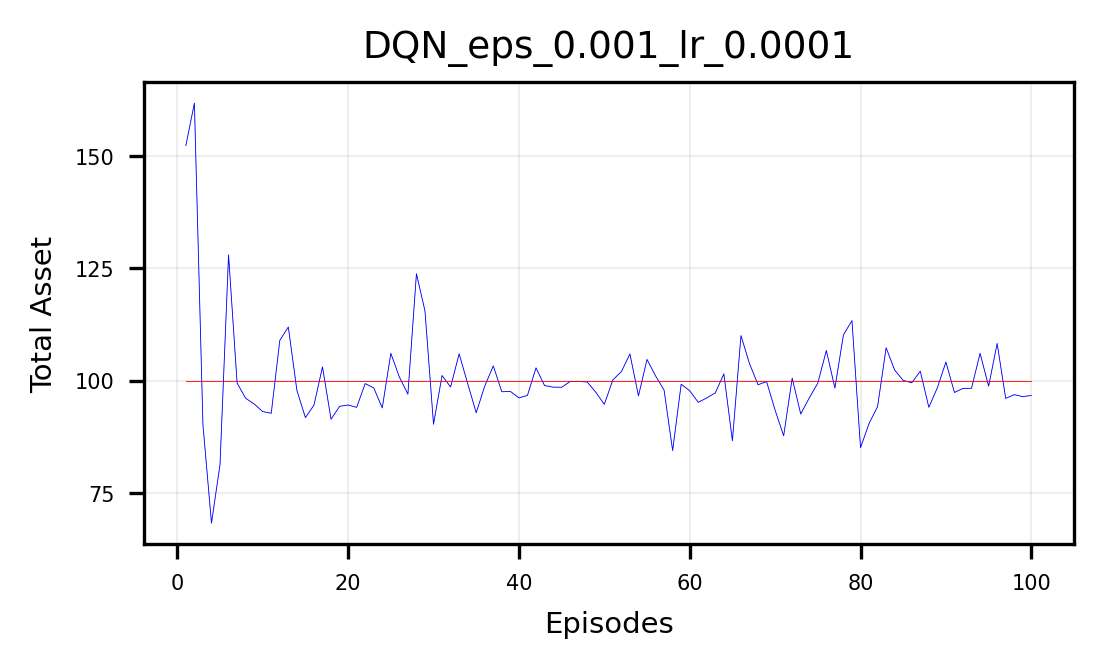

 ################ 
 lr : 1e-05  eps : 0.001 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -5.2415, episode length : 1439
   cash: 6.201, coin: 89.436, total: 95.637
   sell: 372, hold: 641, buy: 426
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


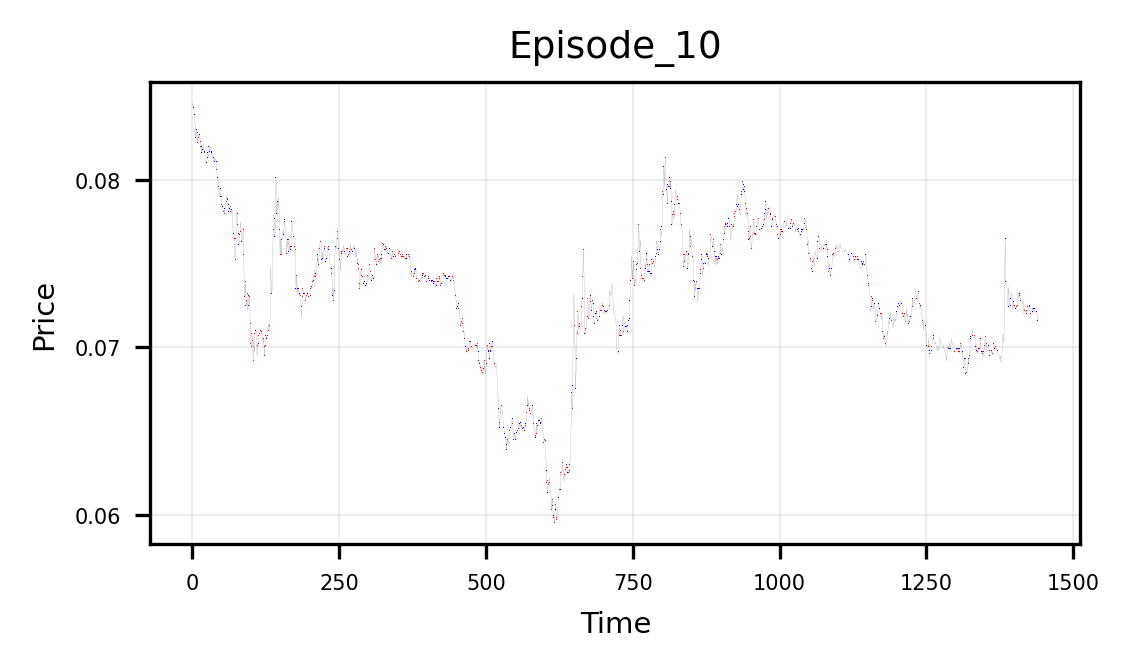

[Episode:  20] total reward: -5.1346, episode length : 1439
   cash: 3.152, coin: 92.667, total: 95.819
   sell: 395, hold: 592, buy: 452
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


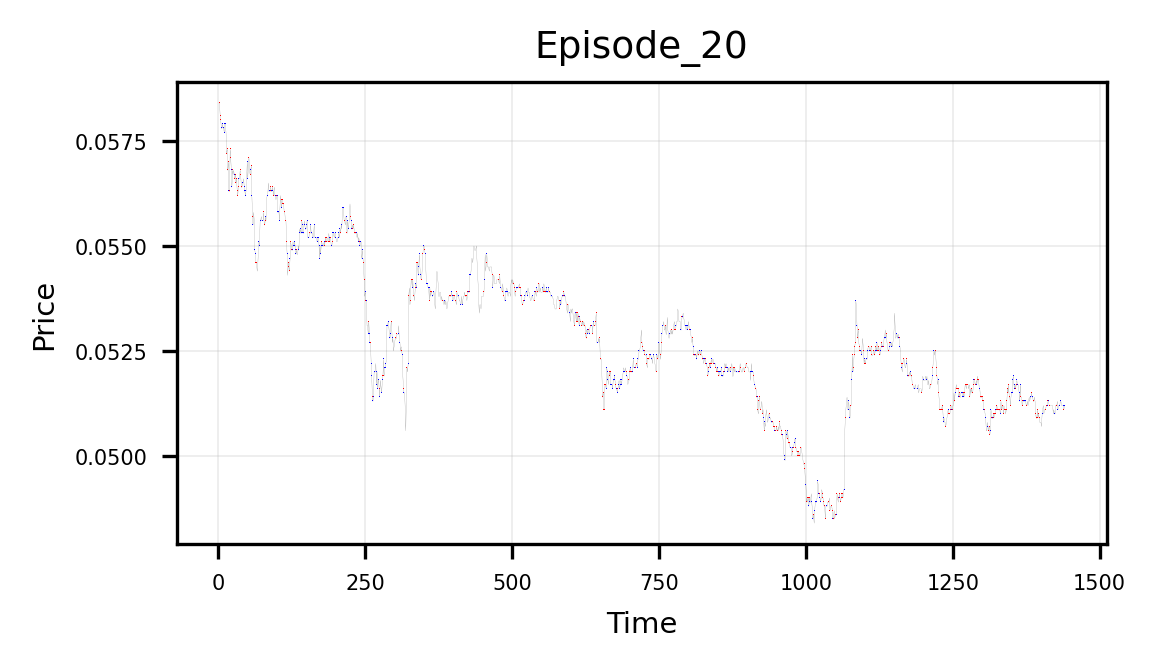

[Episode:  30] total reward: -8.6513, episode length : 1439
   cash: 75.136, coin: 17.222, total: 92.358
   sell: 440, hold: 576, buy: 423
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


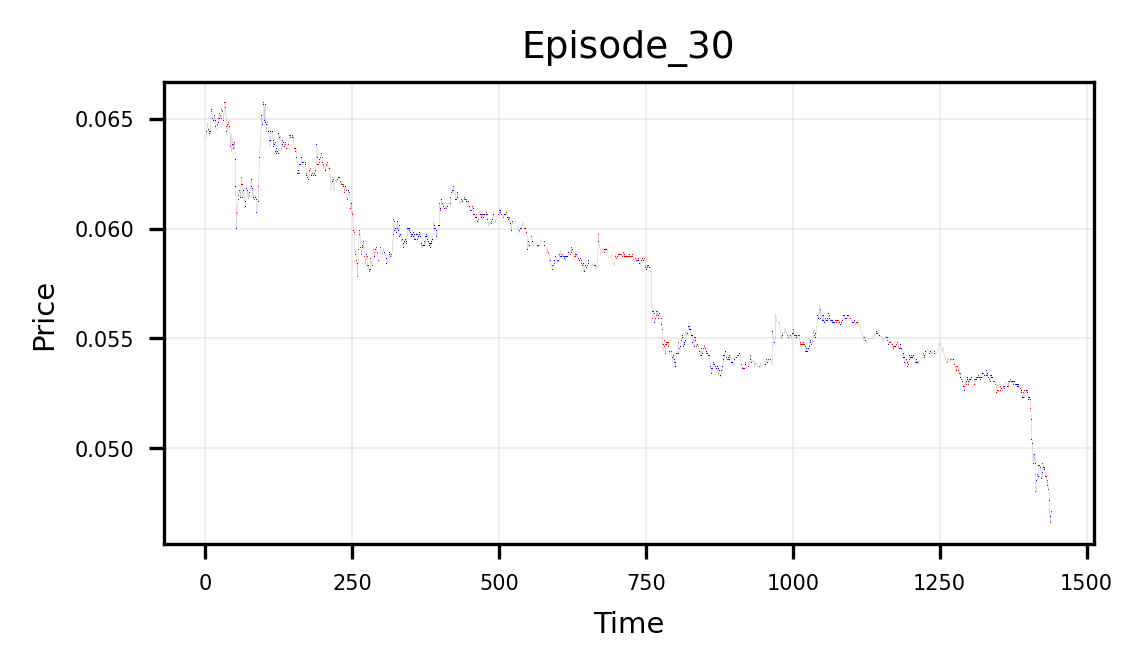

[Episode:  40] total reward: -2.5471, episode length : 1439
   cash: 80.093, coin: 18.415, total: 98.508
   sell: 464, hold: 533, buy: 442
   buffer size: 57560, epsilon: 0.2590
   time: 0.27 (min)


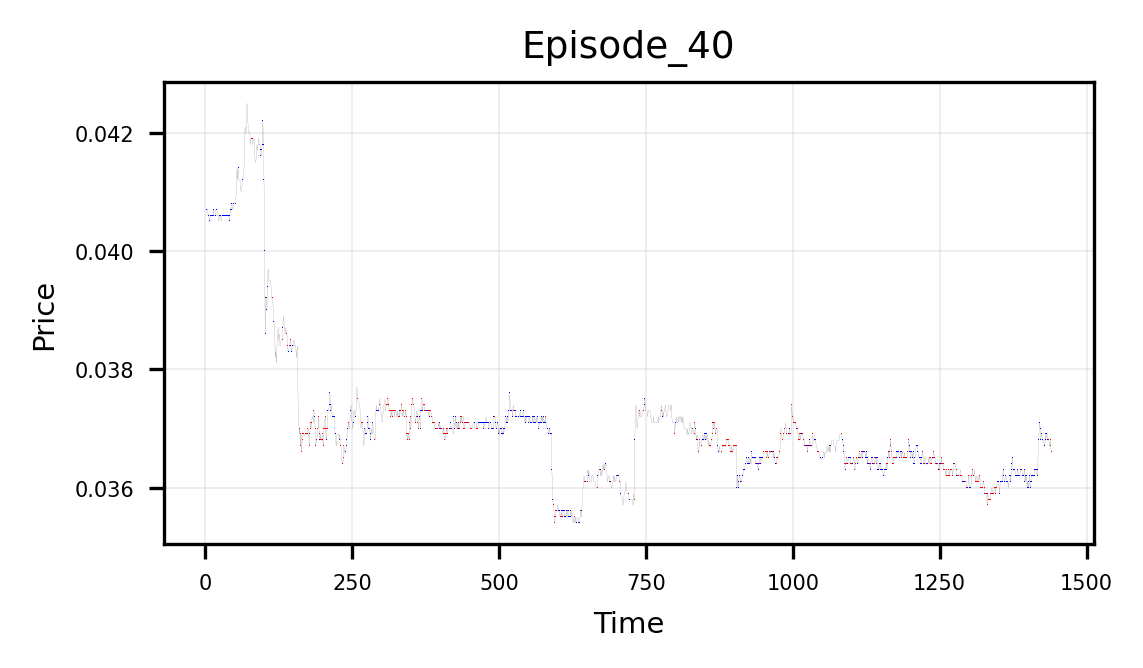

[Episode:  50] total reward: -6.0334, episode length : 1439
   cash: 66.405, coin: 28.433, total: 94.838
   sell: 300, hold: 845, buy: 294
   buffer size: 60000, epsilon: 0.0690
   time: 0.27 (min)


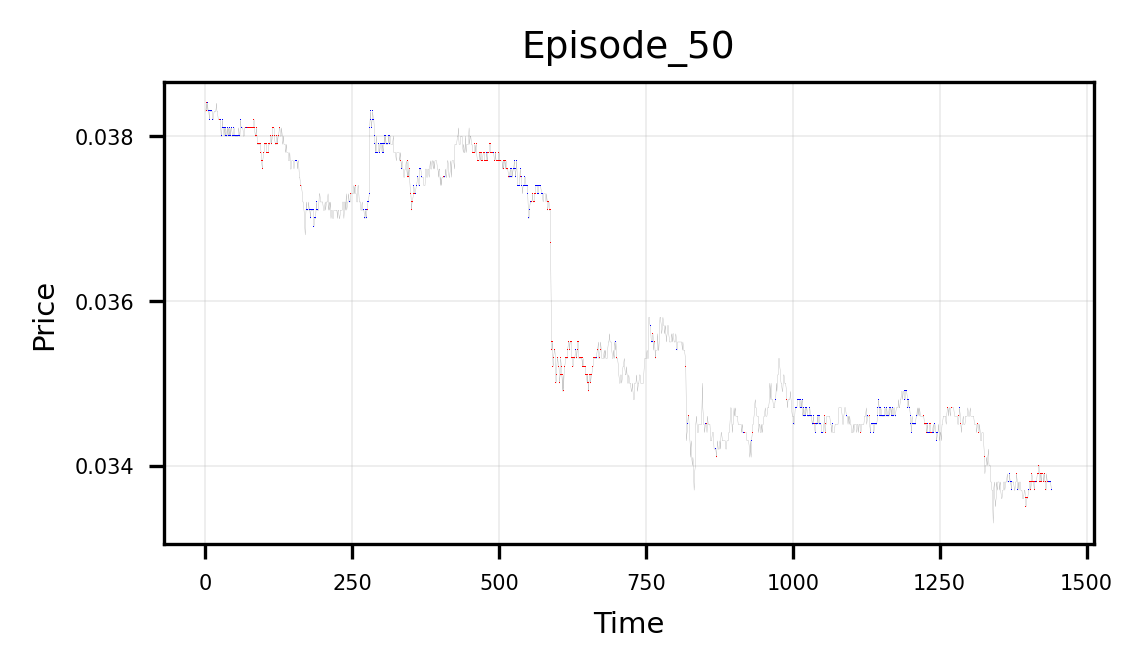

[Episode:  60] total reward: 0.9142, episode length : 1439
   cash: 101.496, coin: 0.015, total: 101.511
   sell: 273, hold: 935, buy: 231
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


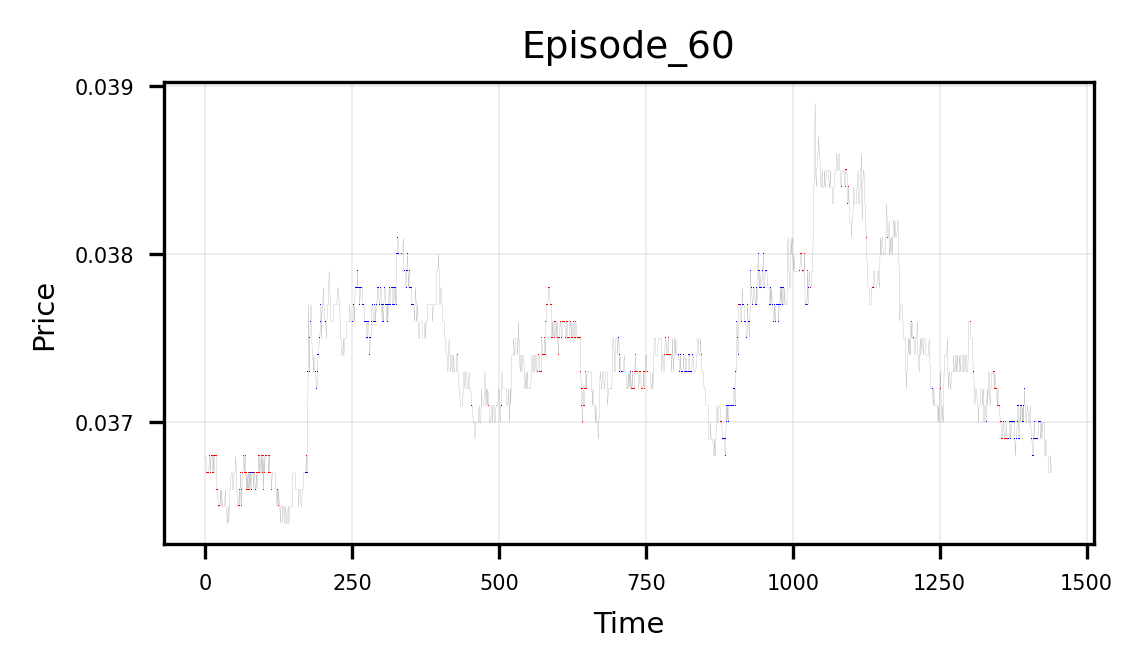

[Episode:  70] total reward: -1.6286, episode length : 1439
   cash: 0.671, coin: 98.482, total: 99.153
   sell: 135, hold: 1110, buy: 194
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


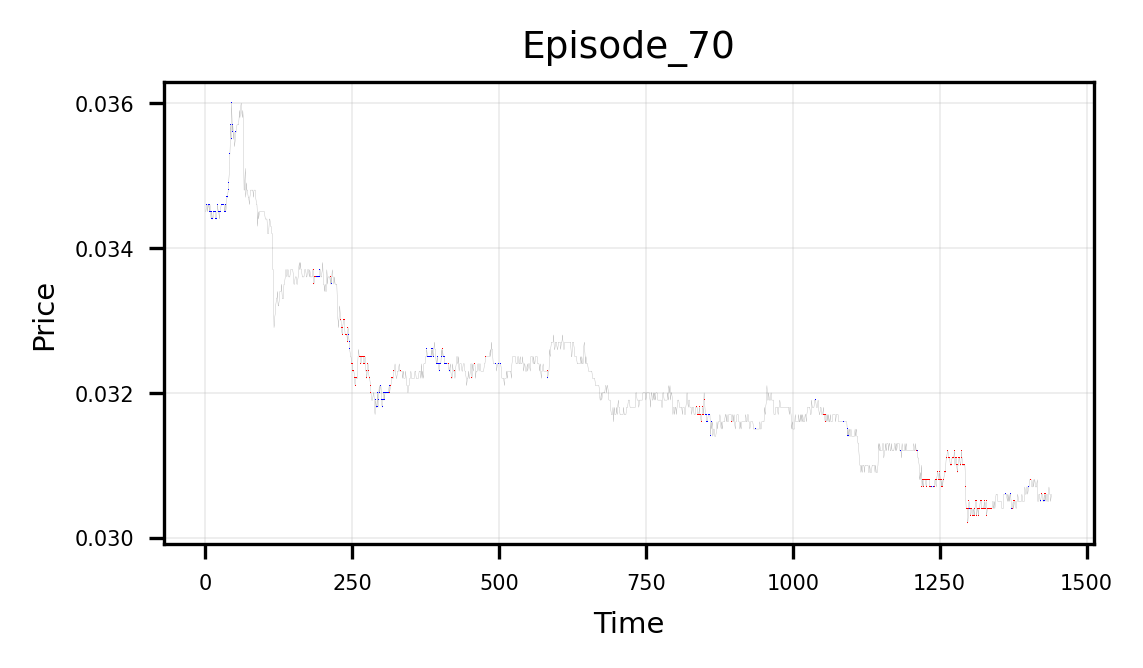

[Episode:  80] total reward: -8.5849, episode length : 1439
   cash: 86.593, coin: 5.457, total: 92.050
   sell: 217, hold: 1032, buy: 190
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


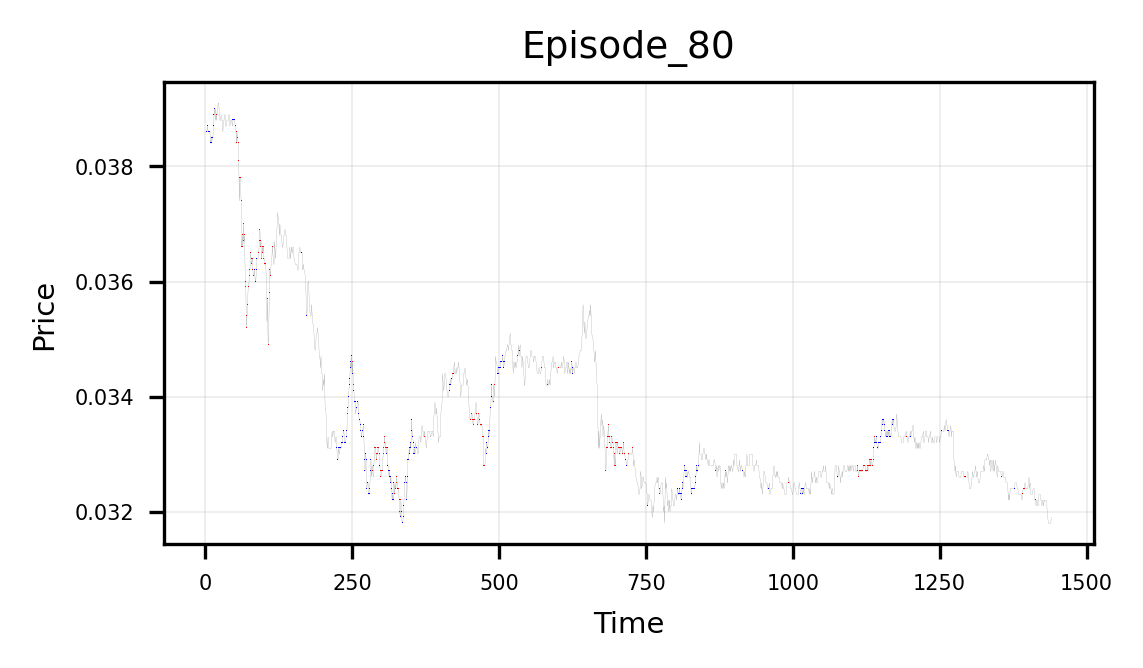

[Episode:  90] total reward: 1.3834, episode length : 1439
   cash: 92.447, coin: 9.610, total: 102.057
   sell: 293, hold: 886, buy: 260
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


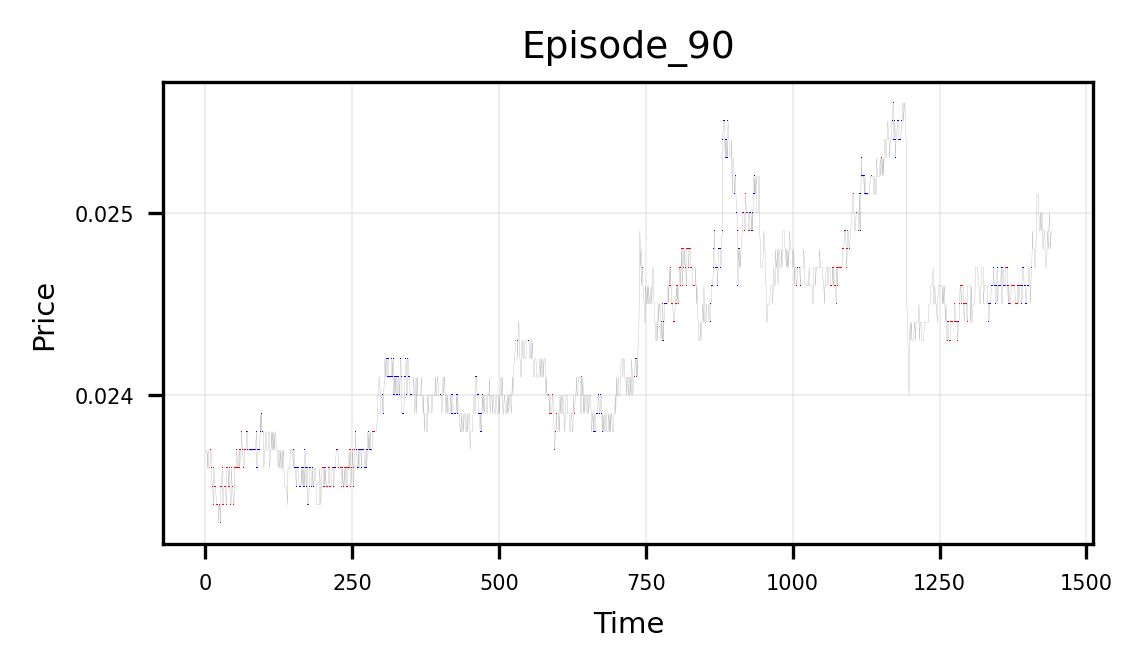

[Episode: 100] total reward: -8.8225, episode length : 1439
   cash: 73.508, coin: 18.353, total: 91.861
   sell: 253, hold: 948, buy: 238
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


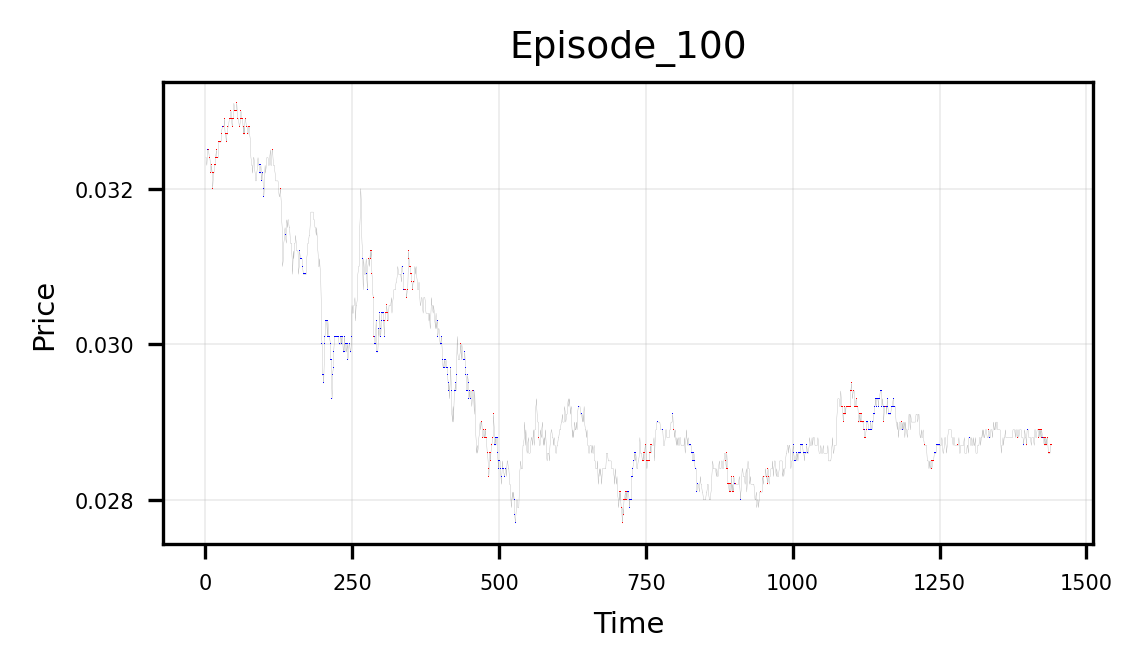

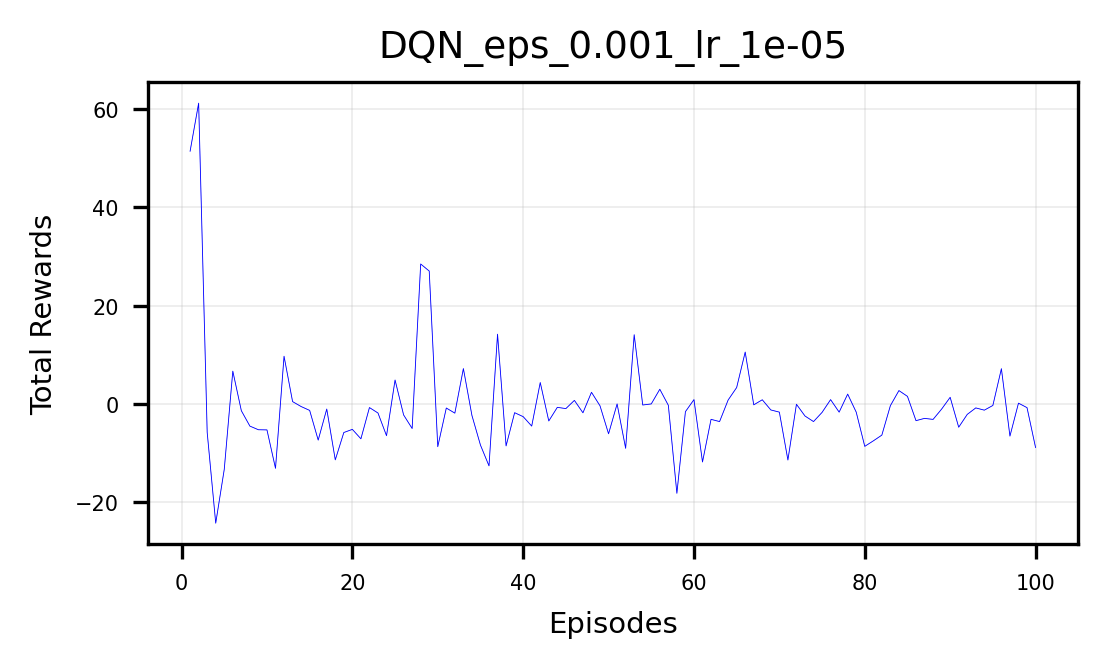

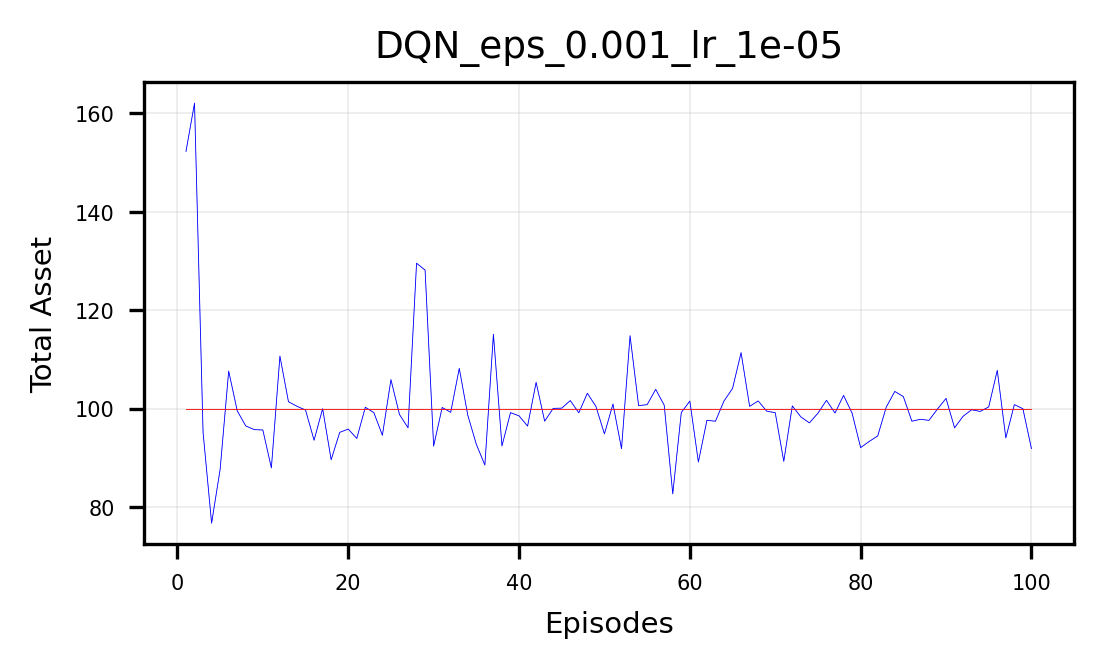

 ################ 
 lr : 1e-06  eps : 0.001 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -7.3211, episode length : 1439
   cash: 10.149, coin: 83.384, total: 93.533
   sell: 400, hold: 589, buy: 450
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


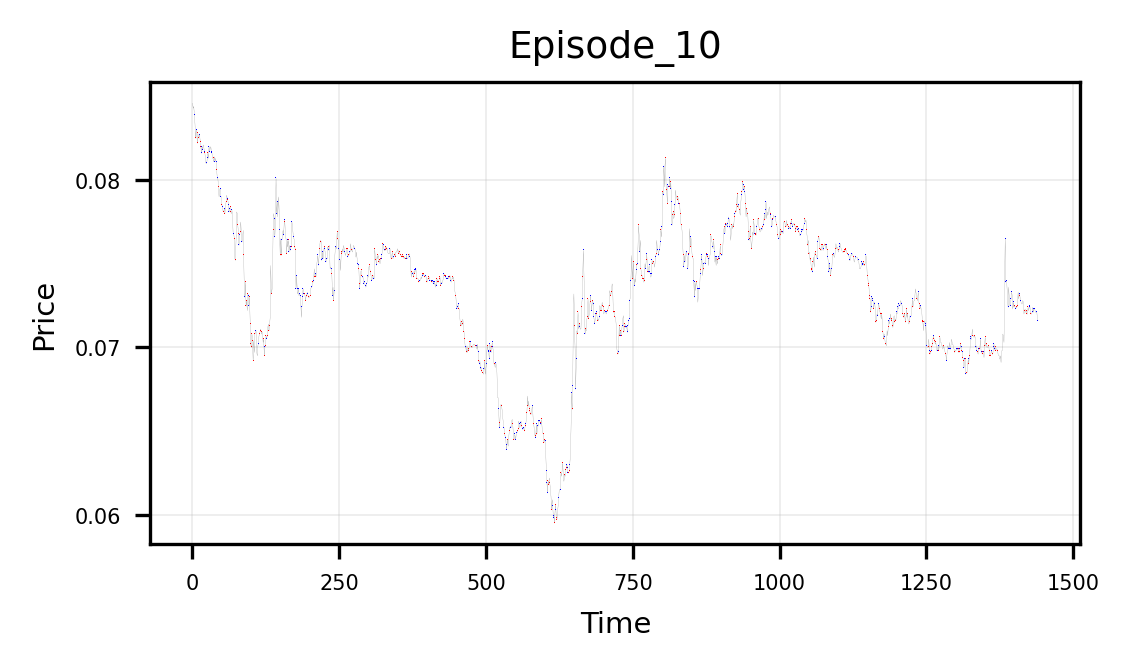

[Episode:  20] total reward: -4.4685, episode length : 1439
   cash: 86.111, coin: 10.320, total: 96.431
   sell: 457, hold: 551, buy: 431
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


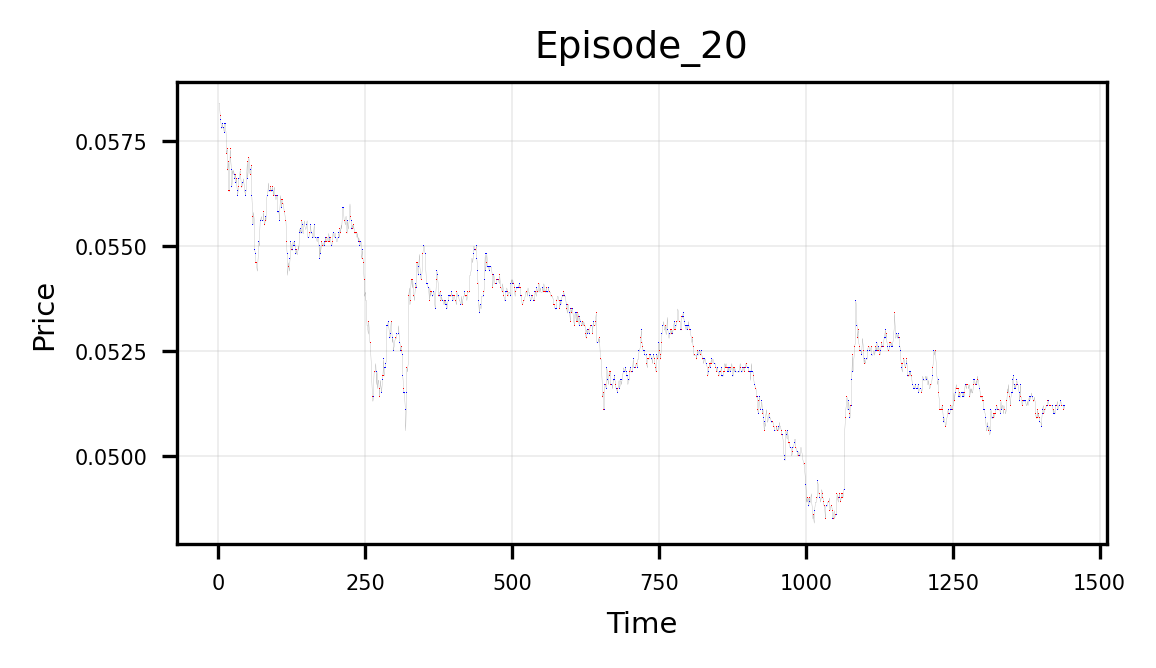

[Episode:  30] total reward: -11.8545, episode length : 1439
   cash: 63.078, coin: 25.989, total: 89.067
   sell: 463, hold: 518, buy: 458
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


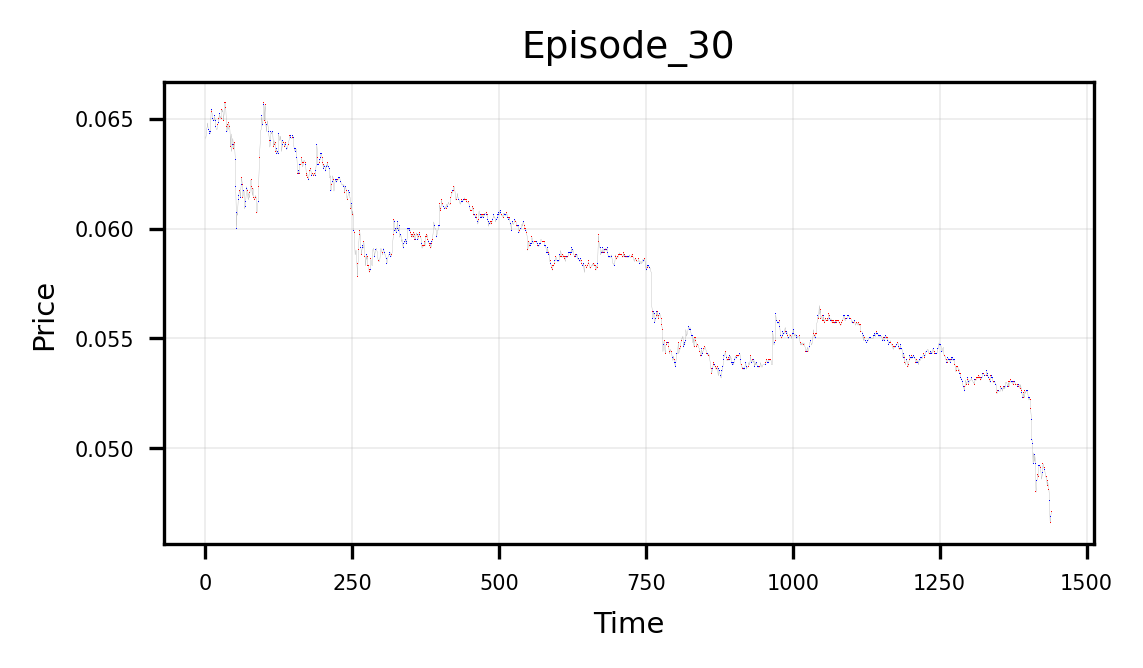

[Episode:  40] total reward: -3.4172, episode length : 1439
   cash: 78.203, coin: 19.226, total: 97.429
   sell: 408, hold: 643, buy: 388
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


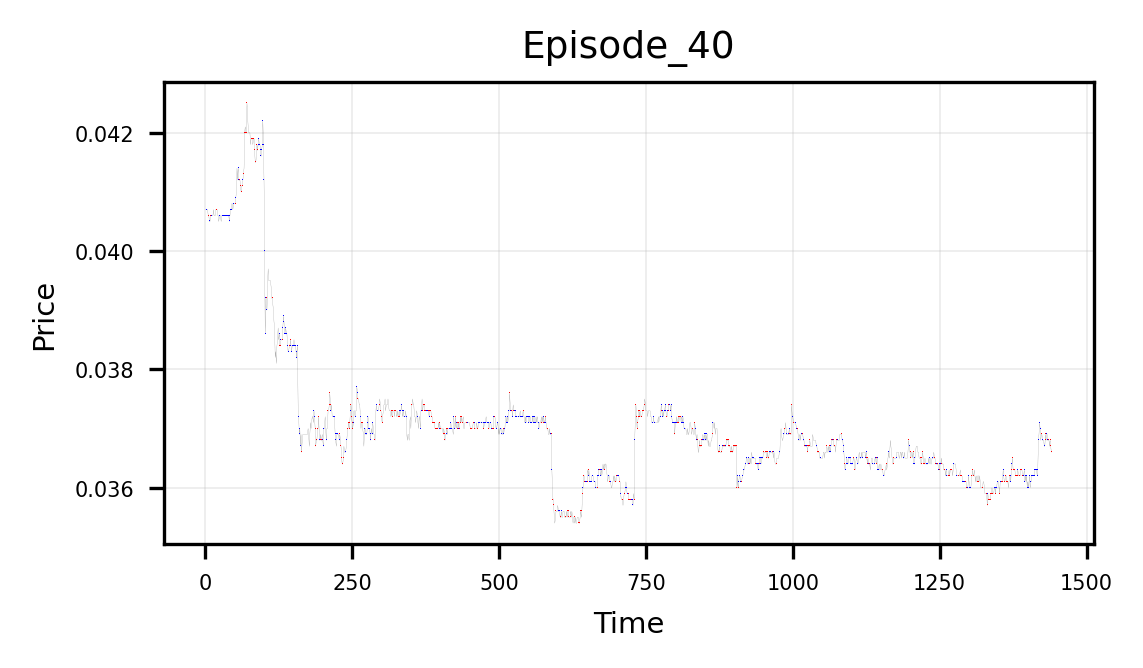

[Episode:  50] total reward: -6.2011, episode length : 1439
   cash: 24.183, coin: 70.433, total: 94.616
   sell: 391, hold: 623, buy: 425
   buffer size: 60000, epsilon: 0.0690
   time: 0.27 (min)


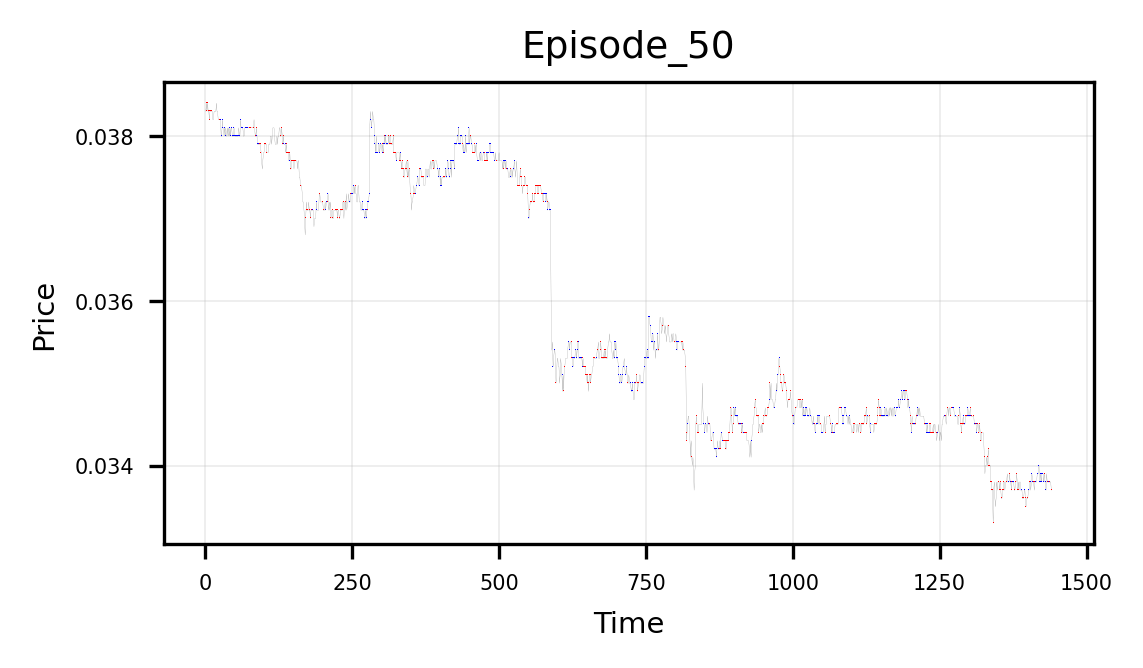

[Episode:  60] total reward: -3.2915, episode length : 1439
   cash: 0.273, coin: 97.211, total: 97.484
   sell: 334, hold: 712, buy: 393
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


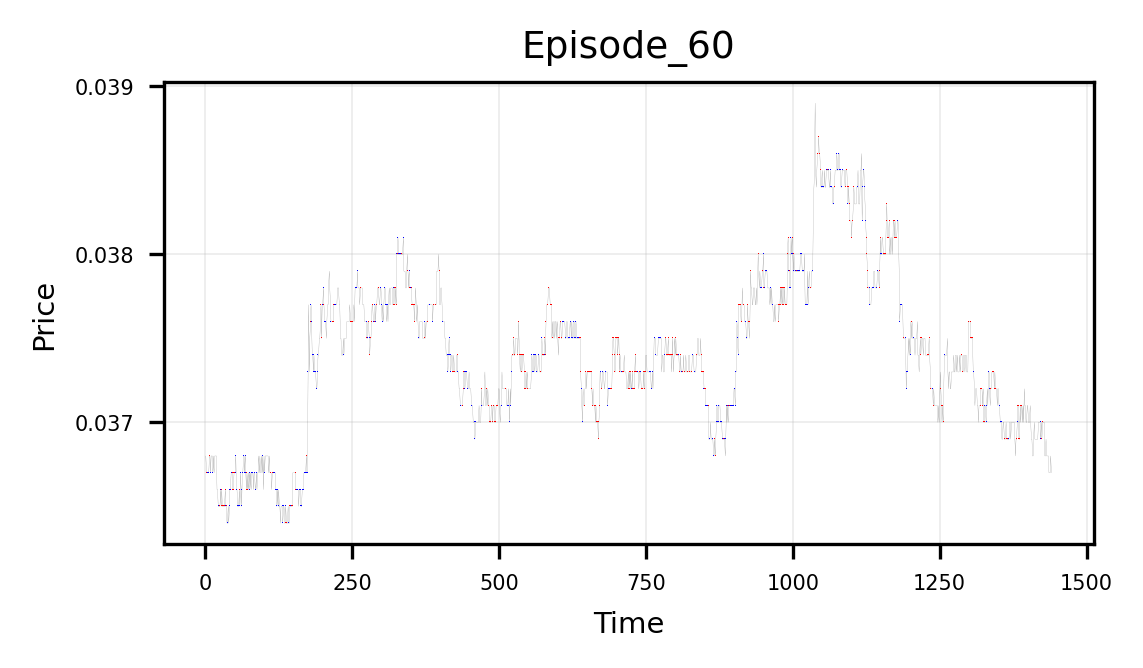

[Episode:  70] total reward: -5.9143, episode length : 1439
   cash: 90.433, coin: 4.294, total: 94.727
   sell: 299, hold: 873, buy: 267
   buffer size: 60000, epsilon: 0.0500
   time: 0.27 (min)


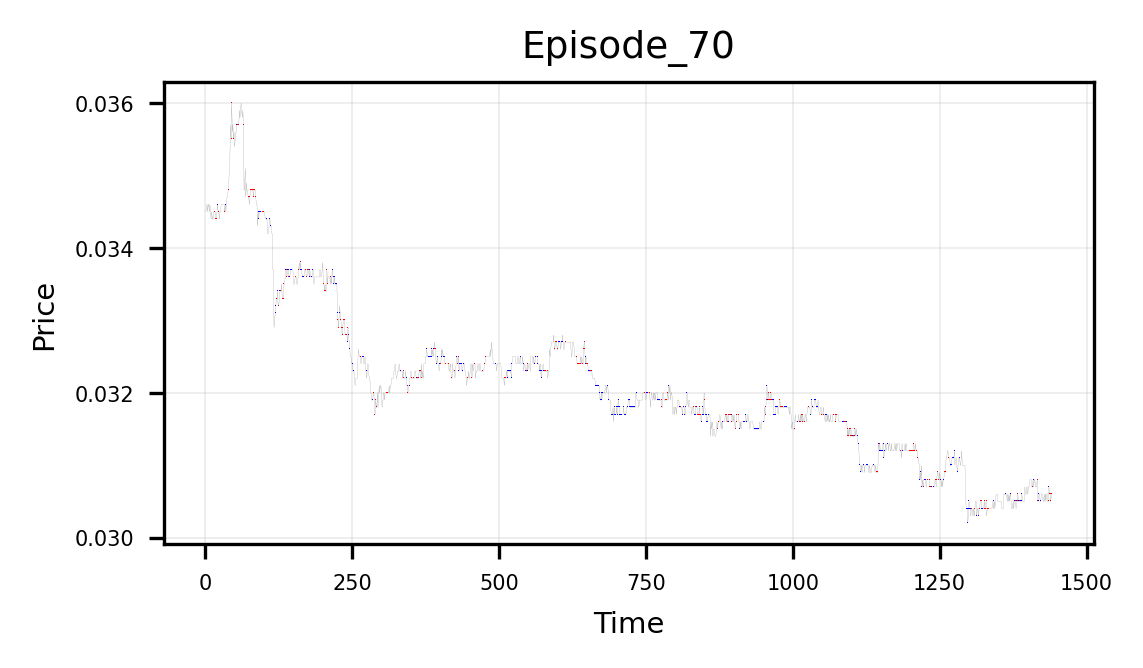

[Episode:  80] total reward: -5.8536, episode length : 1439
   cash: 0.323, coin: 94.723, total: 95.046
   sell: 309, hold: 762, buy: 368
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


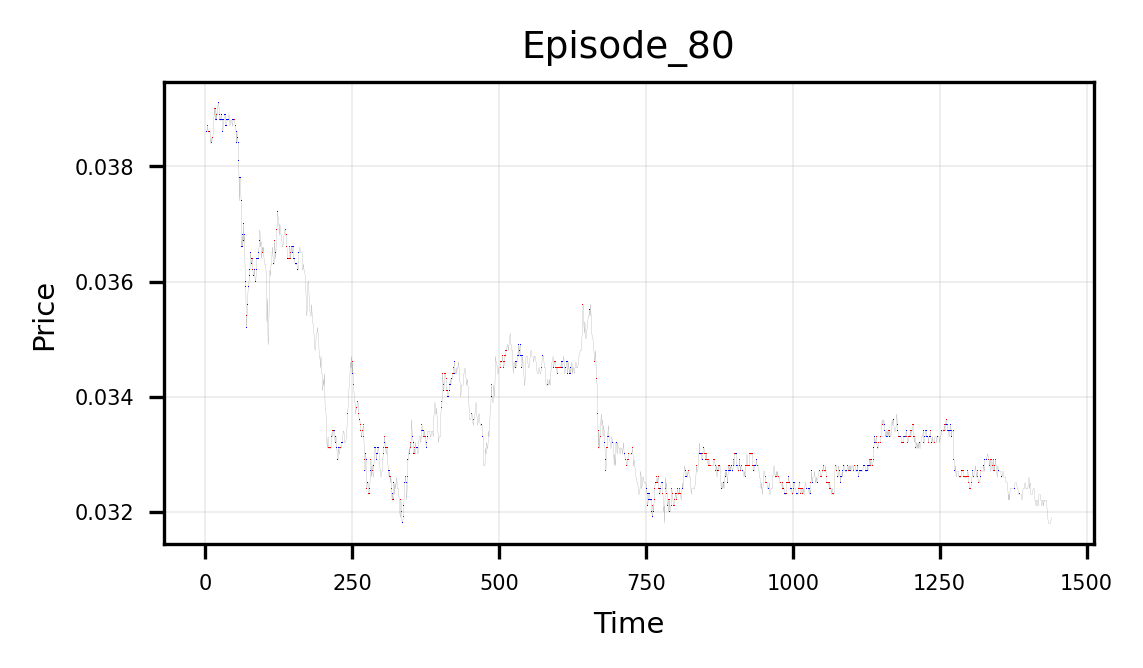

[Episode:  90] total reward: 3.3245, episode length : 1439
   cash: 45.342, coin: 58.684, total: 104.026
   sell: 322, hold: 781, buy: 336
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


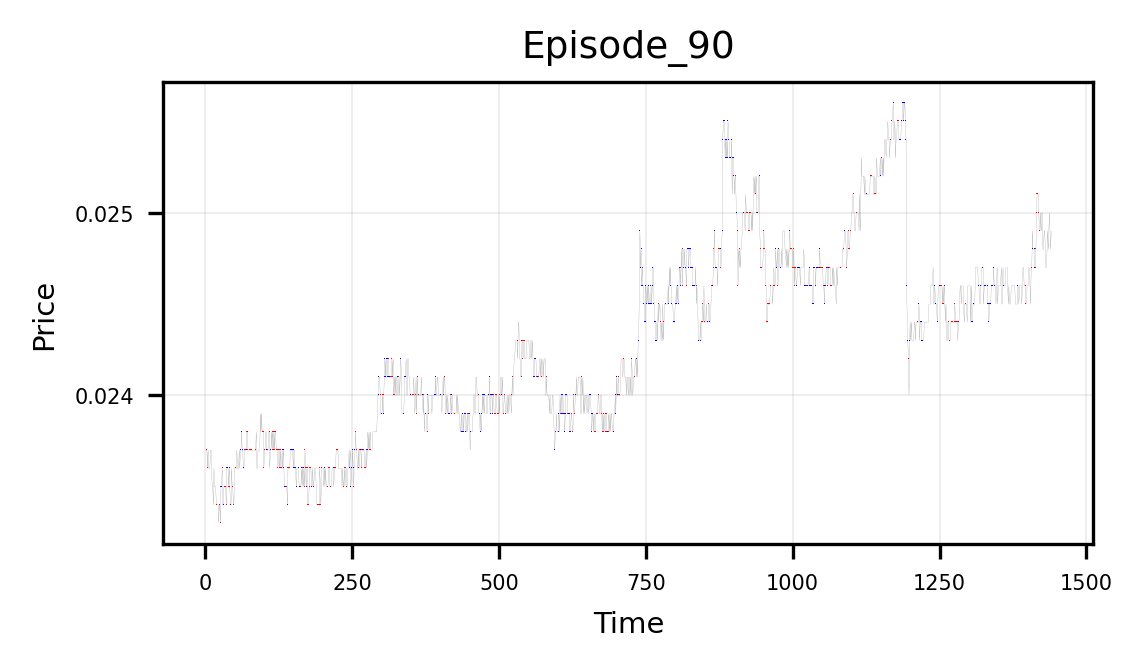

[Episode: 100] total reward: -7.5428, episode length : 1439
   cash: 0.501, coin: 92.766, total: 93.267
   sell: 220, hold: 940, buy: 279
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


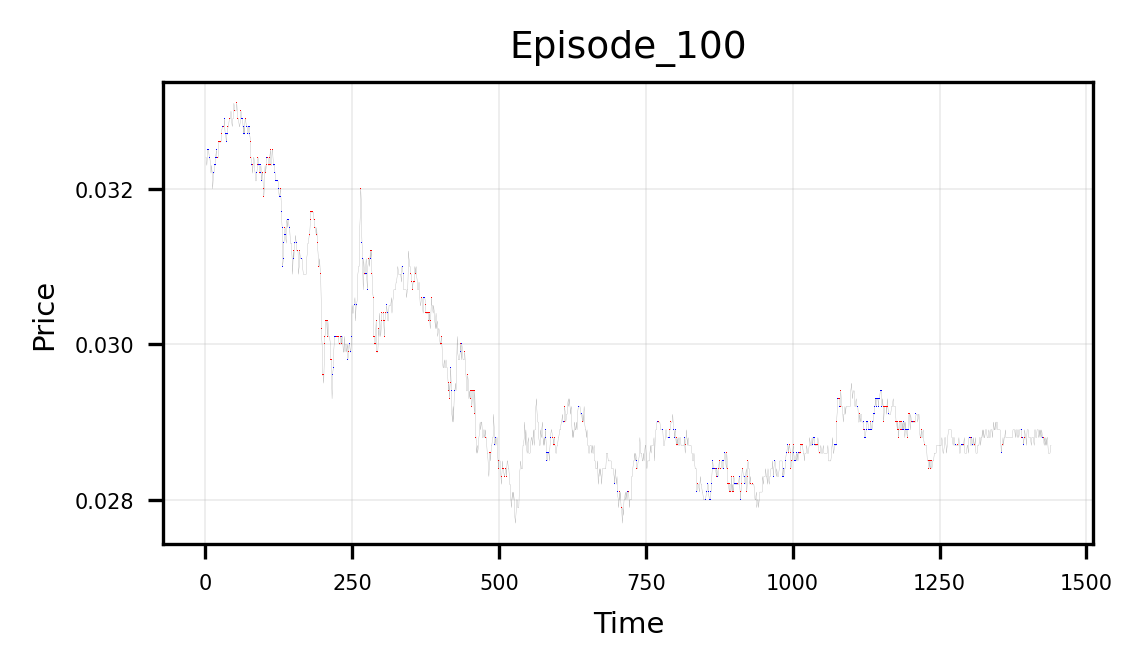

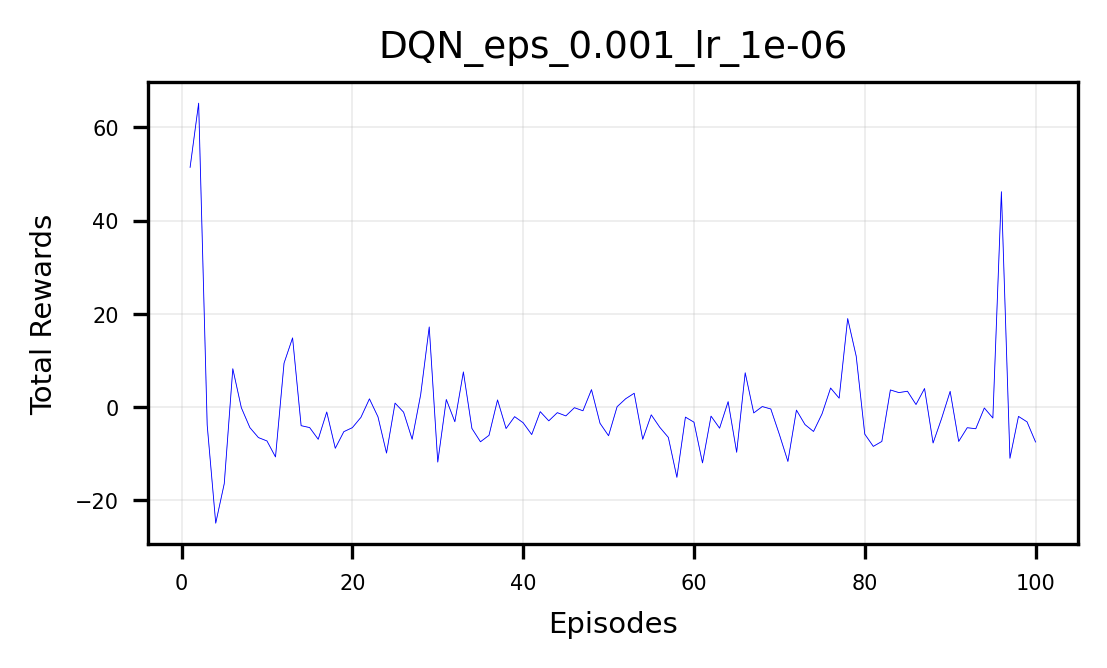

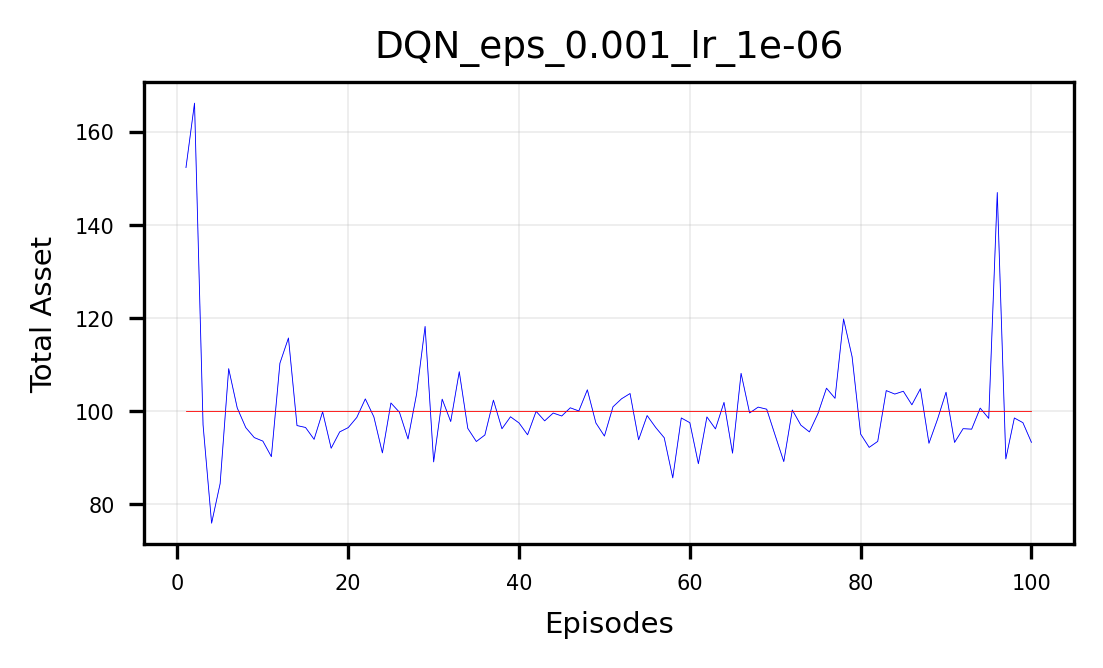

 ################ 
 lr : 0.0001  eps : 0.005 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -11.0111, episode length : 1439
   cash: 6.197, coin: 86.942, total: 93.139
   sell: 374, hold: 637, buy: 428
   buffer size: 14390, epsilon: 0.8290
   time: 0.28 (min)


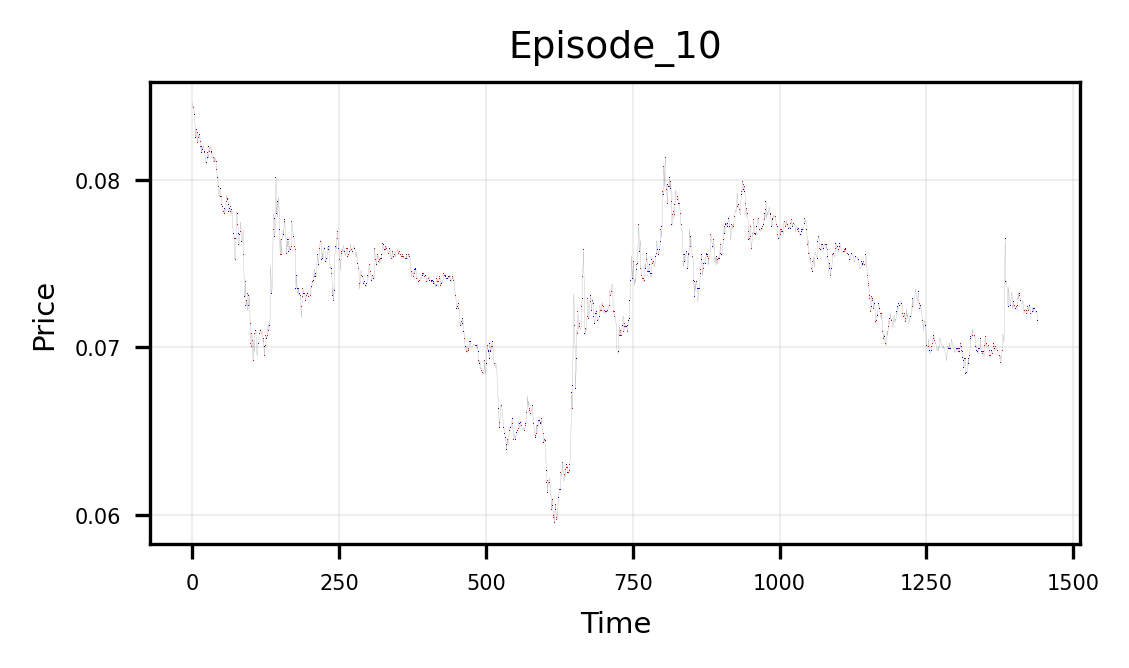

[Episode:  20] total reward: -9.8203, episode length : 1439
   cash: 76.125, coin: 18.430, total: 94.555
   sell: 445, hold: 565, buy: 429
   buffer size: 28780, epsilon: 0.6390
   time: 0.27 (min)


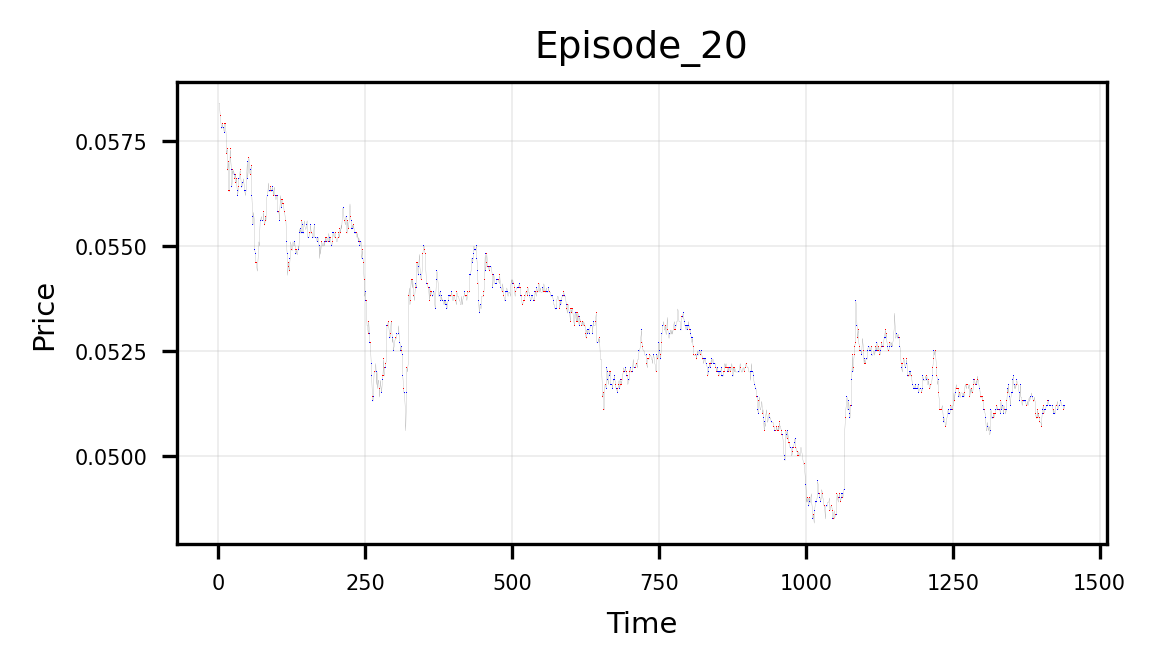

[Episode:  30] total reward: -22.6940, episode length : 1439
   cash: 5.218, coin: 76.033, total: 81.251
   sell: 364, hold: 657, buy: 418
   buffer size: 43170, epsilon: 0.4490
   time: 0.27 (min)


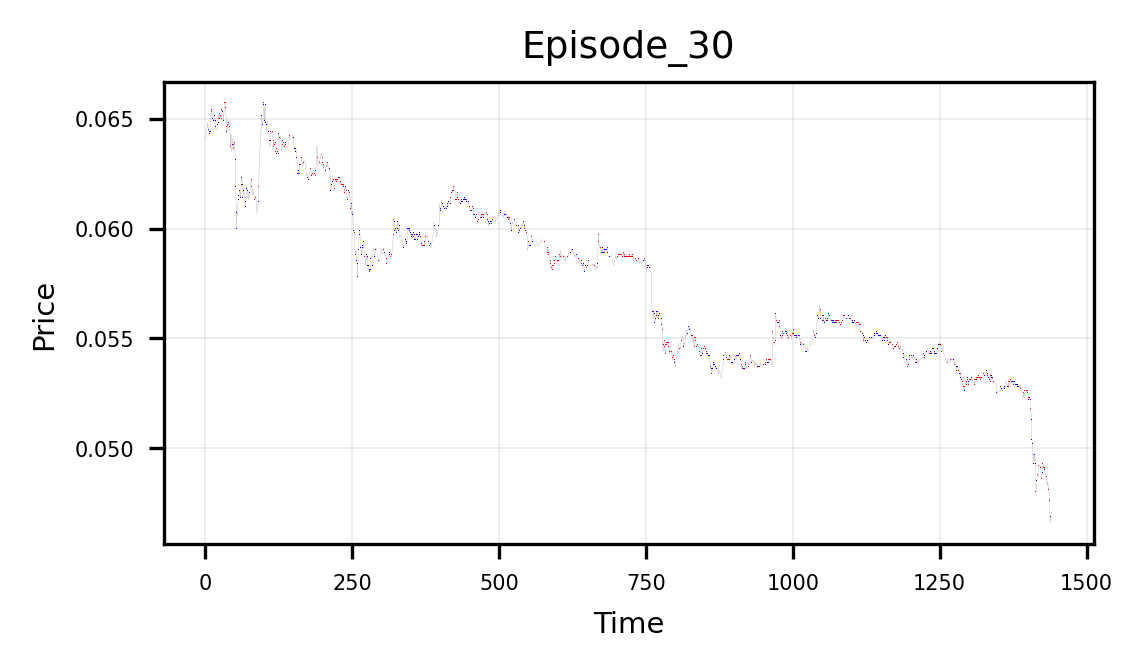

[Episode:  40] total reward: -6.3268, episode length : 1439
   cash: 65.188, coin: 32.570, total: 97.758
   sell: 409, hold: 628, buy: 402
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


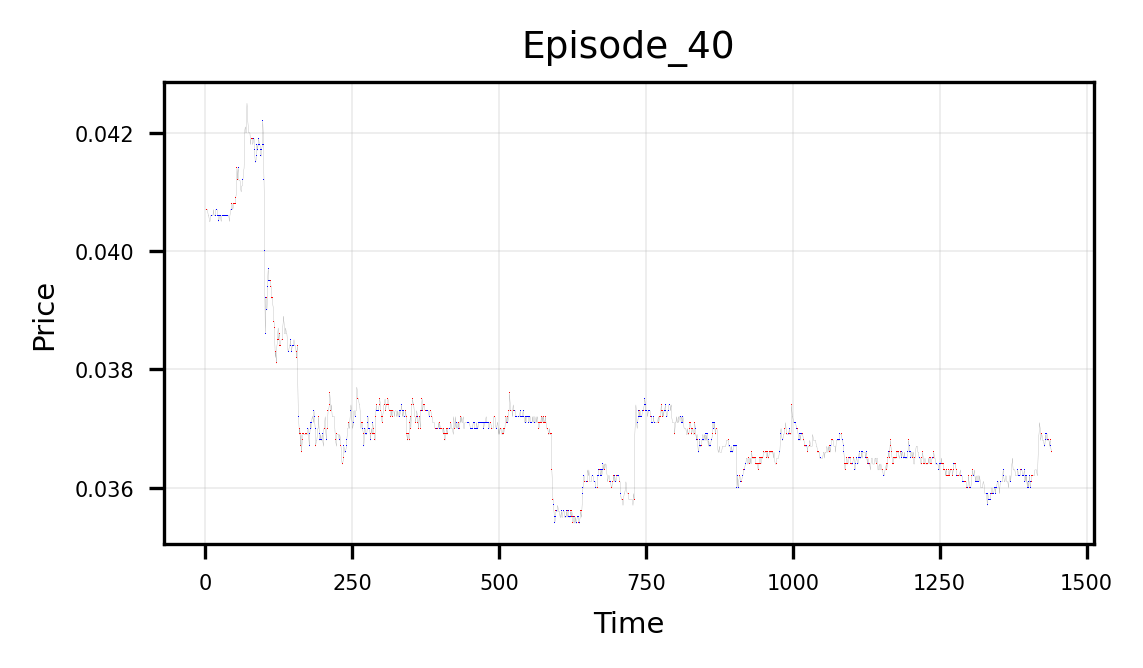

[Episode:  50] total reward: -7.6865, episode length : 1439
   cash: 35.258, coin: 60.880, total: 96.138
   sell: 358, hold: 698, buy: 383
   buffer size: 60000, epsilon: 0.0690
   time: 0.27 (min)


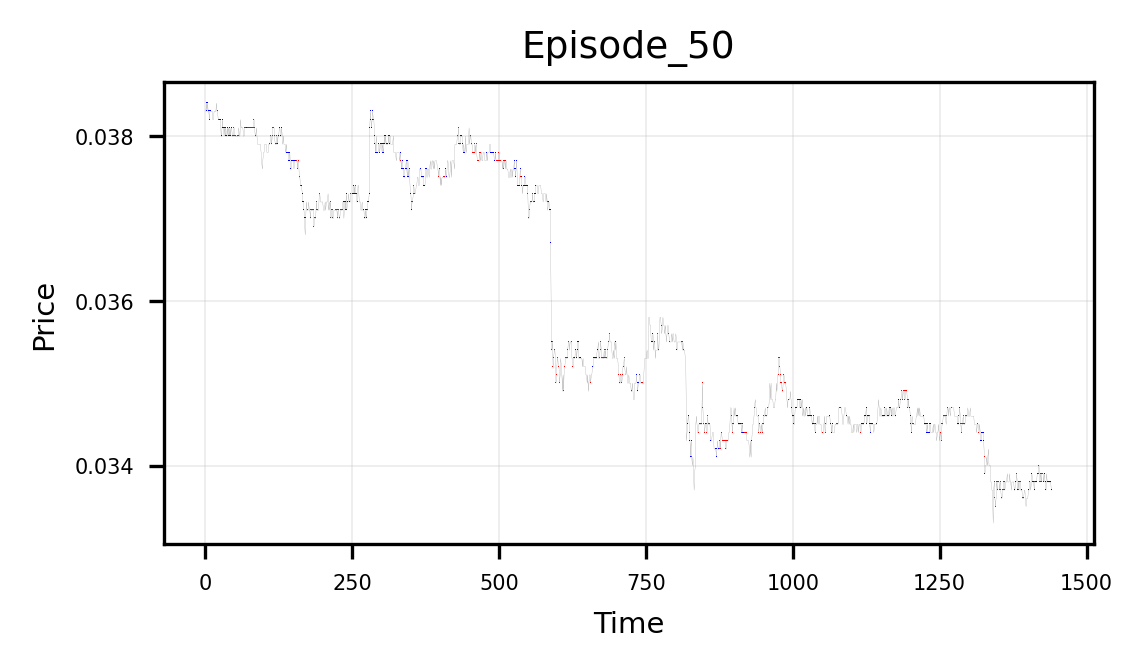

[Episode:  60] total reward: -6.4651, episode length : 1439
   cash: 3.360, coin: 93.720, total: 97.080
   sell: 292, hold: 799, buy: 348
   buffer size: 60000, epsilon: 0.0500
   time: 0.29 (min)


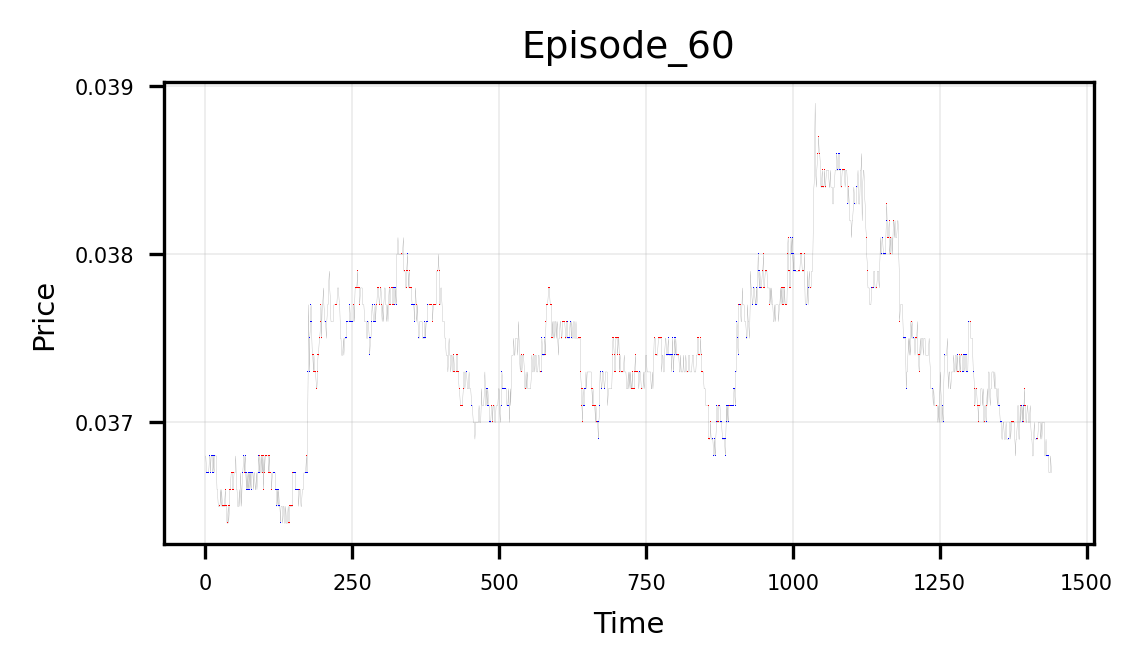

[Episode:  70] total reward: -9.1694, episode length : 1439
   cash: 47.244, coin: 47.577, total: 94.821
   sell: 372, hold: 684, buy: 383
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


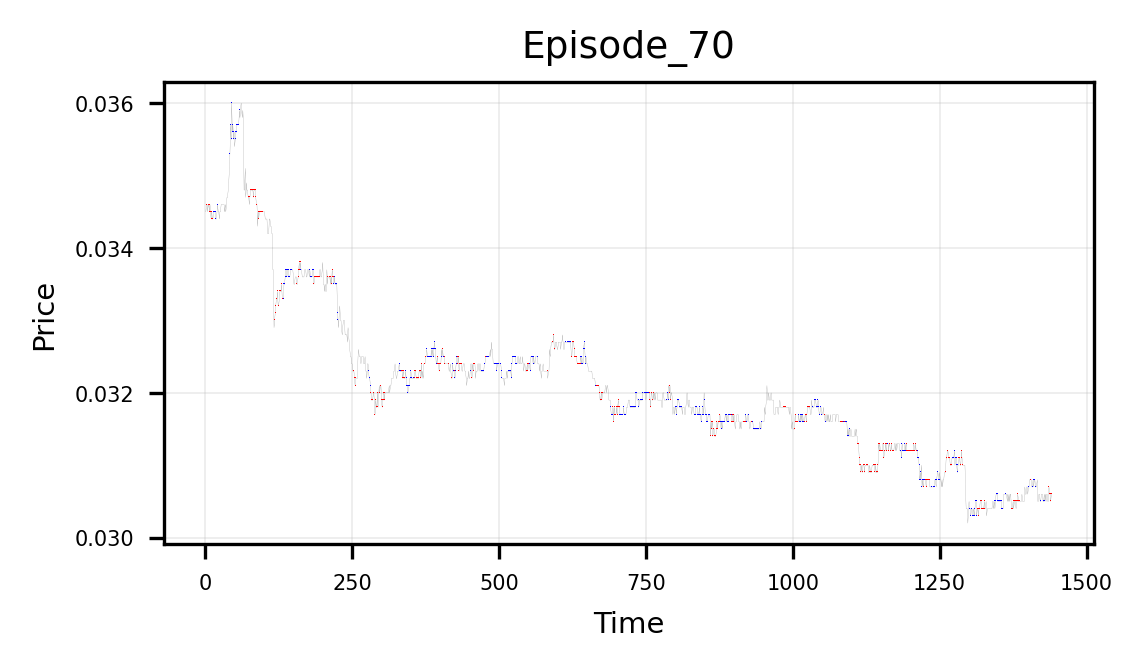

[Episode:  80] total reward: -16.0601, episode length : 1439
   cash: 21.188, coin: 67.042, total: 88.230
   sell: 386, hold: 628, buy: 425
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


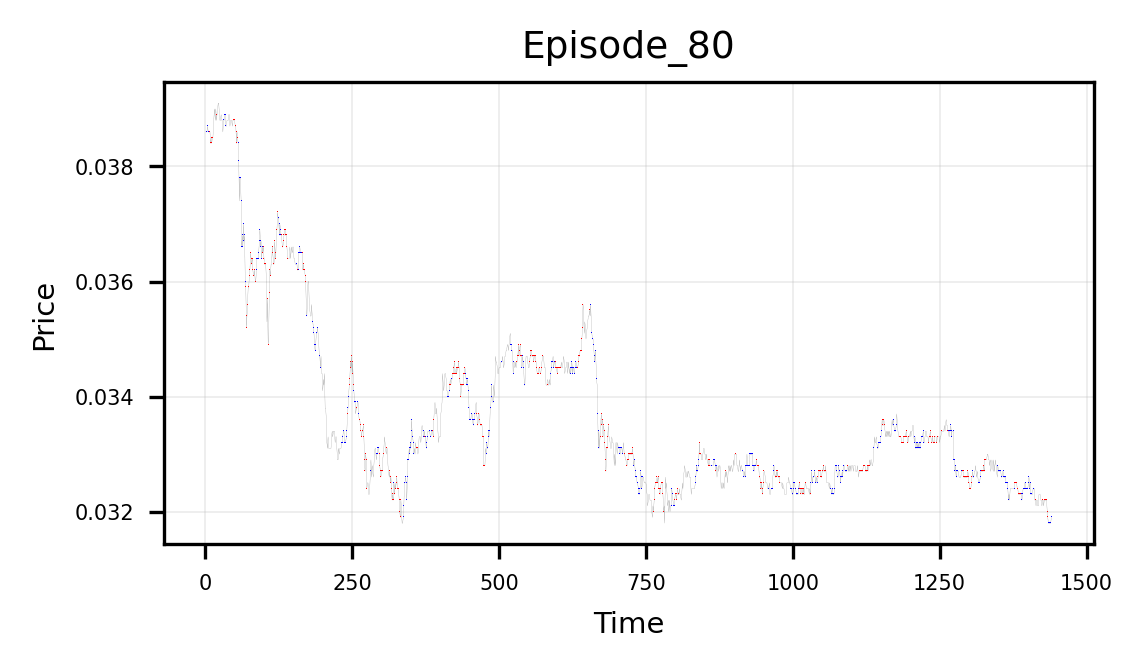

[Episode:  90] total reward: -4.2245, episode length : 1439
   cash: 11.112, coin: 89.213, total: 100.325
   sell: 420, hold: 551, buy: 468
   buffer size: 60000, epsilon: 0.0500
   time: 0.31 (min)


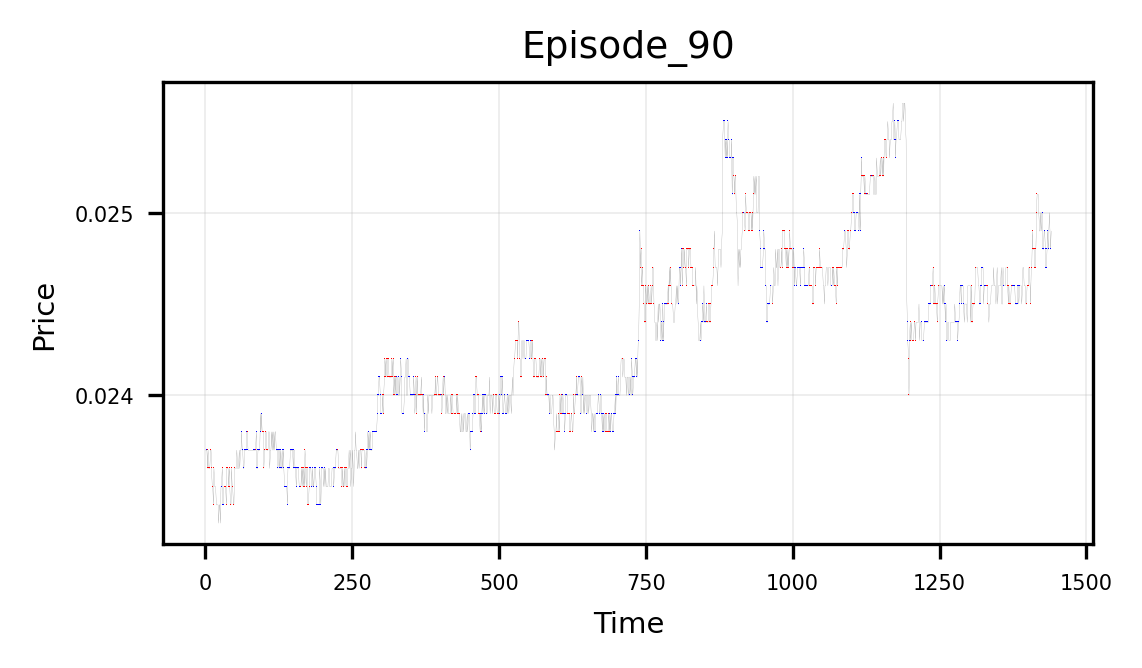

[Episode: 100] total reward: -14.1792, episode length : 1439
   cash: 1.228, coin: 88.643, total: 89.871
   sell: 357, hold: 667, buy: 415
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


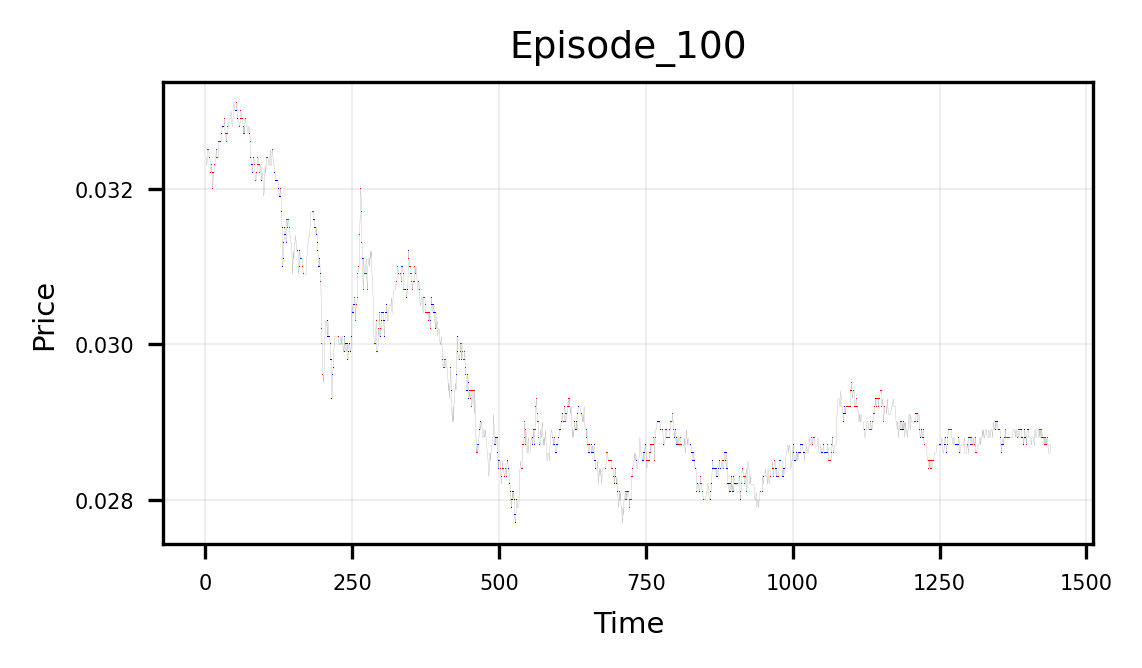

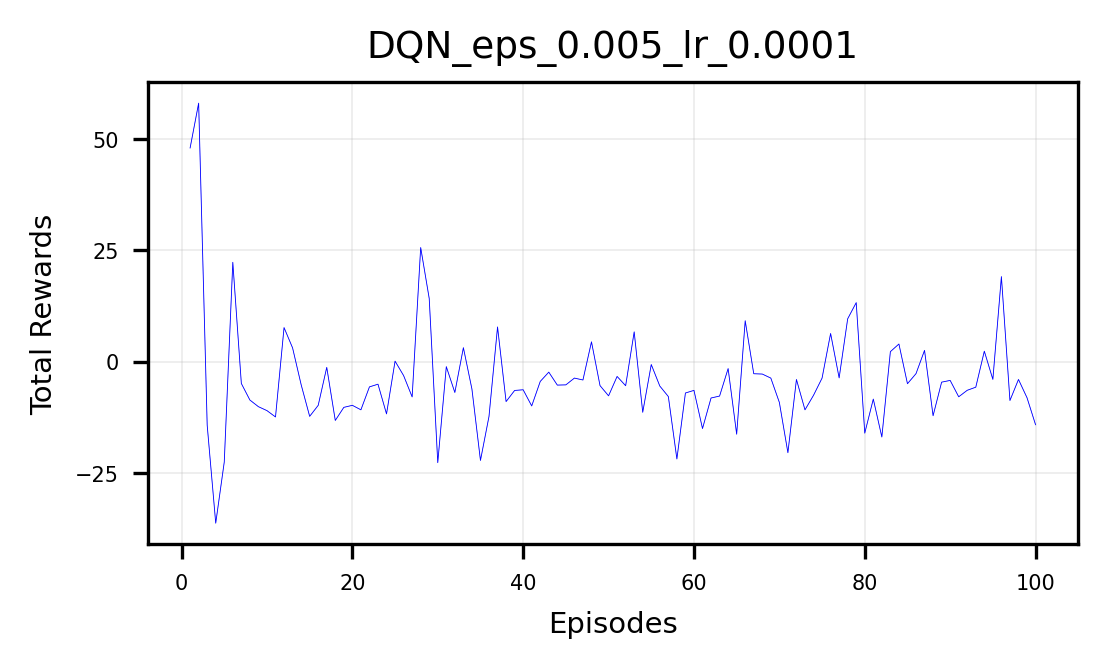

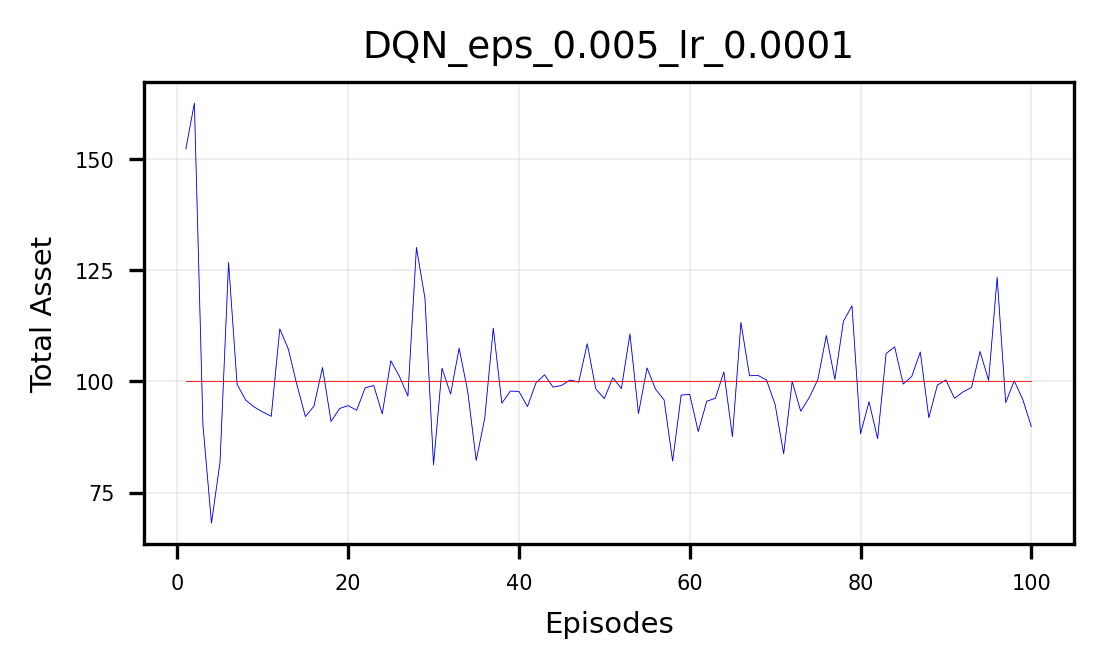

 ################ 
 lr : 1e-05  eps : 0.005 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -9.1366, episode length : 1439
   cash: 7.196, coin: 87.967, total: 95.163
   sell: 375, hold: 636, buy: 428
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


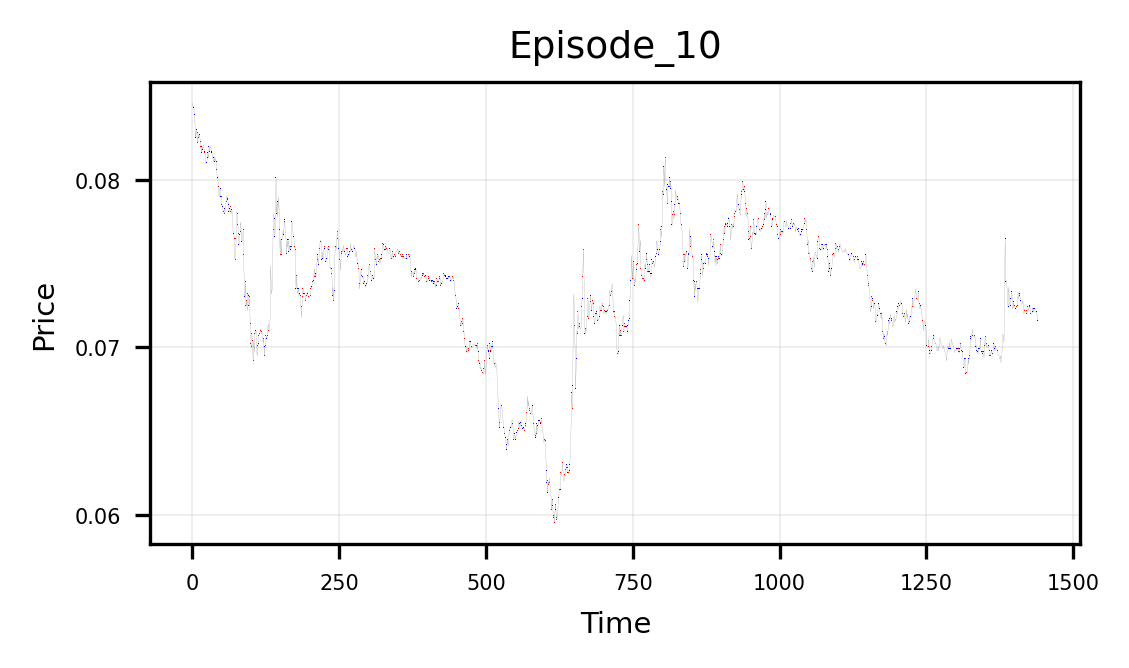

[Episode:  20] total reward: -8.7290, episode length : 1439
   cash: 14.117, coin: 81.679, total: 95.796
   sell: 418, hold: 557, buy: 464
   buffer size: 28780, epsilon: 0.6390
   time: 0.29 (min)


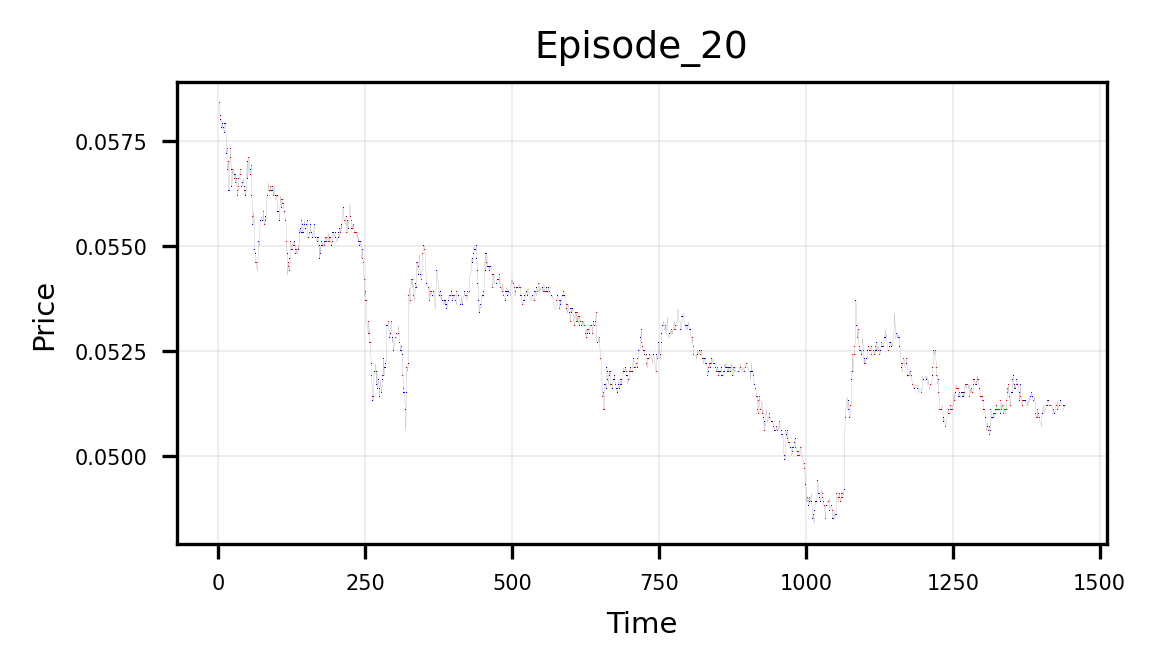

[Episode:  30] total reward: -11.2612, episode length : 1439
   cash: 72.185, coin: 21.074, total: 93.259
   sell: 414, hold: 625, buy: 400
   buffer size: 43170, epsilon: 0.4490
   time: 0.28 (min)


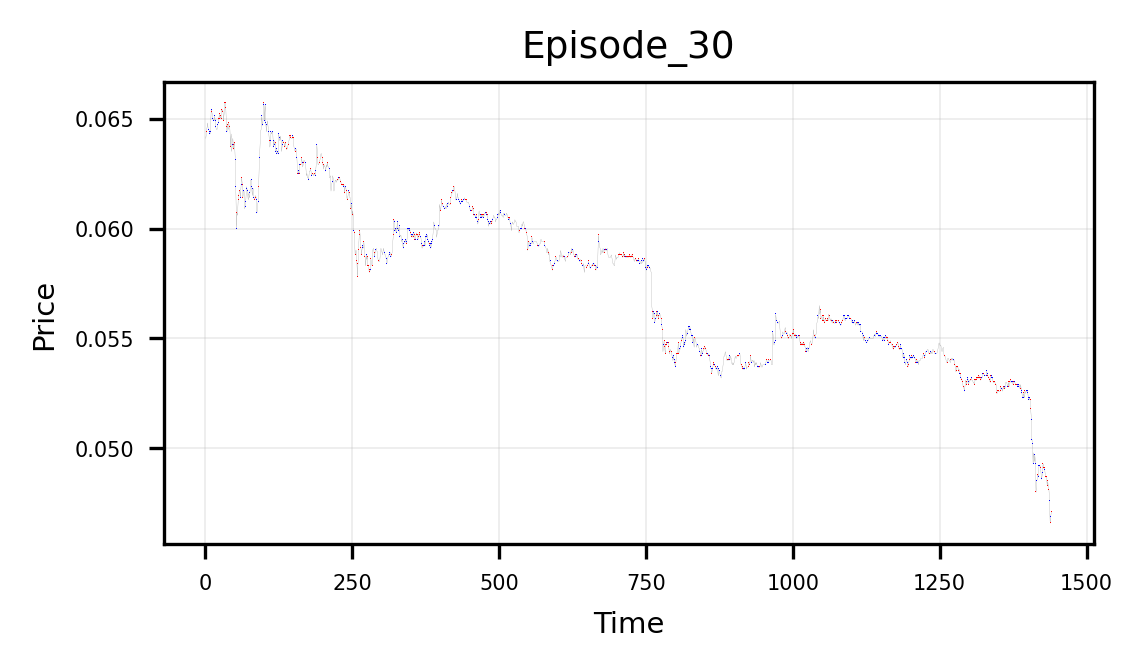

[Episode:  40] total reward: -6.7542, episode length : 1439
   cash: 31.222, coin: 66.354, total: 97.576
   sell: 375, hold: 662, buy: 402
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


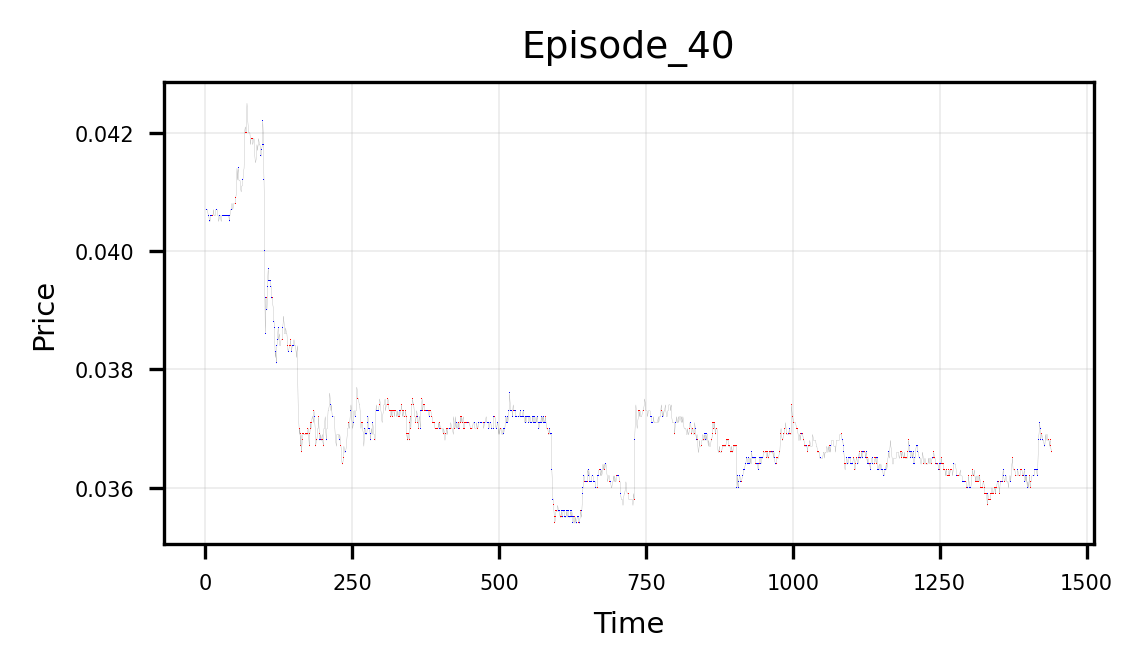

[Episode:  50] total reward: -9.9117, episode length : 1439
   cash: 36.495, coin: 56.708, total: 93.203
   sell: 241, hold: 934, buy: 264
   buffer size: 60000, epsilon: 0.0690
   time: 0.31 (min)


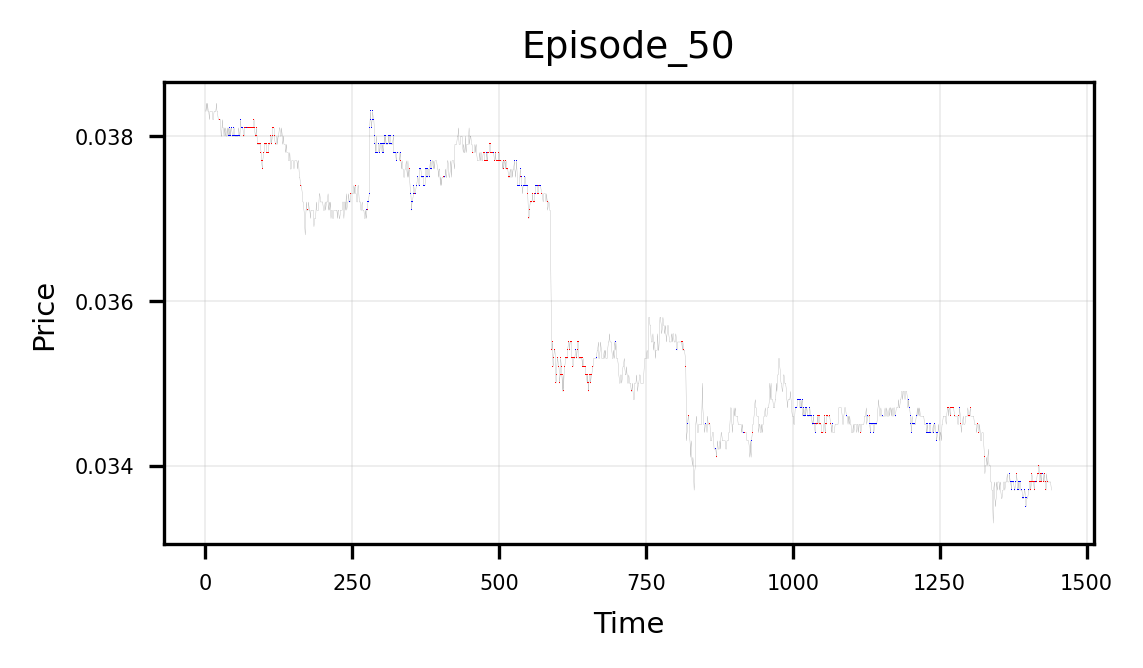

[Episode:  60] total reward: -1.7425, episode length : 1439
   cash: 70.715, coin: 29.318, total: 100.033
   sell: 147, hold: 1155, buy: 137
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


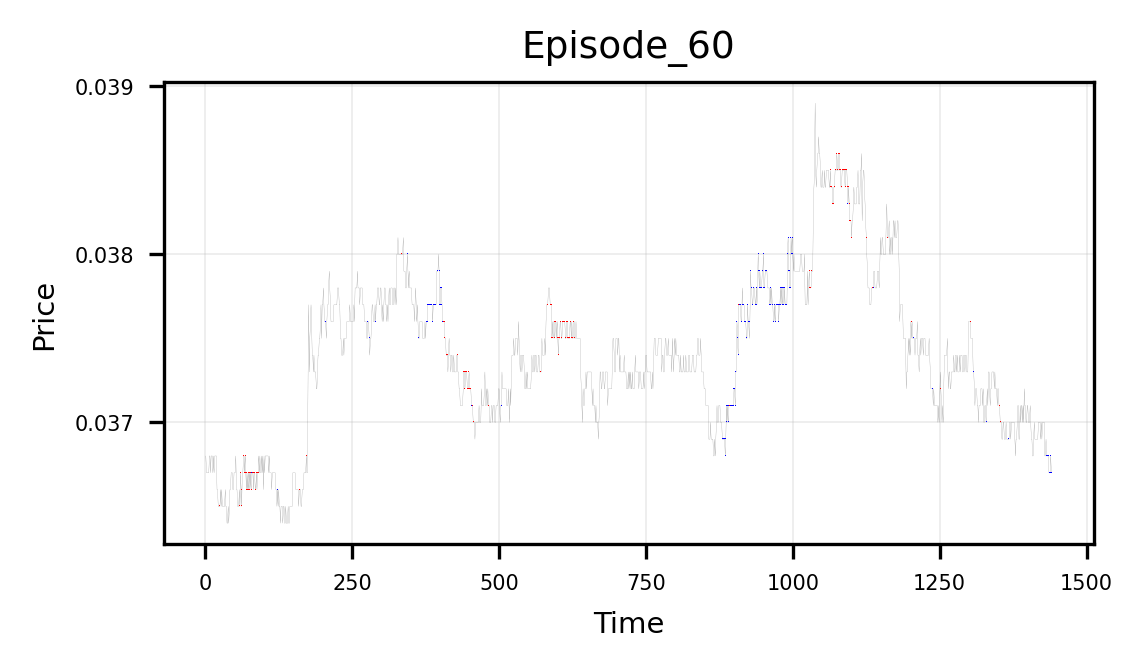

[Episode:  70] total reward: -2.2484, episode length : 1439
   cash: 93.820, coin: 5.922, total: 99.742
   sell: 107, hold: 1259, buy: 73
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


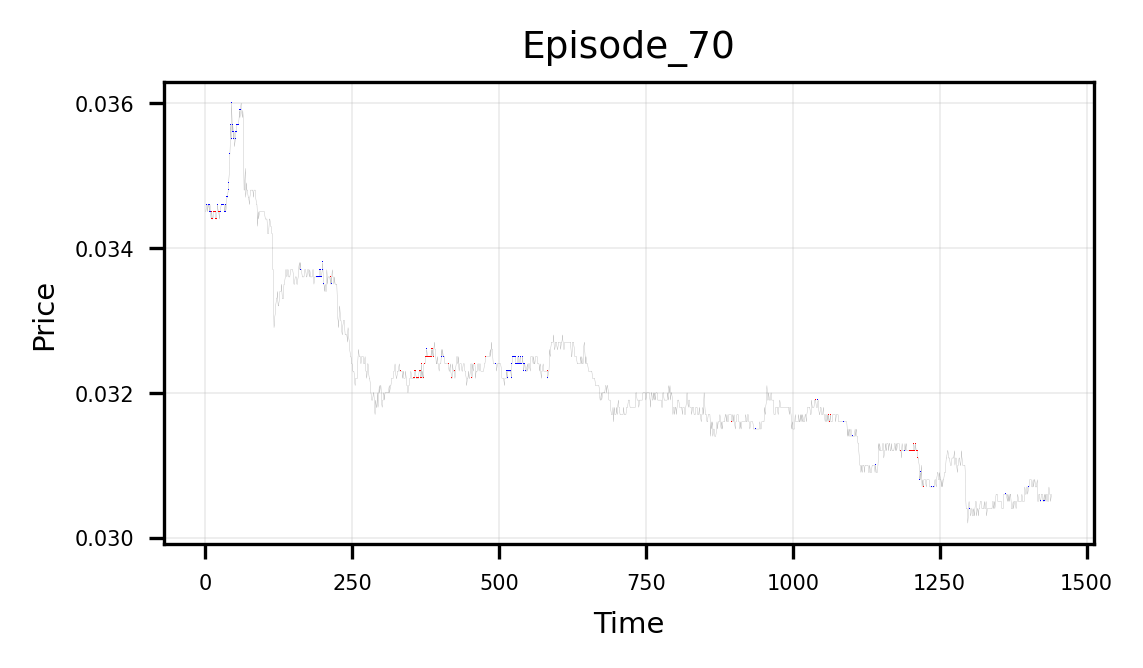

[Episode:  80] total reward: -14.8089, episode length : 1439
   cash: 86.595, coin: 1.531, total: 88.126
   sell: 216, hold: 1034, buy: 189
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


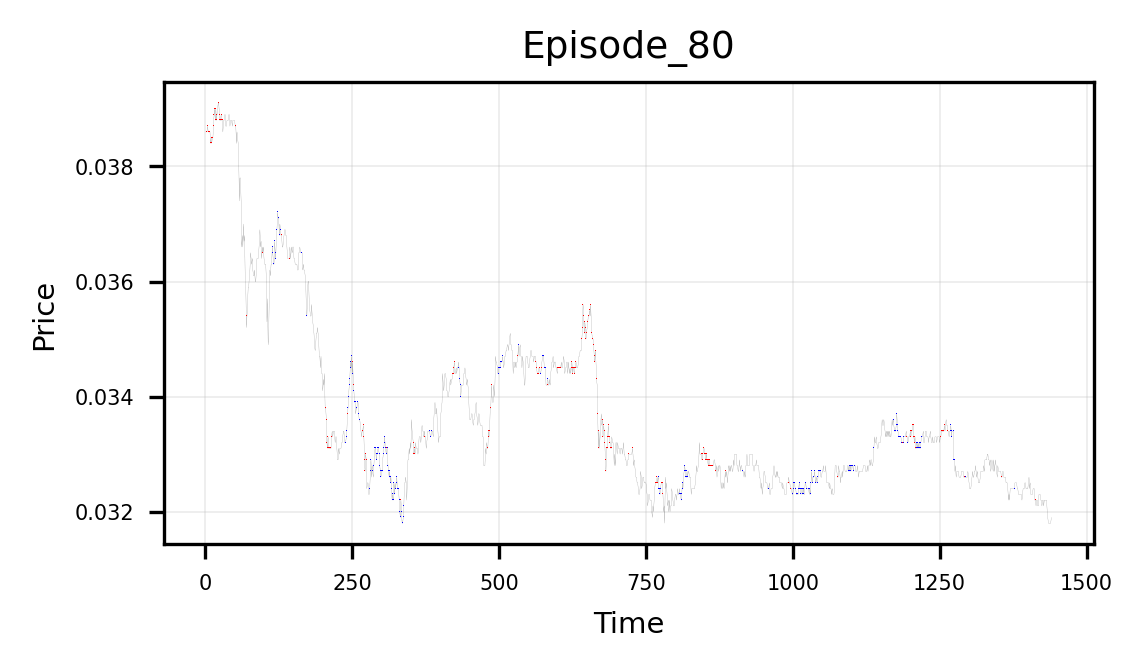

[Episode:  90] total reward: -0.5425, episode length : 1439
   cash: 47.730, coin: 53.402, total: 101.132
   sell: 129, hold: 1169, buy: 141
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


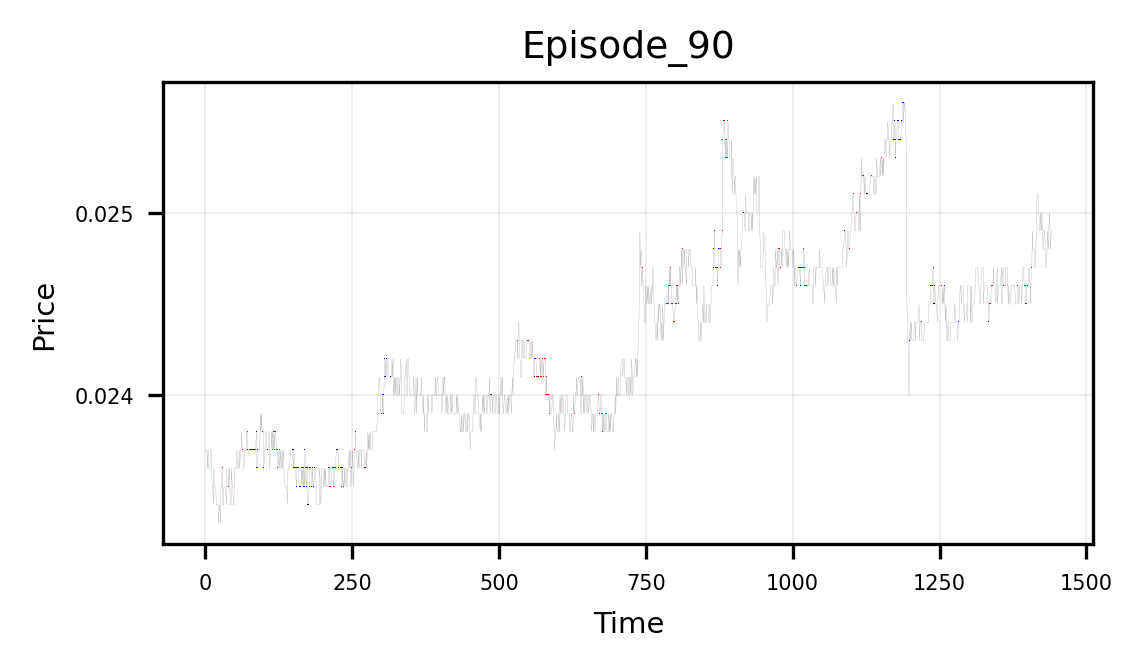

[Episode: 100] total reward: -5.7675, episode length : 1439
   cash: 95.472, coin: 1.736, total: 97.208
   sell: 282, hold: 911, buy: 246
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


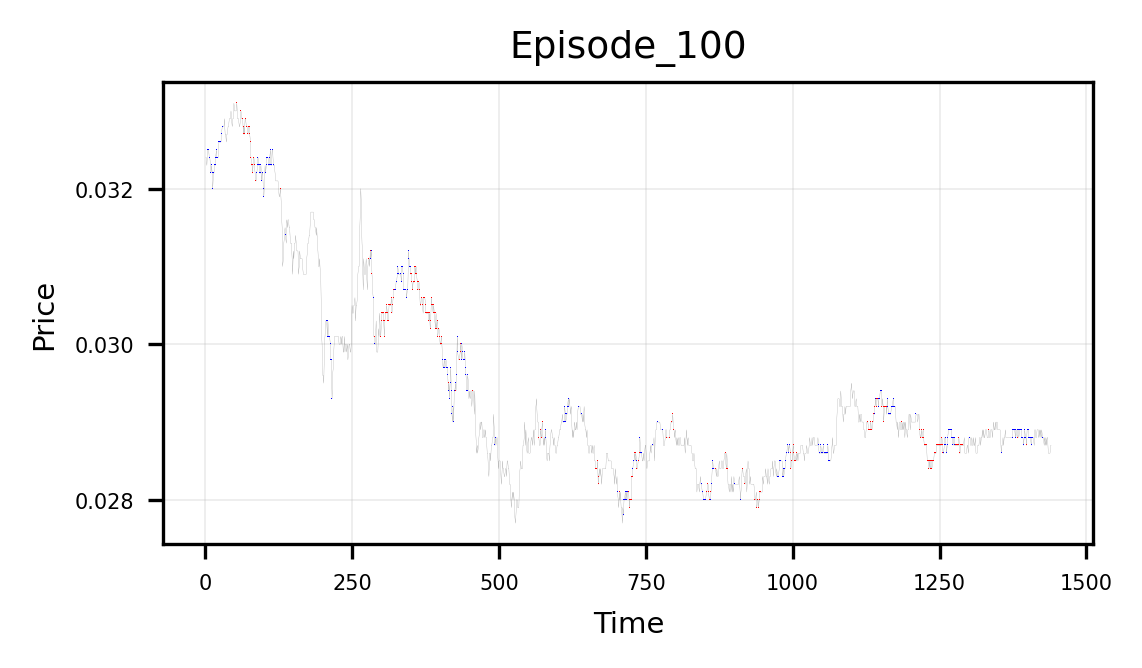

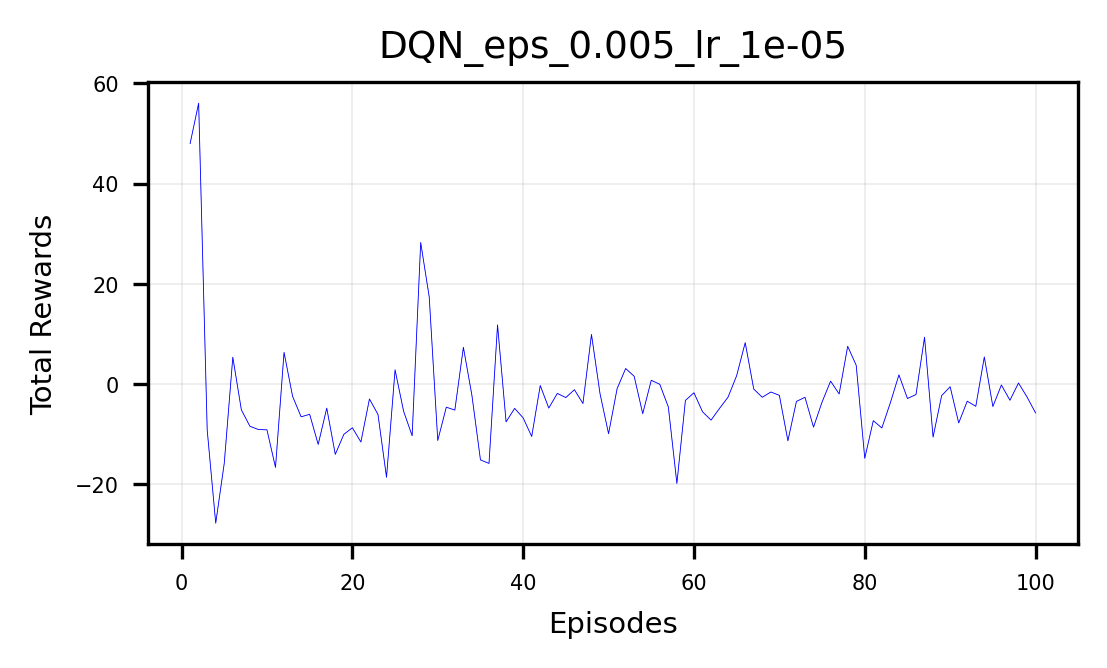

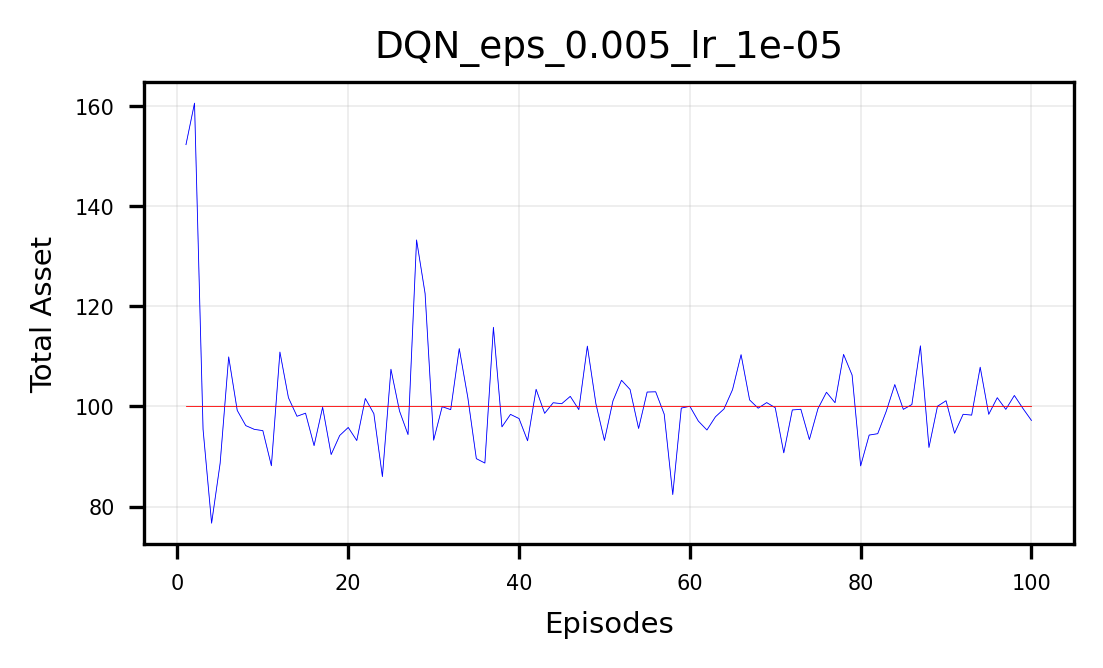

 ################ 
 lr : 1e-06  eps : 0.005 
 ################
Possible number of episodes: 241
[Episode:  10] total reward: -10.5652, episode length : 1439
   cash: 10.153, coin: 83.527, total: 93.680
   sell: 398, hold: 593, buy: 448
   buffer size: 14390, epsilon: 0.8290
   time: 0.27 (min)


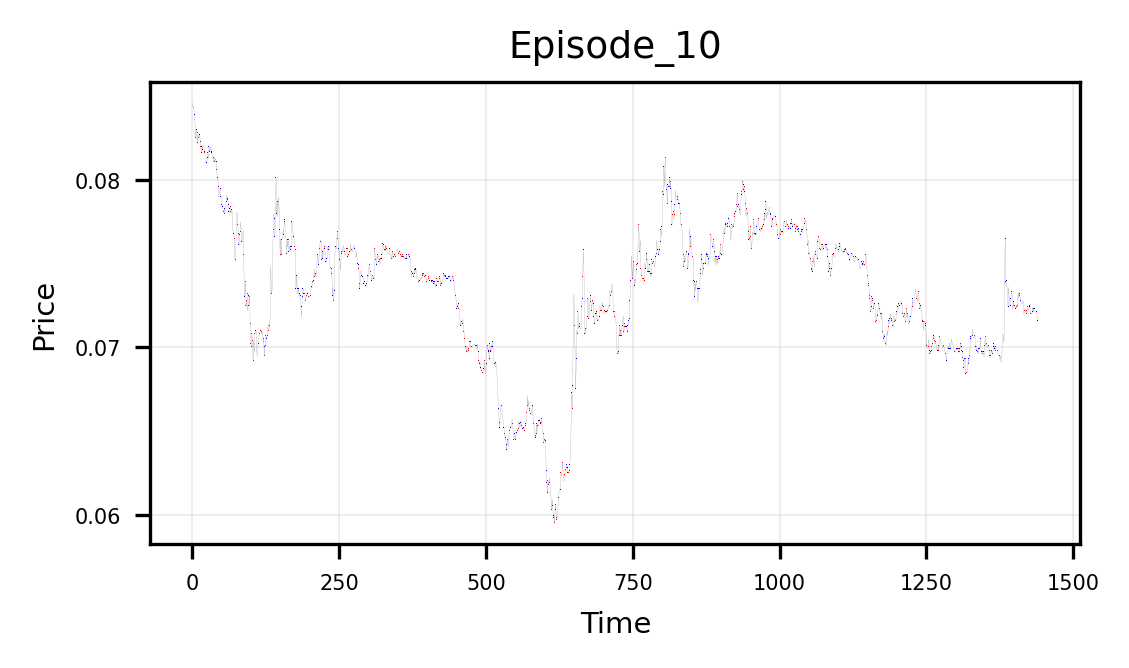

[Episode:  20] total reward: -8.6576, episode length : 1439
   cash: 85.114, coin: 10.658, total: 95.772
   sell: 455, hold: 554, buy: 430
   buffer size: 28780, epsilon: 0.6390
   time: 0.28 (min)


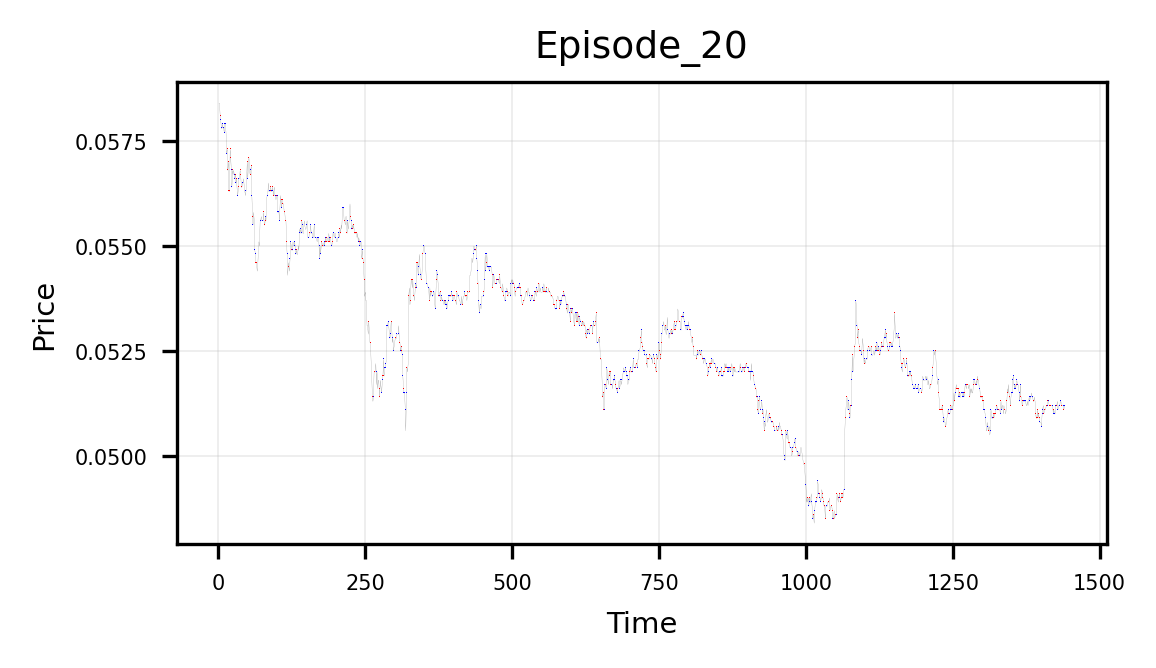

[Episode:  30] total reward: -14.7516, episode length : 1439
   cash: 69.100, coin: 20.648, total: 89.748
   sell: 455, hold: 540, buy: 444
   buffer size: 43170, epsilon: 0.4490
   time: 0.28 (min)


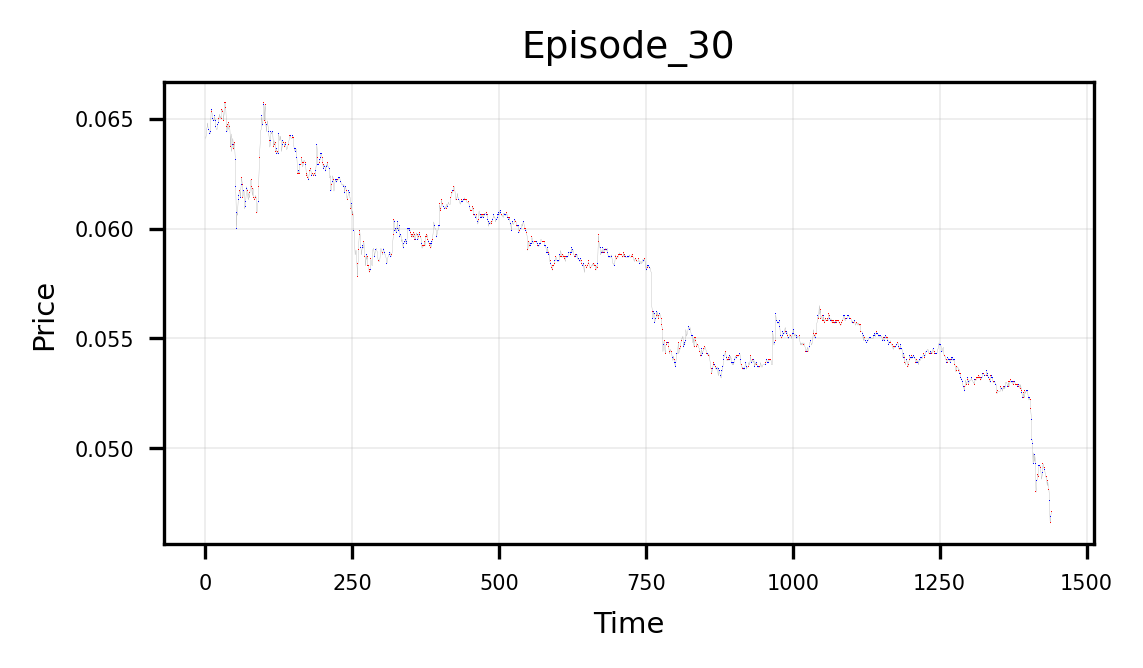

[Episode:  40] total reward: -6.5114, episode length : 1439
   cash: 76.269, coin: 21.145, total: 97.414
   sell: 374, hold: 709, buy: 356
   buffer size: 57560, epsilon: 0.2590
   time: 0.28 (min)


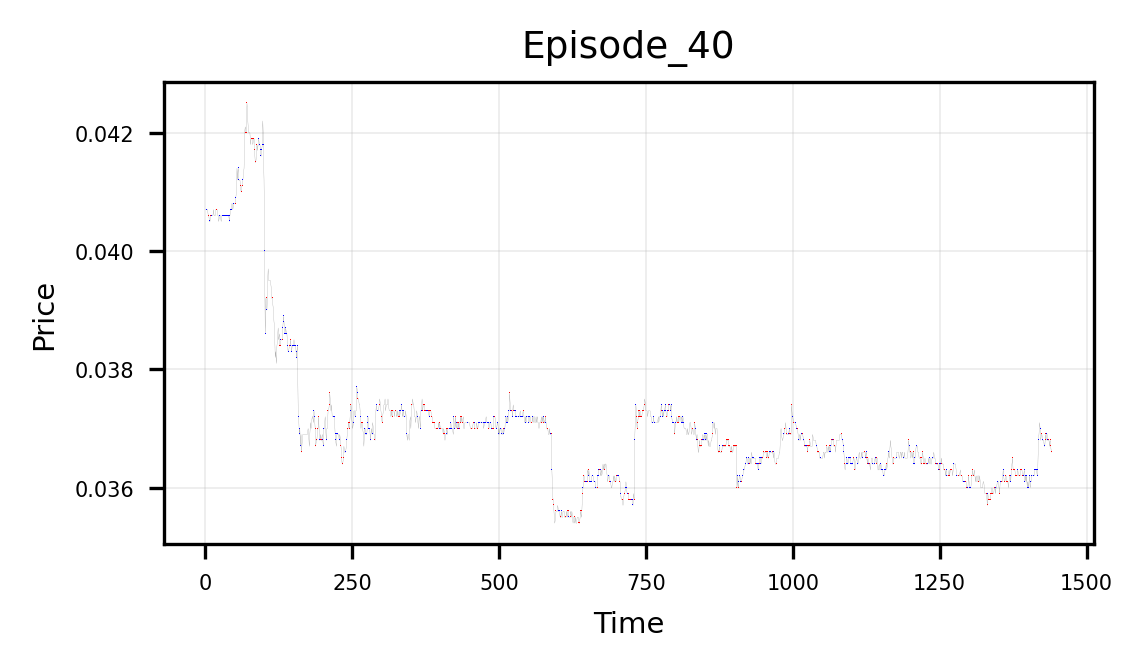

[Episode:  50] total reward: -9.4527, episode length : 1439
   cash: 11.268, coin: 82.954, total: 94.222
   sell: 342, hold: 708, buy: 389
   buffer size: 60000, epsilon: 0.0690
   time: 0.28 (min)


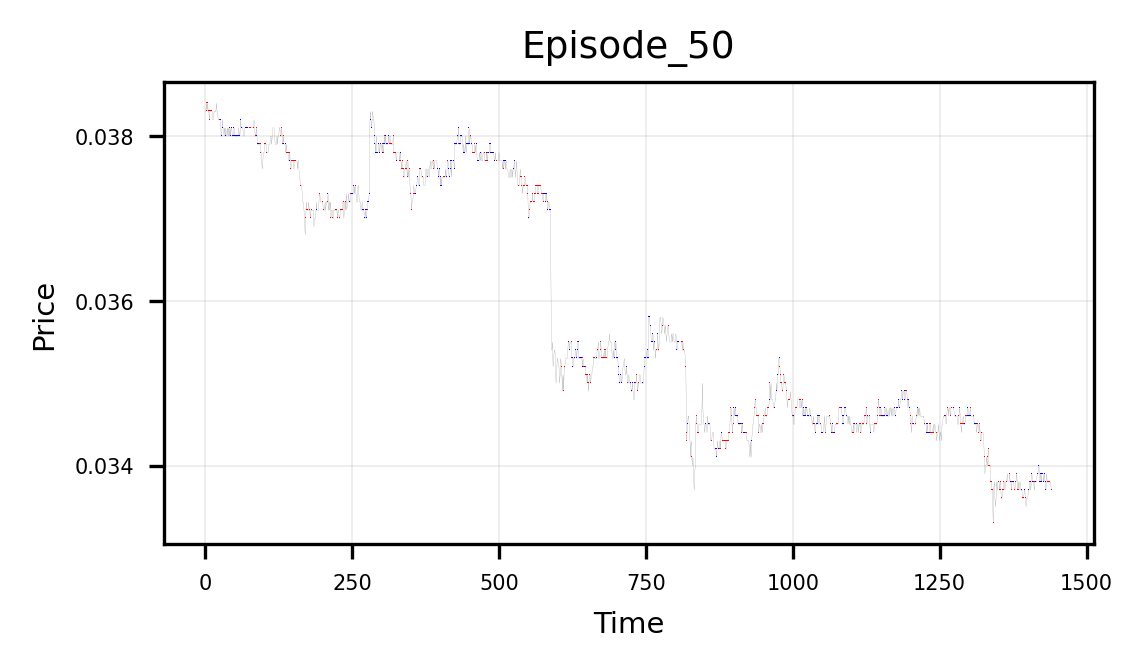

[Episode:  60] total reward: -5.5064, episode length : 1439
   cash: 0.317, coin: 97.682, total: 97.999
   sell: 312, hold: 756, buy: 371
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


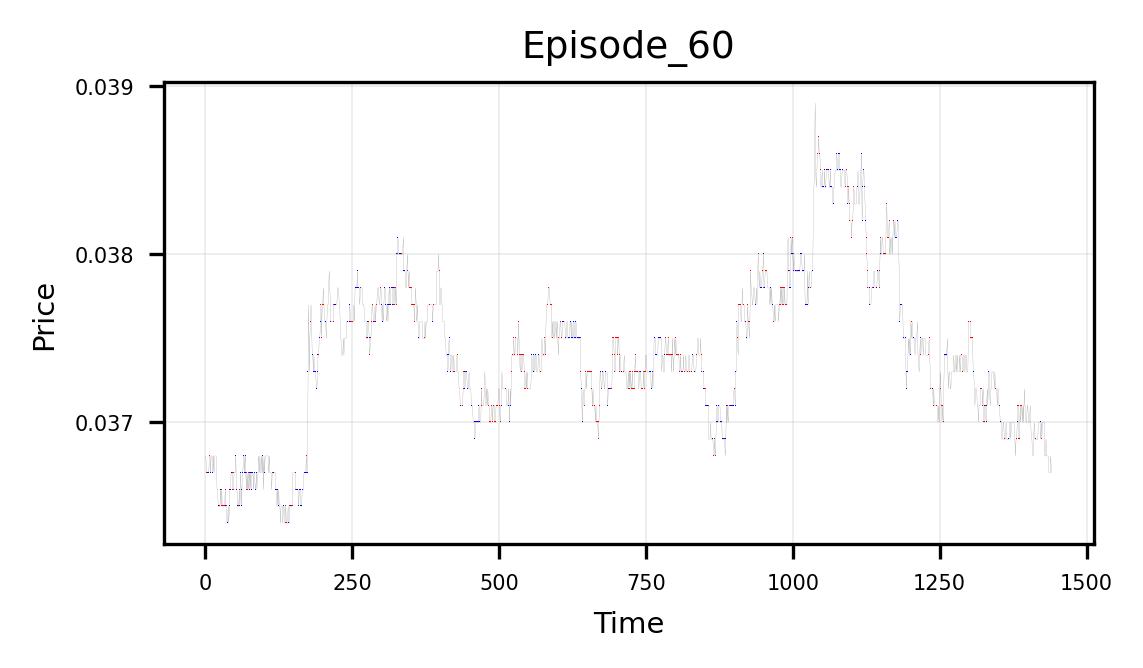

[Episode:  70] total reward: -8.0800, episode length : 1439
   cash: 90.481, coin: 4.604, total: 95.085
   sell: 275, hold: 921, buy: 243
   buffer size: 60000, epsilon: 0.0500
   time: 0.29 (min)


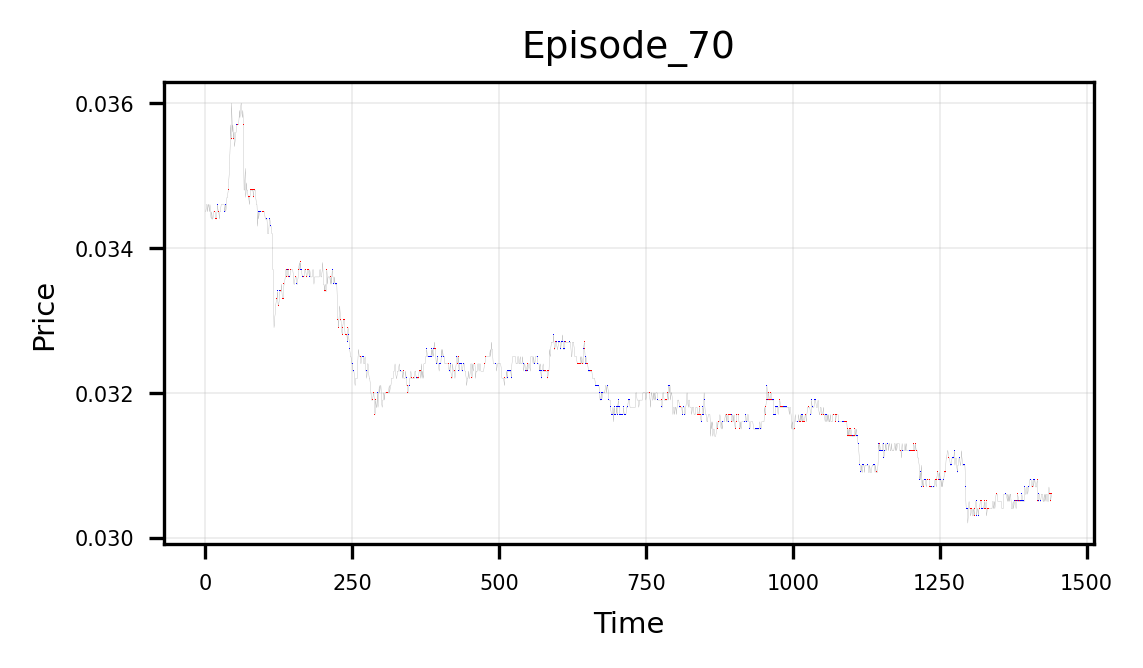

[Episode:  80] total reward: -8.4896, episode length : 1439
   cash: 0.373, coin: 94.767, total: 95.140
   sell: 284, hold: 812, buy: 343
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


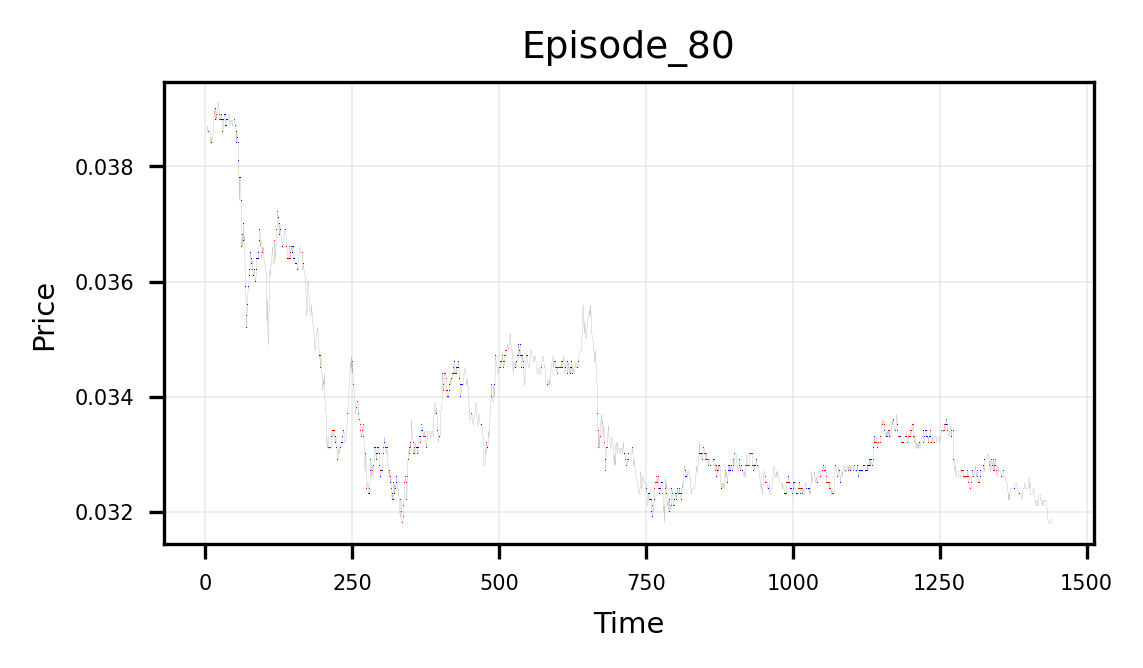

[Episode:  90] total reward: -0.5569, episode length : 1439
   cash: 94.383, coin: 8.215, total: 102.598
   sell: 326, hold: 822, buy: 291
   buffer size: 60000, epsilon: 0.0500
   time: 0.28 (min)


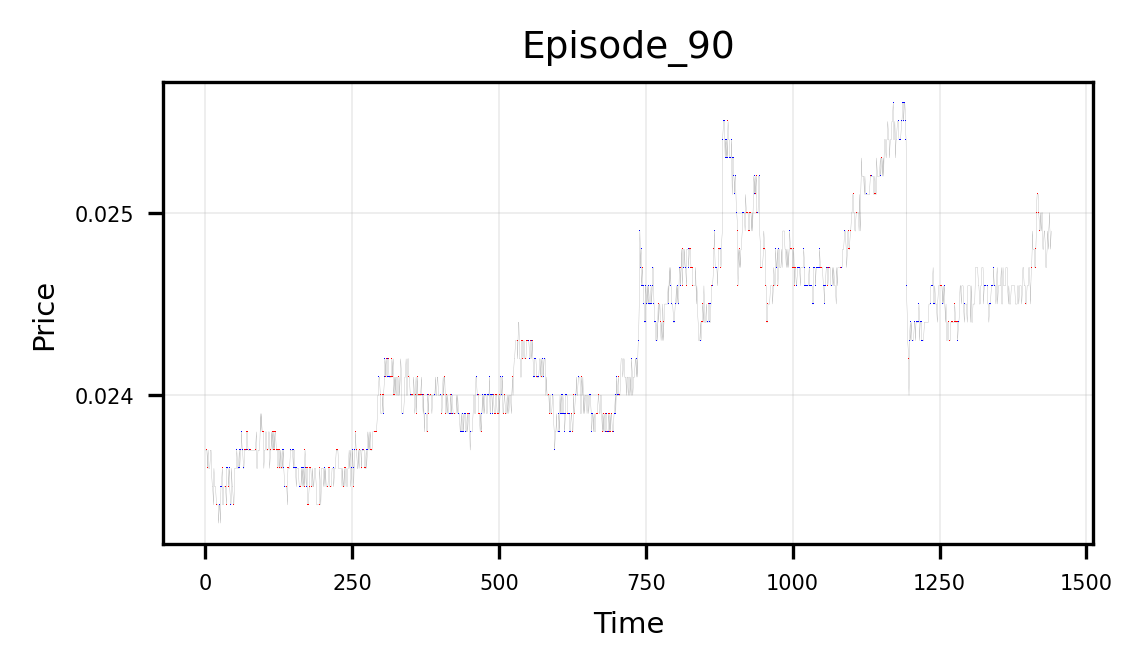

[Episode: 100] total reward: -9.2306, episode length : 1439
   cash: 0.537, coin: 93.022, total: 93.559
   sell: 202, hold: 976, buy: 261
   buffer size: 60000, epsilon: 0.0500
   time: 0.29 (min)


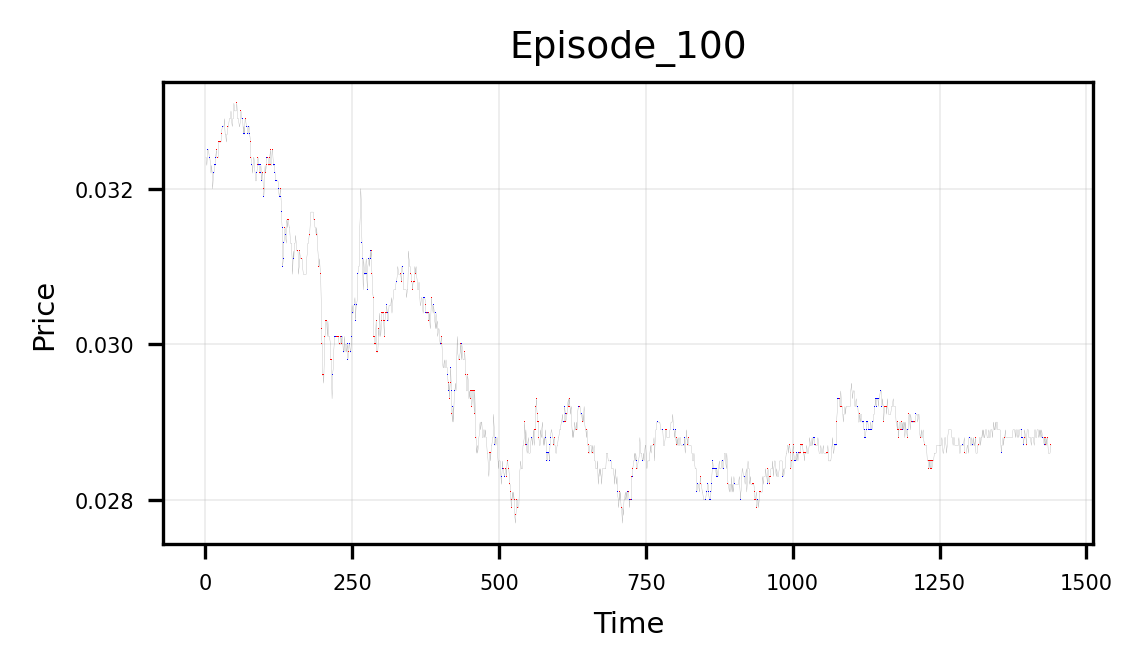

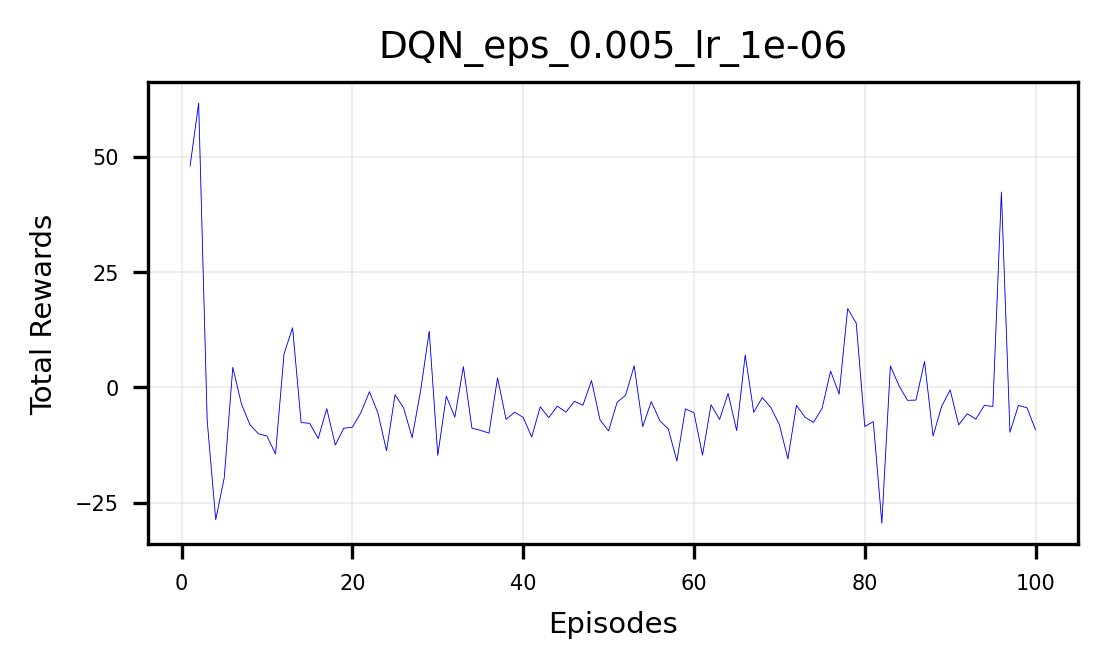

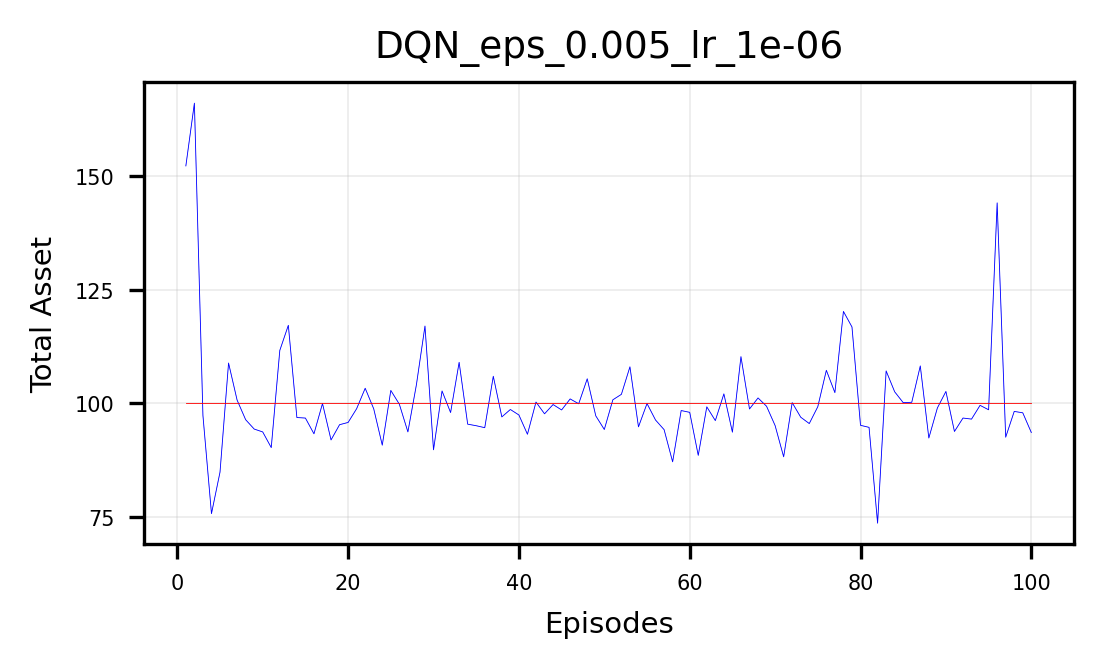

In [20]:
#reward_scale = [2,4,8,16,32,64,128,256]

eps_list = [0.01, 0.001, 0.005]
lr_list  = [1e-4, 1e-5, 1e-6]

for eps in eps_list:
    for lr in lr_list:    
        print(f' ################ \n lr : {lr}  eps : {eps} \n ################')
        seed = 2024
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        env = coin_env(df, start_index=10594, eps= eps)

        reward_list = []
        asset_list  = []
        action_num  = env.action_size
        one_hot_action = np.eye(action_num)

        replay_buffer = ReplayBuffer(capacity=buffer_size)

        behavior_Q = DQN(action_size=3)
        target_Q   = DQN(action_size=3)

        update_target(behavior_Q, target_Q)
        optimizer = torch.optim.Adam(behavior_Q.parameters(), lr=lr)

        for episode in range(max_episode):
            start = time.time()
            done = False

            episode_reward = 0
            episode_length = 0

            epsilon = linear_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)
            #lr      = sigmoidal_decay(episode, start_value=initial_lr, end_value=final_lr)
            #optimizer.learning_rate = lr

            state_index = env.reset(n=episode, init=100, cash_ratio=0.6)
            start_index = state_index
            end_index   = state_index 
            while not done:

                state_1   = env.state1[state_index-99:state_index+1]
                state_10  = env.state10[state_index-990:state_index+1:10, :]


                state = [torch.FloatTensor(state_1.T.reshape(1,5,100)), torch.FloatTensor(state_10.T.reshape(1,2,100))]
                action = get_action(behavior_Q, state, epsilon)
                next_state_index, reward, done = env.step(state_index, action)
                #reward = scale*reward
                episode_reward += reward
                episode_length += 1

                next_state_1   = env.state1[next_state_index-99:next_state_index+1]
                next_state_10  = env.state10[next_state_index-990:next_state_index+1:10, :]

                replay_buffer.store(state_1.T, state_10.T, one_hot_action[action], reward, next_state_1.T, next_state_10.T, done)

                if replay_buffer.size() >= batch_size and episode_length%replay_period[0] == 0:
                    update_Q(behavior_Q, target_Q, optimizer, replay_buffer, batch_size, gamma, device)

                if replay_buffer.size() >= batch_size and episode_length%replay_period[1] == 0:
                    update_target(behavior_Q, target_Q)
                    # soft_update_target(behavior_Q, target_Q, TAU=0.005)

                state_index = next_state_index
                end_index += 1

            reward_list.append(episode_reward)
            asset_list.append(env.state1[state_index][2]+env.state1[state_index][3])
            end = time.time()

            env.state1[start_index:end_index,4]

            if episode % plot_period == plot_period-1:
                print(f'[Episode: {episode+1:3d}] total reward: {episode_reward:.4f}, episode length : {episode_length}')
                print(f'   cash: {env.state1[state_index][2]:.3f}, coin: {env.state1[state_index][3]:.3f}, total: {env.state1[state_index][2]+env.state1[state_index][3]:.3f}')
                print(f'   sell: {list(env.state1[start_index:end_index,4]).count(-1)}, hold: {list(env.state1[start_index:end_index,4]).count(0)}, buy: {list(env.state1[start_index:end_index,4]).count(1)}')
                print(f'   buffer size: {replay_buffer.size():5d}, epsilon: {epsilon:.4f}')
                print(f'   time: {(end-start)/60:.2f} (min)')
                title = 'Episode_' + str(episode+1)
                save_path = save_folder +'log/eps_'+str(eps)+ '_lr_'+str(lr) +'_'+ title + '.png'
                # 거래기록 plot
                trade_log(np.array(env.close[start_index:end_index+1]), np.array(env.state1[start_index:end_index+1, 4]), title=title ,save_path=save_path)


        Title     = 'DQN_eps_'+str(eps)+'_lr_'+str(lr)
        save_path_reward = save_folder + Title + '.png'
        plot_save(rewards=[reward_list], title=Title, save_path=save_path_reward )

        save_path_asset = save_folder +'Asset_' + Title + '.png'
        plot_save(rewards=[asset_list], title=Title, save_path=save_path_asset, y_label='Total Asset' )